# Analyzinbinned Planktivore Image Abundance

## Synchro April 2025

Processing:  
A manifest of images names was generated as a .parquet file (F.B.).

Datetime valus are parsed from filenames, `'high_mag_cam-1744670420014743-71333078704-18-001-540-1014-84-20.tif'` where the second dash seperated values `1744670420014743`is a unix timestamp in microseconds. 

Once timestamps are converted into a pandas.datetime64 object, ~~it is converted into the local timezone (Pacific) and the timezone information is removed from the datetime object~~

LRAUV netcprofiles files were downloaded from the Axiom Research Workspace

In [1]:
import pandas as pd
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
from pathlib import Path
import seaborn as sns
import tqdm
#import rasterio
#from rasterio.plot import reshape_as_raster
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patheffects as pe
from scipy.signal import find_peaks, savgol_filter
import datetime as dt
from scipy.stats import linregress

# Directory for Generated Figures
fig_dir=Path("c:/planktivore/figures")
#fig_dir = Path("../../figures")

## Load High Mag Images Names

In [2]:
p = Path("z:/data/Planktivore/raw/2025_April-Ahi-Planktivore/")
# p = Path("../../inference_out")
df = pd.read_parquet(p/"April_2025_Ahi_highmag.parquet",)
df.rename(columns={0: "fileName"}, inplace=True)
df['dateStr'] = df["fileName"].str.split("-",expand=True)[1]
numeric_microseconds=pd.to_numeric(df['dateStr'])
#df['dateTime'] = pd.to_datetime(df['dateStr'], unit='us')
df['dateTime'] = pd.to_datetime(numeric_microseconds, unit='us')
df['dateTime'] = df['dateTime'].dt.tz_localize('UTC').dt.tz_localize(None)
df.index = df['dateTime']
df.reset_index(drop=True, inplace=True)


## Load Inference Data ##

Data are generated using `planktivore-inference.py`

In [3]:
#inference = pd.read_parquet(p / "interefence_mbari-ptvr-vits-b8-20250826.parquet")
#inference = pd.read_parquet("c:/planktivore/inference_results_mbari-ptvr-vits-b8-20250826_synchro_202504.parquet")
inference = pd.read_parquet("c:/planktivore/inference_results_mbari-ptvr-vits-b8-20251009.parquet")
# Copied from config.json
id2label = {
    "0": "Akashiwo",
    "1": "Amphidinium_Oxyphysis",
    "2": "Ceratium",
    "3": "Chaetoceros",
    "4": "Ciliate",
    "5": "Cylindrotheca",
    "6": "Detonula_Cerataulina_Lauderia",
    "7": "Detritus",
    "8": "Dictyocha",
    "9": "Dinoflagellate",
    "10": "Eucampia",
    "11": "Guinardia_Dactyliosolen",
    "12": "Gyrodinium",
    "13": "Medium_pennate",
    "14": "Mesodinium",
    "15": "Mixed_diatom_chain",
    "16": "Nano_plankton",
    "17": "Polykrikos",
    "18": "Prorocentrum",
    "19": "Pseudo-nitzschia",
    "20": "Strombidium",
    "21": "Thalassionema",
    "22": "Thalassiosira",
    "23": "Tiarina",
    "24": "Truncated",
    "25": "unknown_flagellate"
}

all_labels = list(id2label.values())
all_labels

['Akashiwo',
 'Amphidinium_Oxyphysis',
 'Ceratium',
 'Chaetoceros',
 'Ciliate',
 'Cylindrotheca',
 'Detonula_Cerataulina_Lauderia',
 'Detritus',
 'Dictyocha',
 'Dinoflagellate',
 'Eucampia',
 'Guinardia_Dactyliosolen',
 'Gyrodinium',
 'Medium_pennate',
 'Mesodinium',
 'Mixed_diatom_chain',
 'Nano_plankton',
 'Polykrikos',
 'Prorocentrum',
 'Pseudo-nitzschia',
 'Strombidium',
 'Thalassionema',
 'Thalassiosira',
 'Tiarina',
 'Truncated',
 'unknown_flagellate']

In [4]:
len(all_labels)

26

In [5]:
inference['label1'].unique()

array(['Pseudo-nitzschia', 'Tiarina', 'Dinoflagellate', 'Strombidium',
       'Ciliate', 'Chaetoceros', 'Detonula_Cerataulina_Lauderia',
       'Amphidinium_Oxyphysis', 'Thalassionema',
       'Guinardia_Dactyliosolen', 'unknown_flagellate', 'Cylindrotheca',
       'Mesodinium', 'Ceratium', 'Polykrikos', 'Truncated',
       'Mixed_diatom_chain', 'Thalassiosira', 'Medium_pennate',
       'Eucampia', 'Detritus', 'Nano_plankton', 'Prorocentrum',
       'Dictyocha', 'Gyrodinium', 'Akashiwo'], dtype=object)

In [6]:
inference['fileName'] = inference['file'].str.split("/", expand=True).iloc[:, -1]
inference['dateStr'] = inference["fileName"].str.split("-",expand=True)[1]
numeric_microseconds=pd.to_numeric(inference['dateStr'])
inference['dateTime'] = pd.to_datetime(numeric_microseconds, unit='us')
#inference['dateTime'] = pd.to_datetime(inference['dateStr'], unit='us')
inference['dateTime'] = inference['dateTime'].dt.tz_localize('UTC').dt.tz_localize(None)
inference.sort_values('dateTime', inplace=True)
inference.head()

file            label1  \
0  /home/flbahr/DeepSea_AI/data/Planktivore/raw/2...  Pseudo-nitzschia   
1  /home/flbahr/DeepSea_AI/data/Planktivore/raw/2...           Tiarina   
2  /home/flbahr/DeepSea_AI/data/Planktivore/raw/2...  Pseudo-nitzschia   
3  /home/flbahr/DeepSea_AI/data/Planktivore/raw/2...    Dinoflagellate   
4  /home/flbahr/DeepSea_AI/data/Planktivore/raw/2...       Strombidium   

     score1              label2    score2         label3    score3  \
0  0.888016  Mixed_diatom_chain  0.085294  Cylindrotheca  0.007314   
1  0.758947         Strombidium  0.218152       Ceratium  0.011974   
2  0.315625       Thalassionema  0.303134  Cylindrotheca  0.221518   
3  0.466724         Strombidium  0.207526        Tiarina  0.156072   
4  0.685018             Tiarina  0.093563  Thalassiosira  0.088566   

                                            fileName           dateStr  \
0  high_mag_cam-1744670418511151-69633235648-1-00...  1744670418511151   
1  high_mag_cam-1744670418593206-69733219272-2-00...  1744670418593206   
2  high_mag_cam-1744670418665440-69833217896-3-00...  1744670418665440   
3  high_mag_cam-1744670418666251-69833217896-3-00...  1744670418666251   
4  high_mag_cam-1744670418733857-69933202192-4-00...  1744670418733857   

                    dateTime  
0 2025-04-14 22:40:18.511151  
1 2025-04-14 22:40:18.593206  
2 2025-04-14 22:40:18.665440  
3 2025-04-14 22:40:18.666251  
4 2025-04-14 22:40:18.733857

In [7]:
# new code to drop values which are not confident
# actually we want to rename these values 
# add a boolean column for confident or not
# this avoids having to name the untrusted values with bad_image or other
# where other is specifically used for non-living things (i.e. IFCB PTWG, Standard and practices for reporting plankton and other particle observations from images, 2020)
conf_threshold = 0.5
inference_filtered=inference.copy()
inference_filtered['trust'] = inference_filtered['score1'] >= conf_threshold

In [8]:
print(inference.shape)
print(inference_filtered.shape)

(429680, 10)
(429680, 11)


## Load LRAUV Data

These data are found as netcdf files on the Research Workspace:

`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504142054_202504150400_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504150400_202504152346_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504152347_202504160013_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160014_202504160017_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160018_202504181753_2S_scieng.nc`


__Goal__: Align the datetime from planktivore images to the LRAUV CTD Data (with some type of tolerance)

In [9]:
##glider_fnames = sorted(glob.glob("/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/*_scieng.nc"))
glider_fnames = sorted(glob.glob("c:/planktivore/*_scieng.nc"))
ds = xr.open_mfdataset(glider_fnames,
                       join='outer',
                       compat='no_conflicts')

In [10]:
# remove unneeded variables to make dataset smaller
ds=ds.drop_vars('health_platform_battery_charge')
ds=ds.drop_vars('health_platform_average_voltage')
ds=ds.drop_vars('health_platform_average_current')
ds=ds.drop_vars('control_inputs_buoyancy_position')
ds=ds.drop_vars('control_inputs_elevator_angle')
ds=ds.drop_vars('control_inputs_rudder_angle')
ds=ds.drop_vars('control_inputs_mass_position')
ds=ds.drop_vars('pose_latitude_DeadReckonUsingMultipleVelocitySources')
ds=ds.drop_vars('pose_longitude_DeadReckonUsingMultipleVelocitySources')
ds=ds.drop_vars('pose_depth_DeadReckonUsingMultipleVelocitySources')
ds=ds.drop_vars('pitch')
ds=ds.drop_vars('roll')
ds=ds.drop_vars('yaw')

In [11]:
ds

<xarray.Dataset> Size: 31MB
Dimensions:                                                                        (
                                                                                    time: 167185)
Coordinates:
  * time                                                                           (time) datetime64[ns] 1MB ...
    latitude                                                                       (time) float64 1MB dask.array<chunksize=(74,), meta=np.ndarray>
    longitude                                                                      (time) float64 1MB dask.array<chunksize=(74,), meta=np.ndarray>
    depth                                                                          (time) float64 1MB dask.array<chunksize=(74,), meta=np.ndarray>
Data variables: (12/19)
    fix_latitude                                                                   (time) float64 1MB dask.array<chunksize=(74,), meta=np.ndarray>
    fix_longitude                                                                  (time) float64 1MB dask.array<chunksize=(74,), meta=np.ndarray>
    salinity                                                                       (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    temperature                                                                    (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    mass_concentration_of_oxygen_in_sea_water                                      (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    bin_mean_sea_water_salinity                                                    (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    ...                                                                             ...
    bbp650                                                                         (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    volumescatcoeff117deg470nm                                                     (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    volumescatcoeff117deg650nm                                                     (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    particulatebackscatteringcoeff470nm                                            (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    particulatebackscatteringcoeff650nm                                            (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
    fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources  (time) float64 1MB dask.array<chunksize=(55450,), meta=np.ndarray>
Attributes: (12/27)
    title:                         Ahi 27 Synchro - LRAUV interpolated data
    deployment_name:               Ahi 27 Synchro
    summary:                       Observational oceanographic data translate...
    netcdf_version:                3.6
    Conventions:                   CF-1.6
    date_created:                  2025-04-19T16:00:37.440608
    ...                            ...
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    time_coverage_start:           2025-04-14T20:54:41.081282
    time_coverage_end:             2025-04-15T03:59:58
    useconst:                      Not intended for legal use. Data may conta...
    history:                       Created by STOQS software command "stoqs/l...

In [12]:
# place to save figures
#fig_dir = Path("../../figures")
fig_dir=Path("c:/planktivore/figures")

### Make Flat dataframe from Profile data

In [13]:
lrauv_raw = ds.to_dataframe()
profiles = lrauv_raw.copy()
# below was Patrick's ad hoc filtering
#sstart = dt.datetime(2025,4,14,20)
#etime = dt.datetime(2025,4,20)
## can we automate any of this?
#profiles = profiles.query("depth < 400 & time < @etime")
#profiles = profiles.iloc[150:-4225]

In [14]:
# Gemini code
def find_flat_line_regions(
    df: pd.DataFrame, 
    column_name: str, 
    threshold: float, 
    window_size: int, 
    max_std: float
) -> pd.Index:
    """
    Identifies indices where the data is flat and below a specific threshold.

    Args:
        df: The input pandas DataFrame.
        column_name: The name of the column ('depth') to analyze.
        threshold: The maximum value the data can reach (e.g., 100).
        window_size: The rolling window size for calculating flatness (e.g., 10).
        max_std: The maximum allowable standard deviation for a 'flat' segment (e.g., 0.5).

    Returns:
        A pandas Index object containing the indices of the flat regions.
    """
    
    # 1. Check the 'below threshold' condition (a simple boolean Series)
    # This filters out all data points that are above the general threshold.
    is_below_threshold = df[column_name] < threshold

    # 2. Check the 'flatness' condition using Rolling Standard Deviation (STD)
    # Small standard deviation implies low variability (i.e., flat line).
    # We use .rolling(window_size, center=True) to look both backward and forward.
    rolling_std = df[column_name].rolling(
        window=window_size, 
        min_periods=1, # Ensure we get results near the start/end
        center=True
    ).std()
    
    is_flat = rolling_std > max_std

    # 3. Combine both conditions
    # We want indices where BOTH conditions are True.
    flat_regions = df.index[is_below_threshold & is_flat]
    
    return flat_regions

# --- Example Usage ---

# 1. Create Sample Data
# We'll create a sample 'depth' series with a flat section below 100.
#data = {
#    'depth': [10, 11, 10, 12, 100, 101, 10, 10.1, 9.9, 10.0, 10.2, 150, 152]
#}
#df = pd.DataFrame(data)
#
## 2. Define Parameters
#THRESHOLD = 15.0       # The depth must be less than 15.0
#WINDOW_SIZE = 5        # Check flatness over 5 consecutive points
#MAX_STD = 0.5          # Standard deviation must be less than 0.5 for 'flatness'
#
## 3. Find the Regions
#flat_indices = find_flat_line_regions(
#    df, 
#    'depth', 
#    THRESHOLD, 
#    WINDOW_SIZE, 
#    MAX_STD
#)
#
#print("--- Input Data ---")
#print(df)
#print(f"\nFlatness window size: {WINDOW_SIZE}")
#print(f"Max depth threshold: {THRESHOLD}")
#print(f"Max standard deviation: {MAX_STD}")
#print("\n--- Indices of Flat Regions Below Threshold ---")
#print(flat_indices)

# To get the actual DataFrame rows:
# df.loc[flat_indices]

In [15]:
# This code allows for automation of removing flat profiles
# this is before profiles are defined.  Problem is that it leaves the very first point of a flat region.
flatvalues=find_flat_line_regions(lrauv_raw,'depth',300,14,0.5)
profiles=lrauv_raw.loc[flatvalues]

In [16]:
def label_casts_by_turning_points(
    df,
    depth_col="depth",
    smooth=True,
    win_len=21,         # odd integer; tune as neeed
    polyorder=2,
    peak_prominence=0.25,  # meters; tune to ignore tiny wiggles in depth
    peak_distance=10       # samples; min spacing between turning points
):
    """
    Label AUV casts using turning points (depth minima/maxima).
    Returns a copy of df with:
      - 'phase': 'down'|'up'|'turn'
      - 'cast_id': Int64 (new cast at the start of each 'down' segment)
    Assumes DateTimeIndex and depth positive downward.
    """
    out = df.sort_index().copy()
    depth = out[depth_col].to_numpy()
    n = len(out)
    if n == 0:
        return out.assign(phase=np.nan, cast_id=pd.Series(dtype="Int64"))

    # --- optional smoothing: Savgol_filter - Fits polynomial over a window ---
    if smooth and n >= 7:
        wl = win_len if n >= win_len else max(3, (n//2)*2 + 1)
        depth_s = savgol_filter(depth, window_length=wl, polyorder=polyorder, mode="interp")
    else:
        depth_s = depth.copy()

    # --- turning points ---
    deep_idx, _    = find_peaks( depth_s, prominence=peak_prominence, distance=peak_distance)   # local maxima (deep)
    shallow_idx, _ = find_peaks(-depth_s, prominence=peak_prominence, distance=peak_distance)   # local minima (shallow)
    turn_idx = np.unique(np.sort(np.r_[deep_idx, shallow_idx]))

    # Ensure we include start/end as implicit boundaries if needed
    if len(turn_idx) == 0 or turn_idx[0] != 0:
        turn_idx = np.r_[0, turn_idx]
    if turn_idx[-1] != n-1:
        turn_idx = np.r_[turn_idx, n-1]

    phase = np.array(["turn"]*n, dtype=object)
    cast_id = np.full(n, np.nan)
    current = 0

    # --- label each segment between turning points ---
    for a, b in zip(turn_idx[:-1], turn_idx[1:]):
        if b <= a: 
            continue
        seg = slice(a, b+1)  # inclusive segment

        # slope sign from endpoints (robust for monotonic segments)
        going_deeper = (depth_s[b] > depth_s[a])
        if going_deeper:
            phase[seg] = "down"
            # start a new cast at the *beginning* of each down segment
            current += 1
            cast_id[seg] = current
        else:
            phase[seg] = "up"
            if current > 0:
                cast_id[seg] = current

    out["phase"] = phase
    out["cast_id"] = pd.Series(cast_id, index=out.index).astype("Int64")
    out["turning_point"] = False
    out.loc[out.index[turn_idx], "turning_point"] = True
    return out

labeled = label_casts_by_turning_points(
    profiles,
    depth_col="depth",
    smooth=True,
    win_len=21,
    polyorder=2,
    peak_prominence=4,  # raise to skip tiny kinks; lower if casts are gentle
    peak_distance=20       # increase if you’re over-detecting turns
)

In [17]:
# what if we do the flat line removal after casts are defined
#flatvalues=find_flat_line_regions(lrauv_raw,'depth',300,14,0.5)
#profiles=lrauv_raw.loc[flatvalues]
#x=np.unique(labeled['cast_id'][:])
#ncasts=np.arange(0,len(x))
#flatvalues=find_flat_line_regions(labeled[labeled['cast_id']==12],'depth',300,14,0.5)
#labeledx=labeled.drop(flatvalues)
#plt.plot(labeledx[labeledx['cast_id']==12]['depth'])
#plt.gca().invert_yaxis()
#plt.show()
#for i in ncasts:
#    flatvalues=find_flat_line_regions(labeled[labeled['cast_id']==x[i]],'depth',300,14,0.5)
#    # does this actually work are these indices valid for the full labeled dataframe?
#    labeled=labeled.drop(flatvalues)


In [18]:
# Generate cast_id_unique that is unique for each down and up segment
mask = labeled['cast_id'].notna()
labeled.loc[mask, 'cast_id_unique'] = (
    labeled.loc[mask, 'cast_id'] * 2 +
    (labeled.loc[mask, 'phase'] == 'up').astype(int) - 1
).astype('Int64')

In [19]:
labeled

fix_latitude  fix_longitude   salinity  temperature  \
time                                                                       
2025-04-14 21:00:16     36.796617    -121.845926  33.655167    11.912500   
2025-04-14 21:00:18     36.796616    -121.845925  33.653259    11.924219   
2025-04-14 21:00:20     36.796614    -121.845925  33.654690    11.912500   
2025-04-14 21:00:22     36.796613    -121.845925  33.653736    11.916407   
2025-04-14 21:00:24     36.796611    -121.845924  33.655643    11.900782   
...                           ...            ...        ...          ...   
2025-04-18 15:31:52     36.800987    -121.846133  33.915520     9.100000   
2025-04-18 15:31:54     36.800986    -121.846131  33.915520     9.100000   
2025-04-18 15:31:56     36.800986    -121.846129  33.915520     9.100000   
2025-04-18 15:31:58     36.800985    -121.846126  33.915520     9.100000   
2025-04-18 15:32:00     36.800985    -121.846124  33.915520     9.100000   

                     mass_concentration_of_oxygen_in_sea_water  \
time                                                             
2025-04-14 21:00:16                                8408.785156   
2025-04-14 21:00:18                                8406.162109   
2025-04-14 21:00:20                                8408.189453   
2025-04-14 21:00:22                                8407.353516   
2025-04-14 21:00:24                                8411.288086   
...                                                        ...   
2025-04-18 15:31:52                                2410.054199   
2025-04-18 15:31:54                                2410.054199   
2025-04-18 15:31:56                                2410.054199   
2025-04-18 15:31:58                                2410.054199   
2025-04-18 15:32:00                                2410.054199   

                     bin_mean_sea_water_salinity  \
time                                               
2025-04-14 21:00:16                    33.654849   
2025-04-14 21:00:18                    33.654531   
2025-04-14 21:00:20                    33.654213   
2025-04-14 21:00:22                    33.654690   
2025-04-14 21:00:24                    33.655167   
...                                          ...   
2025-04-18 15:31:52                    33.916473   
2025-04-18 15:31:54                    33.916473   
2025-04-18 15:31:56                    33.916473   
2025-04-18 15:31:58                    33.916473   
2025-04-18 15:32:00                    33.916473   

                     bin_median_sea_water_salinity  \
time                                                 
2025-04-14 21:00:16                      33.654849   
2025-04-14 21:00:18                      33.654531   
2025-04-14 21:00:20                      33.654213   
2025-04-14 21:00:22                      33.654213   
2025-04-14 21:00:24                      33.654213   
...                                            ...   
2025-04-18 15:31:52                      33.916473   
2025-04-18 15:31:54                      33.916473   
2025-04-18 15:31:56                      33.916473   
2025-04-18 15:31:58                      33.916473   
2025-04-18 15:32:00                      33.916473   

                     bin_mean_sea_water_temperature  \
time                                                  
2025-04-14 21:00:16                       11.909896   
2025-04-14 21:00:18                       11.915105   
2025-04-14 21:00:20                       11.920313   
2025-04-14 21:00:22                       11.912500   
2025-04-14 21:00:24                       11.904688   
...                                             ...   
2025-04-18 15:31:52                        9.092188   
2025-04-18 15:31:54                        9.092188   
2025-04-18 15:31:56                        9.092188   
2025-04-18 15:31:58                        9.092188   
2025-04-18 15:32:00                        9.092188   

                     bin_median_sea_water_temperature         PAR  ...  \
tim

In [20]:
# Now we can clean salinity based on jumps
# This is not perfect but should help
salty=labeled['salinity']
bads=np.where(np.abs(np.diff(salty))> 0.25)[0]
badlabels=labeled.index[bads+1]
labeled.loc[badlabels,'salinity']=np.nan

In [21]:

def rolling_r_squared(series_x: pd.Series, series_y: pd.Series, window: int) -> pd.Series:
    """
    Calculates the R-squared (coefficient of determination) for a linear fit
    within a rolling window, adapted for speed using NumPy and SciPy.
    """
    # Create an array of R-squared values, initialized to NaN
    r_squared_values = np.full(len(series_y), np.nan)
    
    # Iterate through the series, calculating linregress for each window
    # Note: Rolling functions can be complex to optimize purely with built-ins
    # We iterate, but use fast NumPy/SciPy operations within the loop.
    for i in range(len(series_y) - window + 1):
        x_window = series_x.iloc[i : i + window]
        y_window = series_y.iloc[i : i + window]
        
        # Check for minimum variability required for linregress to work
        # If x is constant (dx=0) or y is constant (dy=0), linregress may fail/be trivial
        if x_window.std() == 0:
             r_squared_values[i + window - 1] = 0.0 # Assign R^2 = 0 for constant x
             continue

        # Perform the linear regression
        # slope, intercept, r_value, p_value, std_err = linregress(...)
        result = linregress(x_window, y_window)
        
        # R-squared is r_value**2
        r_squared_values[i + window - 1] = result.rvalue**2

    # Convert the resulting array back to a Series
    return pd.Series(r_squared_values, index=series_y.index).shift(-(window-1))


def detect_interpolated_segments_rolling(
    df: pd.DataFrame, 
    value_col: str, 
    index_col: str, 
    window_size: int, 
    min_r_squared: float = 0.999
) -> pd.Series:
    """
    Detects segments where data is highly linear (likely interpolated) 
    over a defined rolling window size.

    Args:
        df: The input pandas DataFrame.
        value_col: The column containing the data values (Y-axis).
        index_col: The column containing the index/depth/time (X-axis).
        window_size: The number of consecutive points to check for linearity (e.g., 5).
        min_r_squared: The R^2 threshold to define a segment as 'linear'. 
                       (e.g., 0.999 for very strict linearity).

    Returns:
        A boolean Series where True indicates the point belongs to a highly linear segment.
    """
    if window_size < 3:
        raise ValueError("Window size must be 3 or greater for meaningful linear fit.")
        
    # 1. Calculate the Rolling R-squared
    r_squared = rolling_r_squared(
        df[index_col], 
        df[value_col], 
        window=window_size
    )

    # 2. Identify segments with a near-perfect linear fit
    is_highly_linear = r_squared >= min_r_squared

    # 3. Spread the 'True' flag across the entire window
    # The R^2 value is calculated for the *end* of the window, but we want 
    # all points within that window to be flagged.
    
    # The easiest way to flag all points in a highly linear region is to 
    # check for *any* True within the surrounding window.
    
    # We use a rolling *max* on the boolean series, which will set a value to True
    # if ANY value in the preceding window was True.
    # We apply this twice: once forward (max-window to current) and once backward (current to max+window)
    # to cover the full range of the linear segment.

    # Flag points belonging to a linear segment (forward check)
    is_linear_forward = is_highly_linear.rolling(window=window_size, min_periods=1).max().astype(bool)
    
    # Flag points belonging to a linear segment (backward check)
    is_linear_backward = is_highly_linear.rolling(window=window_size, min_periods=1).max().shift(-(window_size - 1), fill_value=False).astype(bool)
    
    # Combine the forward and backward checks
    is_interpolated = is_linear_forward | is_linear_backward
    
    return is_interpolated


## --- Example Usage ---

## Data with a 5-point interpolated segment and a 3-point segment
#data = {
#    'depth': list(range(10)),
#    'value': [5, 6.2, 7.4, 8.6, 9.8, 11.0, 11.1, 11.2, 12.0, 13.0]
#}
#df = pd.DataFrame(data)

## Segment from depth 1 to 5: [6.2, 7.4, 8.6, 9.8, 11.0]. Slope is (11-6.2)/(5-1) = 1.2
## This is a perfect 5-point linear segment.
## Segment from depth 6 to 7: [11.1, 11.2]. Not linear enough (3 points needed).
## Segment from depth 5 to 7: [11.0, 11.1, 11.2]. Slope is 0.1. A perfect 3-point linear segment.

## 2. Define Parameters
#WINDOW = 5
#MIN_R2 = 0.9999
#
## 3. Find the Regions
#interpolated_mask = detect_interpolated_segments_rolling(
#    df, 
#    'value', 
#    'depth', 
#    WINDOW, 
#    MIN_R2
#)
#
#print("--- Original Data ---")
#print(df)
#print(f"\nRolling Window Size: {WINDOW}")
#print(f"Minimum R-squared for linearity: {MIN_R2}")
#
#print("\n--- Interpolation Detection Mask ---")
#print(interpolated_mask)
#
#print("\n--- Identified Interpolated Points (Mask = True) ---")
#print(df[interpolated_mask])

In [22]:
# Gemini code

def detect_linear_interpolation(
    df: pd.DataFrame, 
    value_col: str, 
    index_col: str, 
    tolerance: float = 1e-6
) -> pd.Series:
    """
    Detects points that are perfectly linearly interpolated.

    Args:
        df: The input pandas DataFrame.
        value_col: The column containing the data values (the y-axis).
        index_col: The column containing the index/depth/time (the x-axis).
        tolerance: A small value to allow for floating-point errors.

    Returns:
        A boolean Series where True indicates a likely interpolated point.
    """
    
    # --- Step 1: Calculate the slope (First Derivative / First Difference) ---
    # We use .diff() divided by the index difference to get the true slope (dy/dx)
    
    # Calculate difference in y-values (numerator)
    dy = df[value_col].diff()
    
    # Calculate difference in x-values (denominator)
    dx = df[index_col].diff()
    
    # Handle division by zero/NaN (e.g., if there are duplicate index values or at the start)
    # Where dx is 0, we set the slope (m) to 0 or NaN, as it will be filtered later.
    slope = dy / dx
    
    # --- Step 2: Calculate the change in slope (Second Derivative / Second Difference) ---
    # Interpolated points have a constant slope, so the change in slope is zero.
    change_in_slope = slope.diff()

    # --- Step 3: Identify the interpolated regions ---
    # A point is interpolated if the change in slope is *effectively* zero.
    # We use a tolerance because of floating-point arithmetic.
    is_interpolated = change_in_slope.abs() < tolerance
    
    # The first two points will always be False due to the nature of .diff()
    # (The first point of slope is NaN, the second point of change_in_slope is NaN)
    # However, this boolean Series correctly marks the *intermediate* points of a 
    # linear segment.
    
    # Shift the result backward by one position. 
    # The change in slope at index i depends on values at i-1 and i.
    # To identify the *interpolated point itself* at index i, we shift the 
    # TRUE values back to i-1.
    return is_interpolated.shift(-1, fill_value=False)


# --- Example Usage ---

# 1. Create Sample Data
# Data Point (1, 10)
# Real Data (2, 12)
# Interpolated (3, 14) <-- This point is exactly on the line between (2,12) and (4,16)
# Real Data (4, 16)
# Real Data (5, 17)
# Real Data (6, 18.5)
# Interpolated (7, 20) <-- Another interpolation, for example.

#data = {
#    'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#    'value': [10.0, 12.0, 14.0, 16.0, 17.5, 17.7, 17.9, 18.1, 19.5, 20.0]
#}
#df = pd.DataFrame(data)

# Inject a *known* interpolated segment:
# The segment from (1, 10) to (4, 16) has a constant slope of (16-10)/(4-1) = 2.0
# The points at depth 2 and 3 should be detected as interpolated.
# Let's adjust the example to make the segment 3-7 perfectly linear (slope 0.2)
#df.loc[5:7, 'value'] = [17.7, 17.9, 18.1] # Slope from 5 to 7 is (18.1-17.7)/(7-5) = 0.2

# The linear segments are:
# (1, 10.0) -> (4, 16.0) : Slope is 2.0. Interpolated points are at depth 2 and 3.
# (5, 17.5) -> (7, 18.1) : Slope is 0.3. Interpolated point is at depth 6.

# 2. Find the Regions
#interpolated_mask = detect_linear_interpolation(df, 'value', 'depth', tolerance=1e-6)

#print("--- Original Data ---")
#print(df)
#print("\n--- Interpolation Detection Mask ---")
#print(interpolated_mask)

#print("\n--- Identified Interpolated Points (Mask = True) ---")
#print(df[interpolated_mask])

In [23]:
labeled.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique'],
      dtype='object')

In [24]:
## add test code to try and determine the best value for parameters that removes the most parts of cast we want to remove but NOT too much of the good data
#phase='up'
#castid=12
## 14 leaves data that look bad but 13 seems to remove that data
# is this just an empirical choice? Will this work for all casts?
##
#WINDOW=13
#MIN_R2=0.999
#new_labeled = labeled.copy()
#exclude_columns=['cast_id','depth','phase','turning_point','cast_id_unique','time','latitude','longitude','fix_latitude','fix_longitude','fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources']
#all_labels_clean=[col for col in labeled.columns if col not in exclude_columns]
#castup=(new_labeled['cast_id']==castid)&(new_labeled['phase']=='up')
#full_indexu=castup.index
#interpolated_masku = detect_interpolated_segments_rolling(labeled[castup], 'temperature', 'depth', WINDOW, MIN_R2)
#reindex_up = interpolated_masku.reindex(full_indexu, fill_value=False)
#castup_bool=castup.astype(bool)
#reindex_up_bool=reindex_up.astype(bool)
#final_clean_up_condition=castup_bool & reindex_up_bool
#new_labeled.loc[final_clean_up_condition, all_labels_clean] = np.nan
#castup=(new_labeled['cast_id']==castid)&(new_labeled['phase']=='up')
#plt.plot(new_labeled['temperature'][castup],new_labeled['depth'][castup],'r.-')
#plt.gca().invert_yaxis()
#plt.title(f'Cast ID {castid} Up - Cleaned')
#plt.show()

In [25]:
x=np.unique(labeled['cast_id'][:])
ncasts=np.arange(0,len(x))
WINDOW=15
MIN_R2=0.999
new_labeled=labeled.copy()
exclude_columns=['cast_id','depth','phase','turning_point','cast_id_unique','time','latitude','longitude','fix_latitude','fix_longitude','fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources']
all_labels_clean=[col for col in labeled.columns if col not in exclude_columns]
for i in ncasts:
    castdown=(labeled['cast_id']==x[i])&(labeled['phase']=='down')
    full_indexd=castdown.index
    castup=(labeled['cast_id']==x[i])&(labeled['phase']=='up')
    full_indexu=castup.index
    interpolated_maskd = detect_interpolated_segments_rolling(labeled[castdown], 'temperature', 'depth', WINDOW, MIN_R2)
    interpolated_masku = detect_interpolated_segments_rolling(labeled[castup], 'temperature', 'depth', WINDOW, MIN_R2)
    reindex_down = interpolated_maskd.reindex(full_indexd, fill_value=False)
    reindex_up = interpolated_masku.reindex(full_indexu, fill_value=False)
    castdown_bool=castdown.astype(bool)
    castup_bool=castup.astype(bool)
    reindex_down_bool=reindex_down.astype(bool)
    reindex_up_bool=reindex_up.astype(bool)
    final_clean_down_condition=castdown_bool & reindex_down_bool
    final_clean_up_condition=castup_bool & reindex_up_bool
    #final_clean_down_condition=castdown & interpolated_maskd
    #final_clean_up_condition=castup & interpolated_masku
    new_labeled.loc[final_clean_down_condition,all_labels_clean]=np.nan
    new_labeled.loc[final_clean_up_condition,all_labels_clean]=np.nan


In [26]:
## code to create plots for inspection
#for i in ncasts:
#    castdown=(new_labeled['cast_id']==x[i])&(new_labeled['phase']=='down')
#    castup=(new_labeled['cast_id']==x[i])&(new_labeled['phase']=='up')
#    plt.plot(new_labeled['temperature'][castdown],new_labeled['depth'][castdown],'b.-')
#    plt.plot(new_labeled['temperature'][castup],new_labeled['depth'][castup],'r.-')
#    plt.gca().invert_yaxis()
#    plt.title(f'Cast ID {x[i]}')
#    plt.show()

In [27]:
## Want to automate what was done by inspection
## Fred's new code based upon plot inspection and cast number/ids
#casttodrop=[12,21,77,78,78,79,79,94,111,125,146,170,204,222,248]
#phasetodrop=['up','up','up','down','up','down','up','up','up','up','up','up','up','up','up']
#ldr=np.arange(0,len(casttodrop))
#for dropit in ldr:
#    condition_to_drop=(labeled['cast_id']==casttodrop[dropit])&(labeled['phase']==phasetodrop[dropit])
#    labeled=labeled[~condition_to_drop]

In [28]:
## code to generate plots of all casts for salinity vs depth
#uid=np.unique(labeled['cast_id'])
##uid=np.delete(uid,-1)
##lids=np.arange(0,1)
##castnumbers=[1,12,21,37,61,77,78,79,81,94,111,119,125,146,160,170,204,222,248]
##lids=np.arange(0,len(castnumbers))
#
#lids=np.arange(0,len(uid))
##lids=np.arange(0,1)
#for cast in lids:
#    #cid=castnumbers[cast]
#    cid=uid[cast]
#    cindex=np.where(labeled['cast_id']==cid)
#    tmps=labeled['salinity'][cindex[0]]
#    tmpd=labeled['depth'][cindex[0]]
#    #tmpphase=labeled['phase'][cindex[0]]
#    #jindex=np.where(tmpphase=='down')
#    #kindex=np.where(tmpphase=='up')
#    #plt.subplot(1,2,1)
#    #plt.plot(tmps[jindex[0]],tmpd[jindex[0]])
#    #plt.subplot(1,2,2)
#    #plt.plot(tmps[kindex[0]],tmpd[kindex[0]])
#    plt.plot(labeled['salinity'][cindex[0]],labeled['depth'][cindex[0]])
#    plt.ylim(labeled['depth'][cindex[0]].max(),labeled['depth'][cindex[0]].min())
#    plt.title('cast id '+str(cid))
#    #plt.show()
#    plt.savefig('./cast_plots/cast_'+str(uid[cast])+'1.jpg')
#    plt.clf()
##labeled['cast_id']

In [29]:
## test plot for temperature vs depth for a single cast
#plt.plot(labeled['temperature'][cindex[0]],labeled['depth'][cindex[0]])
#plt.ylim(labeled['depth'][cindex[0]].max(),labeled['depth'][cindex[0]].min())
#plt.title('cast id '+str(cid))

In [30]:
# Remove bad casts by cast_id_unique (these were manually review and identified)
# Patrick's original code we will remove for now 
#to_drop = [158,222,250,292,340,496,42,43,223,29,341,408]
#labeled = labeled[~labeled['cast_id_unique'].isin(to_drop)]

# Replace particulatebackscatteringcoeff470nm values > 1 with NaN
mask_pb = labeled['particulatebackscatteringcoeff470nm'] > .015
n_replaced = mask_pb.sum()
labeled.loc[mask_pb, 'particulatebackscatteringcoeff470nm'] = np.nan

from haversine import haversine
import matplotlib.dates as mdates

distances = []
for lat,lon in labeled[['latitude','longitude']].itertuples(index=False):
    dist = haversine((36.7783, -121.85), (lat, lon), unit='km')
    distances.append(dist)
labeled['distance_km'] = distances


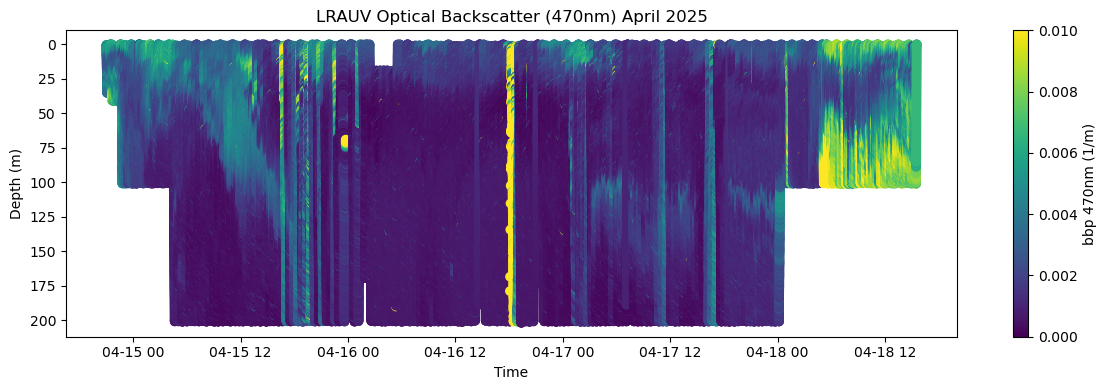

In [31]:

fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    labeled.index,labeled['depth'], c=labeled['particulatebackscatteringcoeff470nm'])
sc.set_clim(0, 0.01)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='bbp 470nm (1/m)')
plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()

In [32]:
df.keys()

Index(['fileName', 'dateStr', 'dateTime'], dtype='object')

In [33]:
labeled.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique', 'distance_km'],
      dtype='object')

How this works and how we need to attempt to fix this issue.
1) The labled data frame contains the vehicle data
2) df contains the file name data (i.e. names for the ROI from the name.parquet file)
This maps the df data into the bin_codes but there is no indication that the planktivore camera was on or off in this data set. 
If the camera was off, then not files but if no valid ROIS, also no files.
Henry also want to compute some sort of volume/time for these.
If we load the camera log data into a dataframe can we use Patrick's trick to get the "bin_codes" below for the log data?
What happens if there is no log data during a period of time?

In [34]:
import sys
sys.path.append('c:/planktivore_code/')
import glob
from decode_pvtr_camlog import DualMagLog
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
#
# file name is something like YYYY-MM-DD-HH-MM-SS.SSSSS.log
mypath='y:/2025-04-14-LRAH-27/'
extension='*.log'
filelist=glob.glob(os.path.join(mypath,'**',extension),recursive=True)
filelist=sorted(filelist)
nf=np.arange(0,len(filelist))
for mf in nf:
    instance=DualMagLog(filelist[mf])
    data=instance.parse_lines()
    tmpdf=instance.export('mytest.csv')
    if mf==0:
        camdf=tmpdf
    else:
        camdf=pd.concat([camdf,tmpdf],ignore_index=True)

2025-12-01 08:20:17.103 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744685885
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744685885
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744685885
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744685885
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744685885
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744685885
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744685886
2025-12-01 08:20:17.119 | INFO     | decode_pvtr_camlog:parse_lines:159 -

time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-04-14 19:58:05.244000
2025-04-14 19:58:05.244000
2025-04-14 19:58:05.589000
2025-04-14 19:58:05.589000
2025-04-14 19:58:05.891000
2025-04-14 19:58:05.891000
2025-04-14 19:58:06.250000
2025-04-14 19:58:06.250000
2025-04-14 19:58:06.525000
2025-04-14 19:58:06.525000
2025-04-14 19:58:06.856000
2025-04-14 19:58:06.856000
2025-04-14 19:58:07.181000
2025-04-14 19:58:07.181000
2025-04-14 19:58:07.507000
2025-04-14 19:58:07.507000
2025-04-14 19:58:07.824000
2025-04-14 19:58:07.824000
2025-04-14 19:58:08.150000
2025-04-14 19:58:08.150000
2025-04-14 19:58:08.466000
2025-04-14 19:58:08.466000
2025-04-14 19:58:08.792000
2025-04-14 19:58:08.792000
2025-04-14 19:58:09.109000
2025-04-14

C:\Users\flbahr\AppData\Local\Temp\ipykernel_19388\3823091105.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  camdf=pd.concat([camdf,tmpdf],ignore_index=True)


time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744695613
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744695613
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744695613
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744695613
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744695613
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744695613
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744695614
2025-12-01 08:20:18.353 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-14 22:40:13.065000
2025-04-14 22:40:13.065000
2025-04-14 22:40:13.416000
2025-04-14 22:40:13.416000
2025-04-14 22:40:13.748000
2025-04-14 22:40:13.748000
2025-04-14 22:40:14.035000
2025-04-14 22:40:14.035000
2025-04-14 22:40:14.351000
2025-04-14 22:40:14.351000
2025-04-14 22:40:14.718000
2025-04-14 22:40:14.718000
2025-04-14 22:40:14.997000
2025-04-14 22:40:14.997000
2025-04-14 22:40:15.323000
2025-04-14 22:40:15.323000
2025-04-14 22:40:15.640000
2025-04-14 22:40:15.640000
2025-04-14 22:40:15.966000
2025-04-14 22:40:15.966000
2025-04-14 22:40:16.293000
2025-04-14 22:40:16.293000
2025-04-14 22:40:16.609000
2025-04-14 22:40:16.609000
2025-04-14 22:40:16.936000
2025-04-14 22:40:16.936000
2025-04-14 22:40:17.251000
2025-04-14 22:40:17.251000
2025-04-14 22:40:17.578000
2025-04-14 22:40:17.578000
2025-04-14 22:40:17.909000
2025-04-14 22:40:17.909000
2025-04-14 22:52:51.621000
2025-04-14 22:52:51.621000
2025-04-14 22:52:51.947000
2025-04-14 22:52:51.947000
2025-04-14 23:02:39.178000
2

2025-12-01 08:20:18.588 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7400, could not find matching low_mag time: 1744698003
2025-12-01 08:20:18.588 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7400, could not find high_mag matching time: 1744698003
2025-12-01 08:20:18.588 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7401, could not find matching low_mag time: 1744698003
2025-12-01 08:20:18.588 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7401, could not find high_mag matching time: 1744698003
2025-12-01 08:20:18.588 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7402, could not find matching low_mag time: 1744698003
2025-12-01 08:20:18.588 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7402, could not find high_mag matching time: 1744698003
2025-12-01 08:20:18.686 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10625, could not find high_mag matching time: 1744699043
2025-12-01 08:20:18.686 | INFO     | decode_pvtr_c

2025-04-14 23:20:03.079000
2025-04-14 23:20:03.079000
2025-04-14 23:20:03.395000
2025-04-14 23:20:03.395000
2025-04-14 23:20:03.720000
2025-04-14 23:20:03.720000
2025-04-14 23:37:23.093000
2025-04-14 23:37:23.418000
2025-04-14 23:37:23.733000
2025-04-14 23:37:24.060000
2025-04-14 23:37:24.386000
2025-04-14 23:37:24.701000
2025-04-14 23:54:36.014000


2025-12-01 08:20:18.789 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13829, could not find high_mag matching time: 1744700076
2025-12-01 08:20:18.790 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13830, could not find high_mag matching time: 1744700076
2025-12-01 08:20:18.791 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13831, could not find high_mag matching time: 1744700076
2025-12-01 08:20:18.791 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13832, could not find matching low_mag time: 1744700077
2025-12-01 08:20:18.792 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13833, could not find matching low_mag time: 1744700077
2025-12-01 08:20:18.793 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13834, could not find matching low_mag time: 1744700077
2025-12-01 08:20:18.890 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17094, could not find matching low_mag time: 1744701129
2025-12-01 08:20:18.891 | INFO     | decode_p

2025-04-14 23:54:36.339000
2025-04-14 23:54:36.664000
2025-04-14 23:54:36.981000
2025-04-14 23:54:37.306000
2025-04-14 23:54:37.632000
2025-04-14 23:54:37.956000
2025-04-15 00:12:09.263000
2025-04-15 00:12:09.263000
2025-04-15 00:12:09.588000
2025-04-15 00:12:09.588000
2025-04-15 00:12:09.914000
2025-04-15 00:12:09.914000


2025-12-01 08:20:18.987 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20353, could not find matching low_mag time: 1744702180
2025-12-01 08:20:18.987 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20353, could not find high_mag matching time: 1744702180
2025-12-01 08:20:18.987 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20354, could not find matching low_mag time: 1744702180
2025-12-01 08:20:18.987 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20354, could not find high_mag matching time: 1744702180
2025-12-01 08:20:18.987 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20355, could not find matching low_mag time: 1744702180
2025-12-01 08:20:18.987 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20355, could not find high_mag matching time: 1744702180
2025-12-01 08:20:19.028 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 21863, could not find matching low_mag time: 1744702667
2025-12-01 08:20:19.036 | INFO     | decode_p

2025-04-15 00:29:40.239000
2025-04-15 00:29:40.239000
2025-04-15 00:29:40.564000
2025-04-15 00:29:40.564000
2025-04-15 00:29:40.888000
2025-04-15 00:29:40.888000
2025-04-15 00:37:47.204000
2025-04-15 00:37:47.204000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744703311
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744703311
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744703311
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744703311
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744703311
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744703311
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744703312
2025-12-01 08:20:20.253 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-15 00:48:31.069000
2025-04-15 00:48:31.069000
2025-04-15 00:48:31.396000
2025-04-15 00:48:31.396000
2025-04-15 00:48:31.712000
2025-04-15 00:48:31.712000
2025-04-15 00:48:32.037000
2025-04-15 00:48:32.037000
2025-04-15 00:48:32.363000
2025-04-15 00:48:32.363000
2025-04-15 00:48:32.678000
2025-04-15 00:48:32.678000
2025-04-15 00:48:33.006000
2025-04-15 00:48:33.006000
2025-04-15 00:48:33.322000
2025-04-15 00:48:33.322000
2025-04-15 00:48:33.650000
2025-04-15 00:48:33.650000
2025-04-15 00:48:33.967000
2025-04-15 00:48:33.967000
2025-04-15 00:48:34.293000
2025-04-15 00:48:34.293000
2025-04-15 00:48:34.610000
2025-04-15 00:48:34.610000
2025-04-15 00:48:34.940000
2025-04-15 00:48:34.940000
2025-04-15 00:48:35.264000
2025-04-15 00:48:35.264000
2025-04-15 00:48:35.582000
2025-04-15 00:48:35.582000
2025-04-15 00:48:35.907000
2025-04-15 00:48:35.907000
2025-04-15 00:53:29.053000
2025-04-15 00:53:29.053000
2025-04-15 00:53:29.368000
2025-04-15 00:53:29.368000
2025-04-15 00:53:29.694000
2

2025-12-01 08:20:20.453 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6674, could not find high_mag matching time: 1744705467
2025-12-01 08:20:20.453 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6675, could not find high_mag matching time: 1744705467
2025-12-01 08:20:20.453 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6676, could not find matching low_mag time: 1744705468
2025-12-01 08:20:20.469 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6677, could not find matching low_mag time: 1744705468
2025-12-01 08:20:20.469 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6678, could not find matching low_mag time: 1744705468
2025-12-01 08:20:20.555 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9950, could not find matching low_mag time: 1744706524
2025-12-01 08:20:20.555 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9950, could not find high_mag matching time: 1744706524
2025-12-01 08:20:20.570 | INFO     | decode_pvtr_cam

2025-04-15 01:24:27.935000
2025-04-15 01:24:28.255000
2025-04-15 01:24:28.580000
2025-04-15 01:24:28.905000
2025-04-15 01:42:04.091000
2025-04-15 01:42:04.091000
2025-04-15 01:42:04.406000
2025-04-15 01:42:04.406000
2025-04-15 01:42:04.731000
2025-04-15 01:42:04.731000


2025-12-01 08:20:20.663 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13116, could not find matching low_mag time: 1744707545
2025-12-01 08:20:20.663 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13116, could not find high_mag matching time: 1744707545
2025-12-01 08:20:20.663 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13117, could not find matching low_mag time: 1744707545
2025-12-01 08:20:20.663 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13117, could not find high_mag matching time: 1744707545
2025-12-01 08:20:20.663 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13118, could not find matching low_mag time: 1744707545
2025-12-01 08:20:20.663 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13118, could not find high_mag matching time: 1744707545
2025-12-01 08:20:20.755 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16465, could not find high_mag matching time: 1744708625
2025-12-01 08:20:20.755 | INFO     | decode_

2025-04-15 01:59:05.072000
2025-04-15 01:59:05.072000
2025-04-15 01:59:05.398000
2025-04-15 01:59:05.398000
2025-04-15 01:59:05.713000
2025-04-15 01:59:05.713000
2025-04-15 02:17:05.078000
2025-04-15 02:17:05.403000
2025-04-15 02:17:05.729000
2025-04-15 02:17:06.044000
2025-04-15 02:17:06.369000
2025-04-15 02:17:06.694000
2025-04-15 02:34:52.194000
2025-04-15 02:34:52.194000


2025-12-01 08:20:20.863 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19775, could not find matching low_mag time: 1744709692
2025-12-01 08:20:20.864 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19775, could not find high_mag matching time: 1744709692
2025-12-01 08:20:20.865 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19776, could not find matching low_mag time: 1744709692
2025-12-01 08:20:20.865 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19776, could not find high_mag matching time: 1744709692
2025-12-01 08:20:20.930 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22003, could not find matching low_mag time: 1744710411
2025-12-01 08:20:20.934 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22003, could not find high_mag matching time: 1744710411
2025-12-01 08:20:20.934 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22004, could not find matching low_mag time: 1744710411
2025-12-01 08:20:20.934 | INFO     | decode_p

2025-04-15 02:34:52.520000
2025-04-15 02:34:52.520000
2025-04-15 02:34:52.845000
2025-04-15 02:34:52.845000
2025-04-15 02:46:51.016000
2025-04-15 02:46:51.016000
2025-04-15 02:46:51.333000
2025-04-15 02:46:51.333000
2025-04-15 02:46:51.660000
2025-04-15 02:46:51.660000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-04-15 02:58:07.270000
2025-04-15 02:58:07.270000
2025-04-15 02:58:07.604000
2025-04-15 02:58:07.604000
2025-04-15 02:58:07.919000
2025-04-15 02:58:07.919000
2025-04-15 02:58:08.241000
2025-04-15 02:58:08.241000
2025-04-15 02:58:08.567000
2025-04-15 02:58:08.567000
2025-04-15 02:58:08.884000
2025-04-15 02:58:08.884000
2025-04-15 02:58:09.207000
2025-04-15 02:58:09.207000
2025-04-15 02:58:09.527000
2025-04-15 02:58:09.527000
2025-04-15 02:58:09.856000
2025-04-15 02:58:09.856000
2025-04-15 02:58:10.179000
2025-04-15 02:58:10.179000
2025-04-15 02:58:10.512000
2025-04-15 02:58:10.512000
2025-04-15 02:58:10.825000
2025

2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744711573
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744711573
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744711573
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744711573
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744711573
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744711573
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744711574
2025-12-01 08:20:21.105 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-15 03:06:13.056000
2025-04-15 03:06:13.056000
2025-04-15 03:06:13.382000
2025-04-15 03:06:13.382000
2025-04-15 03:06:13.701000
2025-04-15 03:06:13.701000
2025-04-15 03:06:14.028000
2025-04-15 03:06:14.028000
2025-04-15 03:06:14.349000
2025-04-15 03:06:14.349000
2025-04-15 03:06:14.668000
2025-04-15 03:06:14.668000
2025-04-15 03:06:14.994000
2025-04-15 03:06:14.994000
2025-04-15 03:06:15.313000
2025-04-15 03:06:15.313000
2025-04-15 03:06:15.634000
2025-04-15 03:06:15.634000
2025-04-15 03:06:15.958000
2025-04-15 03:06:15.958000
2025-04-15 03:06:16.280000
2025-04-15 03:06:16.280000
2025-04-15 03:06:16.604000
2025-04-15 03:06:16.604000
2025-04-15 03:06:16.922000
2025-04-15 03:06:16.922000
2025-04-15 03:06:17.251000
2025-04-15 03:06:17.251000
2025-04-15 03:06:17.567000
2025-04-15 03:06:17.567000
2025-04-15 03:06:17.894000
2025-04-15 03:06:17.894000
2025-04-15 03:10:46.210000
2025-04-15 03:10:46.210000
2025-04-15 03:10:46.535000
2025-04-15 03:10:46.535000
2025-04-15 03:10:46.850000
2

2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744716219
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744716219
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744716219
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744716219
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744716219
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744716219
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744716220
2025-12-01 08:20:27.259 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-15 04:23:39.039000
2025-04-15 04:23:39.039000
2025-04-15 04:23:39.354000
2025-04-15 04:23:39.354000
2025-04-15 04:23:39.679000
2025-04-15 04:23:39.679000
2025-04-15 04:23:40.004000
2025-04-15 04:23:40.004000
2025-04-15 04:23:40.329000
2025-04-15 04:23:40.329000
2025-04-15 04:23:40.645000
2025-04-15 04:23:40.645000
2025-04-15 04:23:40.972000
2025-04-15 04:23:40.972000
2025-04-15 04:23:41.297000
2025-04-15 04:23:41.297000
2025-04-15 04:23:41.612000
2025-04-15 04:23:41.612000
2025-04-15 04:23:41.935000
2025-04-15 04:23:41.935000
2025-04-15 04:23:42.256000
2025-04-15 04:23:42.256000
2025-04-15 04:23:42.581000
2025-04-15 04:23:42.581000
2025-04-15 04:23:42.907000
2025-04-15 04:23:42.907000
2025-04-15 04:23:43.223000
2025-04-15 04:23:43.223000
2025-04-15 04:23:43.552000
2025-04-15 04:23:43.552000
2025-04-15 04:23:43.869000
2025-04-15 04:23:43.869000


2025-12-01 08:20:27.510 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1932, could not find matching low_mag time: 1744716842
2025-12-01 08:20:27.511 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1932, could not find high_mag matching time: 1744716842
2025-12-01 08:20:27.512 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1933, could not find matching low_mag time: 1744716842
2025-12-01 08:20:27.512 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1933, could not find high_mag matching time: 1744716842
2025-12-01 08:20:27.627 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3002, could not find matching low_mag time: 1744717191
2025-12-01 08:20:27.627 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3002, could not find high_mag matching time: 1744717191
2025-12-01 08:20:27.627 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3003, could not find matching low_mag time: 1744717191
2025-12-01 08:20:27.627 | INFO     | decode_pvtr_cam

2025-04-15 04:34:02.070000
2025-04-15 04:34:02.070000
2025-04-15 04:34:02.395000
2025-04-15 04:34:02.395000
2025-04-15 04:39:51.070000
2025-04-15 04:39:51.070000
2025-04-15 04:39:51.394000
2025-04-15 04:39:51.394000
2025-04-15 04:39:51.710000
2025-04-15 04:39:51.710000


2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6261, could not find high_mag matching time: 1744718242
2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6262, could not find high_mag matching time: 1744718242
2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6263, could not find high_mag matching time: 1744718242
2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6264, could not find matching low_mag time: 1744718243
2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6265, could not find matching low_mag time: 1744718243
2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6266, could not find matching low_mag time: 1744718243
2025-12-01 08:20:27.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6267, could not find matching low_mag time: 1744718243


2025-04-15 04:57:22.045000
2025-04-15 04:57:22.371000
2025-04-15 04:57:22.696000
2025-04-15 04:57:23.021000
2025-04-15 04:57:23.336000
2025-04-15 04:57:23.662000
2025-04-15 04:57:23.988000


2025-12-01 08:20:28.377 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9589, could not find high_mag matching time: 1744719315
2025-12-01 08:20:28.377 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9590, could not find high_mag matching time: 1744719315
2025-12-01 08:20:28.377 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9591, could not find high_mag matching time: 1744719315
2025-12-01 08:20:28.377 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9592, could not find matching low_mag time: 1744719316
2025-12-01 08:20:28.377 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9593, could not find matching low_mag time: 1744719316
2025-12-01 08:20:28.377 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9594, could not find matching low_mag time: 1744719316


2025-04-15 05:15:15.296000
2025-04-15 05:15:15.611000
2025-04-15 05:15:15.938000
2025-04-15 05:15:16.265000
2025-04-15 05:15:16.581000
2025-04-15 05:15:16.906000


2025-12-01 08:20:28.769 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12956, could not find matching low_mag time: 1744720401
2025-12-01 08:20:28.769 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12956, could not find high_mag matching time: 1744720401
2025-12-01 08:20:28.769 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12957, could not find matching low_mag time: 1744720401
2025-12-01 08:20:28.769 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12957, could not find high_mag matching time: 1744720401
2025-12-01 08:20:28.769 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12958, could not find matching low_mag time: 1744720401
2025-12-01 08:20:28.769 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12958, could not find high_mag matching time: 1744720401


2025-04-15 05:33:21.105000
2025-04-15 05:33:21.105000
2025-04-15 05:33:21.421000
2025-04-15 05:33:21.421000
2025-04-15 05:33:21.747000
2025-04-15 05:33:21.747000


2025-12-01 08:20:29.161 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16423, could not find high_mag matching time: 1744721519
2025-12-01 08:20:29.161 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16424, could not find high_mag matching time: 1744721519
2025-12-01 08:20:29.161 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16425, could not find high_mag matching time: 1744721519
2025-12-01 08:20:29.161 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16426, could not find matching low_mag time: 1744721520
2025-12-01 08:20:29.161 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16427, could not find matching low_mag time: 1744721520
2025-12-01 08:20:29.161 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16428, could not find matching low_mag time: 1744721520


2025-04-15 05:51:59.157000
2025-04-15 05:51:59.482000
2025-04-15 05:51:59.807000
2025-04-15 05:52:00.123000
2025-04-15 05:52:00.448000
2025-04-15 05:52:00.773000


2025-12-01 08:20:29.549 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19831, could not find matching low_mag time: 1744722618
2025-12-01 08:20:29.549 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19831, could not find high_mag matching time: 1744722618
2025-12-01 08:20:29.549 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19832, could not find matching low_mag time: 1744722618
2025-12-01 08:20:29.549 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19832, could not find high_mag matching time: 1744722618
2025-12-01 08:20:29.549 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19833, could not find matching low_mag time: 1744722618
2025-12-01 08:20:29.549 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19833, could not find high_mag matching time: 1744722618


2025-04-15 06:10:18.191000
2025-04-15 06:10:18.191000
2025-04-15 06:10:18.517000
2025-04-15 06:10:18.517000
2025-04-15 06:10:18.832000
2025-04-15 06:10:18.832000


2025-12-01 08:20:29.928 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23152, could not find matching low_mag time: 1744723689
2025-12-01 08:20:29.928 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23152, could not find high_mag matching time: 1744723689
2025-12-01 08:20:29.928 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23153, could not find matching low_mag time: 1744723689
2025-12-01 08:20:29.928 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23153, could not find high_mag matching time: 1744723689
2025-12-01 08:20:29.928 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23154, could not find matching low_mag time: 1744723689
2025-12-01 08:20:29.928 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23154, could not find high_mag matching time: 1744723689


2025-04-15 06:28:09.175000
2025-04-15 06:28:09.175000
2025-04-15 06:28:09.490000
2025-04-15 06:28:09.490000
2025-04-15 06:28:09.820000
2025-04-15 06:28:09.820000


2025-12-01 08:20:30.312 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26535, could not find high_mag matching time: 1744724780
2025-12-01 08:20:30.312 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26536, could not find high_mag matching time: 1744724780
2025-12-01 08:20:30.312 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26537, could not find high_mag matching time: 1744724780
2025-12-01 08:20:30.312 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26538, could not find matching low_mag time: 1744724781
2025-12-01 08:20:30.312 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26539, could not find matching low_mag time: 1744724781
2025-12-01 08:20:30.312 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26540, could not find matching low_mag time: 1744724781


2025-04-15 06:46:20.139000
2025-04-15 06:46:20.454000
2025-04-15 06:46:20.780000
2025-04-15 06:46:21.105000
2025-04-15 06:46:21.420000
2025-04-15 06:46:21.745000


2025-12-01 08:20:30.696 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29915, could not find matching low_mag time: 1744725870
2025-12-01 08:20:30.696 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29915, could not find high_mag matching time: 1744725870
2025-12-01 08:20:30.696 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29916, could not find matching low_mag time: 1744725870
2025-12-01 08:20:30.696 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29916, could not find high_mag matching time: 1744725870
2025-12-01 08:20:30.696 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29917, could not find matching low_mag time: 1744725870
2025-12-01 08:20:30.696 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29917, could not find high_mag matching time: 1744725870


2025-04-15 07:04:30.141000
2025-04-15 07:04:30.141000
2025-04-15 07:04:30.467000
2025-04-15 07:04:30.467000
2025-04-15 07:04:30.782000
2025-04-15 07:04:30.782000


2025-12-01 08:20:31.082 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33301, could not find matching low_mag time: 1744726962
2025-12-01 08:20:31.082 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33301, could not find high_mag matching time: 1744726962
2025-12-01 08:20:31.082 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33302, could not find matching low_mag time: 1744726962
2025-12-01 08:20:31.082 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33302, could not find high_mag matching time: 1744726962
2025-12-01 08:20:31.082 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33303, could not find matching low_mag time: 1744726962
2025-12-01 08:20:31.082 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33303, could not find high_mag matching time: 1744726962


2025-04-15 07:22:42.076000
2025-04-15 07:22:42.076000
2025-04-15 07:22:42.402000
2025-04-15 07:22:42.402000
2025-04-15 07:22:42.727000
2025-04-15 07:22:42.727000


2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36687, could not find high_mag matching time: 1744728054
2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36688, could not find high_mag matching time: 1744728054
2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36689, could not find high_mag matching time: 1744728054
2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36690, could not find high_mag matching time: 1744728054
2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36691, could not find matching low_mag time: 1744728055
2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36692, could not find matching low_mag time: 1744728055
2025-12-01 08:20:31.462 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36693, could not find matching low_mag time: 1744728055


2025-04-15 07:40:54.015000
2025-04-15 07:40:54.340000
2025-04-15 07:40:54.664000
2025-04-15 07:40:54.980000
2025-04-15 07:40:55.305000
2025-04-15 07:40:55.630000
2025-04-15 07:40:55.945000


2025-12-01 08:20:31.830 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39891, could not find high_mag matching time: 1744729087
2025-12-01 08:20:31.830 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39892, could not find high_mag matching time: 1744729087
2025-12-01 08:20:31.830 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39893, could not find high_mag matching time: 1744729087
2025-12-01 08:20:31.830 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39894, could not find matching low_mag time: 1744729088
2025-12-01 08:20:31.830 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39895, could not find matching low_mag time: 1744729088
2025-12-01 08:20:31.830 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39896, could not find matching low_mag time: 1744729088


2025-04-15 07:58:07.260000
2025-04-15 07:58:07.586000
2025-04-15 07:58:07.913000
2025-04-15 07:58:08.229000
2025-04-15 07:58:08.554000
2025-04-15 07:58:08.880000


2025-12-01 08:20:32.214 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43227, could not find matching low_mag time: 1744730163
2025-12-01 08:20:32.214 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43227, could not find high_mag matching time: 1744730163
2025-12-01 08:20:32.214 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43228, could not find matching low_mag time: 1744730163
2025-12-01 08:20:32.214 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43228, could not find high_mag matching time: 1744730163
2025-12-01 08:20:32.214 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43229, could not find matching low_mag time: 1744730163
2025-12-01 08:20:32.214 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43229, could not find high_mag matching time: 1744730163


2025-04-15 08:16:03.082000
2025-04-15 08:16:03.082000
2025-04-15 08:16:03.407000
2025-04-15 08:16:03.407000
2025-04-15 08:16:03.732000
2025-04-15 08:16:03.732000


2025-12-01 08:20:32.597 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46613, could not find matching low_mag time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46613, could not find high_mag matching time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46614, could not find matching low_mag time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46614, could not find high_mag matching time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46615, could not find matching low_mag time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46615, could not find high_mag matching time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46616, could not find matching low_mag time: 1744731255
2025-12-01 08:20:32.598 | INFO     | decode_p

2025-04-15 08:34:15.021000
2025-04-15 08:34:15.021000
2025-04-15 08:34:15.346000
2025-04-15 08:34:15.346000
2025-04-15 08:34:15.671000
2025-04-15 08:34:15.671000
2025-04-15 08:34:15.986000
2025-04-15 08:34:15.986000


2025-12-01 08:20:32.965 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49925, could not find matching low_mag time: 1744732323
2025-12-01 08:20:32.965 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49925, could not find high_mag matching time: 1744732323
2025-12-01 08:20:32.965 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49926, could not find matching low_mag time: 1744732323
2025-12-01 08:20:32.965 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49926, could not find high_mag matching time: 1744732323
2025-12-01 08:20:32.965 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49927, could not find matching low_mag time: 1744732323
2025-12-01 08:20:32.965 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49927, could not find high_mag matching time: 1744732323


2025-04-15 08:52:03.095000
2025-04-15 08:52:03.095000
2025-04-15 08:52:03.410000
2025-04-15 08:52:03.410000
2025-04-15 08:52:03.736000
2025-04-15 08:52:03.736000


2025-12-01 08:20:33.332 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53197, could not find high_mag matching time: 1744733378
2025-12-01 08:20:33.332 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53198, could not find high_mag matching time: 1744733378
2025-12-01 08:20:33.348 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53199, could not find high_mag matching time: 1744733378
2025-12-01 08:20:33.348 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53200, could not find matching low_mag time: 1744733379
2025-12-01 08:20:33.348 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53201, could not find matching low_mag time: 1744733379
2025-12-01 08:20:33.348 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53202, could not find matching low_mag time: 1744733379


2025-04-15 09:09:38.266000
2025-04-15 09:09:38.580000
2025-04-15 09:09:38.905000
2025-04-15 09:09:39.230000
2025-04-15 09:09:39.556000
2025-04-15 09:09:39.871000


2025-12-01 08:20:33.715 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56595, could not find matching low_mag time: 1744734474
2025-12-01 08:20:33.731 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56595, could not find high_mag matching time: 1744734474
2025-12-01 08:20:33.733 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56596, could not find matching low_mag time: 1744734474
2025-12-01 08:20:33.733 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56596, could not find high_mag matching time: 1744734474
2025-12-01 08:20:33.733 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56597, could not find matching low_mag time: 1744734474
2025-12-01 08:20:33.733 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56597, could not find high_mag matching time: 1744734474


2025-04-15 09:27:54.074000
2025-04-15 09:27:54.074000
2025-04-15 09:27:54.390000
2025-04-15 09:27:54.390000
2025-04-15 09:27:54.716000
2025-04-15 09:27:54.716000


2025-12-01 08:20:34.099 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59929, could not find matching low_mag time: 1744735549
2025-12-01 08:20:34.099 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59929, could not find high_mag matching time: 1744735549
2025-12-01 08:20:34.099 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59930, could not find matching low_mag time: 1744735549
2025-12-01 08:20:34.099 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59930, could not find high_mag matching time: 1744735549
2025-12-01 08:20:34.099 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59931, could not find matching low_mag time: 1744735549
2025-12-01 08:20:34.099 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59931, could not find high_mag matching time: 1744735549


2025-04-15 09:45:49.247000
2025-04-15 09:45:49.247000
2025-04-15 09:45:49.573000
2025-04-15 09:45:49.573000
2025-04-15 09:45:49.898000
2025-04-15 09:45:49.898000


2025-12-01 08:20:34.484 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63340, could not find matching low_mag time: 1744736649
2025-12-01 08:20:34.499 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63340, could not find high_mag matching time: 1744736649
2025-12-01 08:20:34.499 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63341, could not find matching low_mag time: 1744736649
2025-12-01 08:20:34.499 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63341, could not find high_mag matching time: 1744736649
2025-12-01 08:20:34.499 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63342, could not find matching low_mag time: 1744736649
2025-12-01 08:20:34.499 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63342, could not find high_mag matching time: 1744736649


2025-04-15 10:04:09.250000
2025-04-15 10:04:09.250000
2025-04-15 10:04:09.576000
2025-04-15 10:04:09.576000
2025-04-15 10:04:09.891000
2025-04-15 10:04:09.891000


2025-12-01 08:20:34.884 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66698, could not find matching low_mag time: 1744737732
2025-12-01 08:20:34.884 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66698, could not find high_mag matching time: 1744737732
2025-12-01 08:20:34.884 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66699, could not find matching low_mag time: 1744737732
2025-12-01 08:20:34.884 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66699, could not find high_mag matching time: 1744737732
2025-12-01 08:20:34.884 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66700, could not find matching low_mag time: 1744737732
2025-12-01 08:20:34.884 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66700, could not find high_mag matching time: 1744737732


2025-04-15 10:22:12.159000
2025-04-15 10:22:12.159000
2025-04-15 10:22:12.485000
2025-04-15 10:22:12.485000
2025-04-15 10:22:12.810000
2025-04-15 10:22:12.810000


2025-12-01 08:20:35.261 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70000, could not find matching low_mag time: 1744738797
2025-12-01 08:20:35.261 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 70000, could not find high_mag matching time: 1744738797
2025-12-01 08:20:35.261 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70001, could not find matching low_mag time: 1744738797
2025-12-01 08:20:35.261 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 70001, could not find high_mag matching time: 1744738797
2025-12-01 08:20:35.261 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70002, could not find matching low_mag time: 1744738797
2025-12-01 08:20:35.261 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 70002, could not find high_mag matching time: 1744738797
2025-12-01 08:20:35.266 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 70003, could not find matching low_mag time: 1744738797
2025-12-01 08:20:35.266 | INFO     | decode_p

2025-04-15 10:39:57.008000
2025-04-15 10:39:57.008000
2025-04-15 10:39:57.333000
2025-04-15 10:39:57.333000
2025-04-15 10:39:57.658000
2025-04-15 10:39:57.658000
2025-04-15 10:39:57.973000
2025-04-15 10:39:57.973000


2025-12-01 08:20:35.645 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73359, could not find high_mag matching time: 1744739880
2025-12-01 08:20:35.645 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73360, could not find high_mag matching time: 1744739880
2025-12-01 08:20:35.645 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73361, could not find high_mag matching time: 1744739880
2025-12-01 08:20:35.645 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73362, could not find matching low_mag time: 1744739881
2025-12-01 08:20:35.649 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73363, could not find matching low_mag time: 1744739881
2025-12-01 08:20:35.649 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73364, could not find matching low_mag time: 1744739881


2025-04-15 10:58:00.244000
2025-04-15 10:58:00.569000
2025-04-15 10:58:00.884000
2025-04-15 10:58:01.209000
2025-04-15 10:58:01.535000
2025-04-15 10:58:01.860000


2025-12-01 08:20:36.019 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76748, could not find matching low_mag time: 1744740973
2025-12-01 08:20:36.019 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76748, could not find high_mag matching time: 1744740973
2025-12-01 08:20:36.019 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76749, could not find matching low_mag time: 1744740973
2025-12-01 08:20:36.019 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76749, could not find high_mag matching time: 1744740973
2025-12-01 08:20:36.033 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76750, could not find matching low_mag time: 1744740973
2025-12-01 08:20:36.033 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76750, could not find high_mag matching time: 1744740973


2025-04-15 11:16:13.160000
2025-04-15 11:16:13.160000
2025-04-15 11:16:13.475000
2025-04-15 11:16:13.475000
2025-04-15 11:16:13.800000
2025-04-15 11:16:13.800000


2025-12-01 08:20:36.416 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80103, could not find matching low_mag time: 1744742055
2025-12-01 08:20:36.416 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80103, could not find high_mag matching time: 1744742055
2025-12-01 08:20:36.416 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80104, could not find matching low_mag time: 1744742055
2025-12-01 08:20:36.416 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80104, could not find high_mag matching time: 1744742055
2025-12-01 08:20:36.416 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 80105, could not find matching low_mag time: 1744742055
2025-12-01 08:20:36.416 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 80105, could not find high_mag matching time: 1744742055


2025-04-15 11:34:15.103000
2025-04-15 11:34:15.103000
2025-04-15 11:34:15.419000
2025-04-15 11:34:15.419000
2025-04-15 11:34:15.745000
2025-04-15 11:34:15.745000


2025-12-01 08:20:36.787 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83384, could not find matching low_mag time: 1744743113
2025-12-01 08:20:36.787 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83384, could not find high_mag matching time: 1744743113
2025-12-01 08:20:36.787 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83385, could not find matching low_mag time: 1744743113
2025-12-01 08:20:36.787 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83385, could not find high_mag matching time: 1744743113
2025-12-01 08:20:36.787 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83386, could not find matching low_mag time: 1744743113
2025-12-01 08:20:36.787 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83386, could not find high_mag matching time: 1744743113


2025-04-15 11:51:53.175000
2025-04-15 11:51:53.175000
2025-04-15 11:51:53.490000
2025-04-15 11:51:53.490000
2025-04-15 11:51:53.815000
2025-04-15 11:51:53.815000


2025-12-01 08:20:37.176 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86792, could not find high_mag matching time: 1744744212
2025-12-01 08:20:37.176 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86793, could not find high_mag matching time: 1744744212
2025-12-01 08:20:37.176 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86794, could not find high_mag matching time: 1744744212
2025-12-01 08:20:37.176 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86795, could not find matching low_mag time: 1744744213
2025-12-01 08:20:37.176 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86796, could not find matching low_mag time: 1744744213
2025-12-01 08:20:37.176 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86797, could not find matching low_mag time: 1744744213


2025-04-15 12:10:12.205000
2025-04-15 12:10:12.531000
2025-04-15 12:10:12.847000
2025-04-15 12:10:13.174000
2025-04-15 12:10:13.499000
2025-04-15 12:10:13.816000


2025-12-01 08:20:37.558 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90169, could not find matching low_mag time: 1744745301
2025-12-01 08:20:37.558 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90169, could not find high_mag matching time: 1744745301
2025-12-01 08:20:37.558 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90170, could not find matching low_mag time: 1744745301
2025-12-01 08:20:37.558 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90170, could not find high_mag matching time: 1744745301
2025-12-01 08:20:37.558 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90171, could not find matching low_mag time: 1744745301
2025-12-01 08:20:37.558 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90171, could not find high_mag matching time: 1744745301


2025-04-15 12:28:21.246000
2025-04-15 12:28:21.246000
2025-04-15 12:28:21.571000
2025-04-15 12:28:21.571000
2025-04-15 12:28:21.886000
2025-04-15 12:28:21.886000


2025-12-01 08:20:37.933 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93474, could not find matching low_mag time: 1744746367
2025-12-01 08:20:37.933 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93474, could not find high_mag matching time: 1744746367
2025-12-01 08:20:37.933 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93475, could not find matching low_mag time: 1744746367
2025-12-01 08:20:37.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93475, could not find high_mag matching time: 1744746367
2025-12-01 08:20:37.935 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 93476, could not find matching low_mag time: 1744746367
2025-12-01 08:20:37.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 93476, could not find high_mag matching time: 1744746367


2025-04-15 12:46:07.064000
2025-04-15 12:46:07.064000
2025-04-15 12:46:07.379000
2025-04-15 12:46:07.379000
2025-04-15 12:46:07.704000
2025-04-15 12:46:07.704000


2025-12-01 08:20:38.318 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96861, could not find matching low_mag time: 1744747459
2025-12-01 08:20:38.318 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96861, could not find high_mag matching time: 1744747459
2025-12-01 08:20:38.318 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96862, could not find matching low_mag time: 1744747459
2025-12-01 08:20:38.318 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96862, could not find high_mag matching time: 1744747459
2025-12-01 08:20:38.318 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96863, could not find matching low_mag time: 1744747459
2025-12-01 08:20:38.318 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96863, could not find high_mag matching time: 1744747459


2025-04-15 13:04:19.320000
2025-04-15 13:04:19.320000
2025-04-15 13:04:19.646000
2025-04-15 13:04:19.646000
2025-04-15 13:04:19.961000
2025-04-15 13:04:19.961000


2025-12-01 08:20:38.686 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100203, could not find matching low_mag time: 1744748537
2025-12-01 08:20:38.686 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100203, could not find high_mag matching time: 1744748537
2025-12-01 08:20:38.702 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100204, could not find matching low_mag time: 1744748537
2025-12-01 08:20:38.703 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100204, could not find high_mag matching time: 1744748537
2025-12-01 08:20:38.703 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 100205, could not find matching low_mag time: 1744748537
2025-12-01 08:20:38.703 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 100205, could not find high_mag matching time: 1744748537


2025-04-15 13:22:17.069000
2025-04-15 13:22:17.069000
2025-04-15 13:22:17.394000
2025-04-15 13:22:17.394000
2025-04-15 13:22:17.720000
2025-04-15 13:22:17.720000


2025-12-01 08:20:39.085 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103571, could not find high_mag matching time: 1744749623
2025-12-01 08:20:39.085 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103572, could not find high_mag matching time: 1744749623
2025-12-01 08:20:39.085 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 103573, could not find high_mag matching time: 1744749623
2025-12-01 08:20:39.085 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103574, could not find matching low_mag time: 1744749624
2025-12-01 08:20:39.085 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103575, could not find matching low_mag time: 1744749624
2025-12-01 08:20:39.085 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 103576, could not find matching low_mag time: 1744749624


2025-04-15 13:40:23.215000
2025-04-15 13:40:23.530000
2025-04-15 13:40:23.855000
2025-04-15 13:40:24.180000
2025-04-15 13:40:24.495000
2025-04-15 13:40:24.820000


2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107000, could not find high_mag matching time: 1744750729
2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107001, could not find high_mag matching time: 1744750729
2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107002, could not find high_mag matching time: 1744750729
2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 107003, could not find high_mag matching time: 1744750729
2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107004, could not find matching low_mag time: 1744750730
2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107005, could not find matching low_mag time: 1744750730
2025-12-01 08:20:39.470 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 107006, could not find matching low_mag time: 1744750730


2025-04-15 13:58:49.021000
2025-04-15 13:58:49.337000
2025-04-15 13:58:49.663000
2025-04-15 13:58:49.987000
2025-04-15 13:58:50.302000
2025-04-15 13:58:50.628000
2025-04-15 13:58:50.953000


2025-12-01 08:20:39.837 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110275, could not find matching low_mag time: 1744751785
2025-12-01 08:20:39.837 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110275, could not find high_mag matching time: 1744751785
2025-12-01 08:20:39.837 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110276, could not find matching low_mag time: 1744751785
2025-12-01 08:20:39.837 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110276, could not find high_mag matching time: 1744751785
2025-12-01 08:20:39.837 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 110277, could not find matching low_mag time: 1744751785
2025-12-01 08:20:39.853 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 110277, could not find high_mag matching time: 1744751785
2025-12-01 08:20:39.961 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 111308, could not find matching low_mag time: 1744752118
2025-12-01 08:20:39.961 | INFO     | d

2025-04-15 14:16:25.154000
2025-04-15 14:16:25.154000
2025-04-15 14:16:25.479000
2025-04-15 14:16:25.479000
2025-04-15 14:16:25.805000
2025-04-15 14:16:25.805000
2025-04-15 14:21:58.290000
2025-04-15 14:21:58.290000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744752279
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744752279
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744752279
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744752279
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744752279
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744752279
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744752280
2025-12-01 08:20:40.079 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-15 14:24:39.209000
2025-04-15 14:24:39.209000
2025-04-15 14:24:39.528000
2025-04-15 14:24:39.528000
2025-04-15 14:24:39.850000
2025-04-15 14:24:39.850000
2025-04-15 14:24:40.178000
2025-04-15 14:24:40.178000
2025-04-15 14:24:40.513000
2025-04-15 14:24:40.513000
2025-04-15 14:24:40.831000
2025-04-15 14:24:40.831000
2025-04-15 14:24:41.152000
2025-04-15 14:24:41.152000
2025-04-15 14:24:41.475000
2025-04-15 14:24:41.475000
2025-04-15 14:24:41.793000
2025-04-15 14:24:41.793000
2025-04-15 14:24:42.116000
2025-04-15 14:24:42.116000
2025-04-15 14:24:42.463000
2025-04-15 14:24:42.463000
2025-04-15 14:24:42.767000
2025-04-15 14:24:42.767000
2025-04-15 14:24:43.087000
2025-04-15 14:24:43.087000
2025-04-15 14:24:43.408000
2025-04-15 14:24:43.408000
2025-04-15 14:24:43.728000
2025-04-15 14:24:43.728000
2025-04-15 14:24:44.049000
2025-04-15 14:24:44.049000
2025-04-15 14:24:44.373000
2025-04-15 14:24:44.373000
2025-04-15 14:24:44.698000
2025-04-15 14:24:44.698000
time data 'date       time  

2025-12-01 08:20:43.490 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744752749
2025-12-01 08:20:43.490 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744752749
2025-12-01 08:20:43.490 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744752749
2025-12-01 08:20:43.490 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744752749
2025-12-01 08:20:43.490 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744752749
2025-12-01 08:20:43.506 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744752749
2025-12-01 08:20:43.506 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744752750
2025-12-01 08:20:43.506 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-15 14:32:29.195000
2025-04-15 14:32:29.195000
2025-04-15 14:32:29.521000
2025-04-15 14:32:29.521000
2025-04-15 14:32:29.836000
2025-04-15 14:32:29.836000
2025-04-15 14:32:30.163000
2025-04-15 14:32:30.163000
2025-04-15 14:32:30.479000
2025-04-15 14:32:30.479000
2025-04-15 14:32:30.804000
2025-04-15 14:32:30.804000
2025-04-15 14:32:31.130000
2025-04-15 14:32:31.130000
2025-04-15 14:32:31.445000
2025-04-15 14:32:31.445000
2025-04-15 14:32:31.770000
2025-04-15 14:32:31.770000
2025-04-15 14:32:32.095000
2025-04-15 14:32:32.095000
2025-04-15 14:32:32.420000
2025-04-15 14:32:32.420000
2025-04-15 14:32:32.734000
2025-04-15 14:32:32.734000
2025-04-15 14:32:33.056000
2025-04-15 14:32:33.056000
2025-04-15 14:32:33.389000
2025-04-15 14:32:33.389000
2025-04-15 14:32:33.754000
2025-04-15 14:32:33.754000
2025-04-15 14:46:31.171000


2025-12-01 08:20:43.690 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2599, could not find high_mag matching time: 1744753591
2025-12-01 08:20:43.690 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2600, could not find high_mag matching time: 1744753591
2025-12-01 08:20:43.690 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2601, could not find matching low_mag time: 1744753592
2025-12-01 08:20:43.690 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2602, could not find matching low_mag time: 1744753592
2025-12-01 08:20:43.690 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2603, could not find matching low_mag time: 1744753592


2025-04-15 14:46:31.496000
2025-04-15 14:46:31.822000
2025-04-15 14:46:32.137000
2025-04-15 14:46:32.463000
2025-04-15 14:46:32.789000


2025-12-01 08:20:43.910 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6090, could not find high_mag matching time: 1744754717
2025-12-01 08:20:43.922 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6091, could not find high_mag matching time: 1744754717
2025-12-01 08:20:43.922 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6092, could not find high_mag matching time: 1744754717
2025-12-01 08:20:43.922 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6093, could not find matching low_mag time: 1744754718
2025-12-01 08:20:43.924 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6094, could not find matching low_mag time: 1744754718
2025-12-01 08:20:43.925 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6095, could not find matching low_mag time: 1744754718


2025-04-15 15:05:17.296000
2025-04-15 15:05:17.621000
2025-04-15 15:05:17.937000
2025-04-15 15:05:18.262000
2025-04-15 15:05:18.587000
2025-04-15 15:05:18.903000


2025-12-01 08:20:44.145 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9556, could not find matching low_mag time: 1744755835
2025-12-01 08:20:44.145 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9556, could not find high_mag matching time: 1744755835
2025-12-01 08:20:44.145 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9557, could not find matching low_mag time: 1744755835
2025-12-01 08:20:44.145 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9557, could not find high_mag matching time: 1744755835
2025-12-01 08:20:44.145 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9558, could not find matching low_mag time: 1744755835
2025-12-01 08:20:44.145 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9558, could not find high_mag matching time: 1744755835


2025-04-15 15:23:55.039000
2025-04-15 15:23:55.039000
2025-04-15 15:23:55.355000
2025-04-15 15:23:55.355000
2025-04-15 15:23:55.680000
2025-04-15 15:23:55.680000


2025-12-01 08:20:44.373 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12961, could not find matching low_mag time: 1744756933
2025-12-01 08:20:44.376 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12961, could not find high_mag matching time: 1744756933
2025-12-01 08:20:44.377 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12962, could not find matching low_mag time: 1744756933
2025-12-01 08:20:44.377 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12962, could not find high_mag matching time: 1744756933
2025-12-01 08:20:44.378 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12963, could not find matching low_mag time: 1744756933
2025-12-01 08:20:44.379 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12963, could not find high_mag matching time: 1744756933


2025-04-15 15:42:13.104000
2025-04-15 15:42:13.104000
2025-04-15 15:42:13.419000
2025-04-15 15:42:13.419000
2025-04-15 15:42:13.745000
2025-04-15 15:42:13.745000


2025-12-01 08:20:44.591 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16409, could not find matching low_mag time: 1744758045
2025-12-01 08:20:44.591 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16409, could not find high_mag matching time: 1744758045
2025-12-01 08:20:44.591 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16410, could not find matching low_mag time: 1744758045
2025-12-01 08:20:44.591 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16410, could not find high_mag matching time: 1744758045
2025-12-01 08:20:44.591 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16411, could not find matching low_mag time: 1744758045
2025-12-01 08:20:44.607 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16411, could not find high_mag matching time: 1744758045


2025-04-15 16:00:45.032000
2025-04-15 16:00:45.032000
2025-04-15 16:00:45.350000
2025-04-15 16:00:45.350000
2025-04-15 16:00:45.676000
2025-04-15 16:00:45.676000


2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19879, could not find high_mag matching time: 1744759164
2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19880, could not find high_mag matching time: 1744759164
2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19881, could not find high_mag matching time: 1744759164
2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19882, could not find matching low_mag time: 1744759165
2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19883, could not find matching low_mag time: 1744759165
2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19884, could not find matching low_mag time: 1744759165
2025-12-01 08:20:44.829 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19885, could not find matching low_mag time: 1744759165


2025-04-15 16:19:24.059000
2025-04-15 16:19:24.385000
2025-04-15 16:19:24.700000
2025-04-15 16:19:25.025000
2025-04-15 16:19:25.351000
2025-04-15 16:19:25.666000
2025-04-15 16:19:25.991000


2025-12-01 08:20:45.063 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23368, could not find high_mag matching time: 1744760289
2025-12-01 08:20:45.063 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23369, could not find high_mag matching time: 1744760289
2025-12-01 08:20:45.063 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23370, could not find high_mag matching time: 1744760289
2025-12-01 08:20:45.063 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23371, could not find matching low_mag time: 1744760290
2025-12-01 08:20:45.063 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23372, could not find matching low_mag time: 1744760290
2025-12-01 08:20:45.063 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23373, could not find matching low_mag time: 1744760290


2025-04-15 16:38:09.221000
2025-04-15 16:38:09.536000
2025-04-15 16:38:09.862000
2025-04-15 16:38:10.188000
2025-04-15 16:38:10.503000
2025-04-15 16:38:10.829000


2025-12-01 08:20:45.293 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26779, could not find high_mag matching time: 1744761389
2025-12-01 08:20:45.294 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26780, could not find high_mag matching time: 1744761389
2025-12-01 08:20:45.294 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26781, could not find high_mag matching time: 1744761389
2025-12-01 08:20:45.296 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26782, could not find matching low_mag time: 1744761390
2025-12-01 08:20:45.297 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26783, could not find matching low_mag time: 1744761390
2025-12-01 08:20:45.298 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26784, could not find matching low_mag time: 1744761390


2025-04-15 16:56:29.217000
2025-04-15 16:56:29.543000
2025-04-15 16:56:29.858000
2025-04-15 16:56:30.183000
2025-04-15 16:56:30.508000
2025-04-15 16:56:30.823000


2025-12-01 08:20:45.513 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30224, could not find high_mag matching time: 1744762500
2025-12-01 08:20:45.513 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30225, could not find high_mag matching time: 1744762500
2025-12-01 08:20:45.513 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30226, could not find high_mag matching time: 1744762500
2025-12-01 08:20:45.513 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30227, could not find matching low_mag time: 1744762501
2025-12-01 08:20:45.513 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30228, could not find matching low_mag time: 1744762501
2025-12-01 08:20:45.525 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30229, could not find matching low_mag time: 1744762501


2025-04-15 17:15:00.181000
2025-04-15 17:15:00.496000
2025-04-15 17:15:00.824000
2025-04-15 17:15:01.150000
2025-04-15 17:15:01.466000
2025-04-15 17:15:01.791000


2025-12-01 08:20:45.749 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33638, could not find matching low_mag time: 1744763601
2025-12-01 08:20:45.749 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33638, could not find high_mag matching time: 1744763601
2025-12-01 08:20:45.749 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33639, could not find matching low_mag time: 1744763601
2025-12-01 08:20:45.749 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33639, could not find high_mag matching time: 1744763601
2025-12-01 08:20:45.749 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33640, could not find matching low_mag time: 1744763601
2025-12-01 08:20:45.749 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33640, could not find high_mag matching time: 1744763601


2025-04-15 17:33:21.141000
2025-04-15 17:33:21.141000
2025-04-15 17:33:21.466000
2025-04-15 17:33:21.466000
2025-04-15 17:33:21.792000
2025-04-15 17:33:21.792000


2025-12-01 08:20:45.959 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37030, could not find matching low_mag time: 1744764695
2025-12-01 08:20:45.959 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37030, could not find high_mag matching time: 1744764695
2025-12-01 08:20:45.972 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37031, could not find matching low_mag time: 1744764695
2025-12-01 08:20:45.972 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37031, could not find high_mag matching time: 1744764695
2025-12-01 08:20:45.972 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37032, could not find matching low_mag time: 1744764695
2025-12-01 08:20:45.974 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37032, could not find high_mag matching time: 1744764695
2025-12-01 08:20:45.974 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37033, could not find matching low_mag time: 1744764695
2025-12-01 08:20:45.975 | INFO     | decode_p

2025-04-15 17:51:35.018000
2025-04-15 17:51:35.018000
2025-04-15 17:51:35.343000
2025-04-15 17:51:35.343000
2025-04-15 17:51:35.669000
2025-04-15 17:51:35.669000
2025-04-15 17:51:35.985000
2025-04-15 17:51:35.985000


2025-12-01 08:20:46.198 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40556, could not find matching low_mag time: 1744765832
2025-12-01 08:20:46.198 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40556, could not find high_mag matching time: 1744765832
2025-12-01 08:20:46.198 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40557, could not find matching low_mag time: 1744765832
2025-12-01 08:20:46.198 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40557, could not find high_mag matching time: 1744765832
2025-12-01 08:20:46.198 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40558, could not find matching low_mag time: 1744765832
2025-12-01 08:20:46.198 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40558, could not find high_mag matching time: 1744765832


2025-04-15 18:10:32.112000
2025-04-15 18:10:32.112000
2025-04-15 18:10:32.437000
2025-04-15 18:10:32.437000
2025-04-15 18:10:32.752000
2025-04-15 18:10:32.752000


2025-12-01 08:20:46.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44026, could not find high_mag matching time: 1744766951
2025-12-01 08:20:46.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44027, could not find high_mag matching time: 1744766951
2025-12-01 08:20:46.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44028, could not find high_mag matching time: 1744766951
2025-12-01 08:20:46.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44029, could not find matching low_mag time: 1744766952
2025-12-01 08:20:46.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44030, could not find matching low_mag time: 1744766952
2025-12-01 08:20:46.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44031, could not find matching low_mag time: 1744766952


2025-04-15 18:29:11.139000
2025-04-15 18:29:11.465000
2025-04-15 18:29:11.780000
2025-04-15 18:29:12.106000
2025-04-15 18:29:12.431000
2025-04-15 18:29:12.746000


2025-12-01 08:20:46.665 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47490, could not find matching low_mag time: 1744768068
2025-12-01 08:20:46.666 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47490, could not find high_mag matching time: 1744768068
2025-12-01 08:20:46.667 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47491, could not find matching low_mag time: 1744768068
2025-12-01 08:20:46.667 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47491, could not find high_mag matching time: 1744768068
2025-12-01 08:20:46.667 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47492, could not find matching low_mag time: 1744768068
2025-12-01 08:20:46.667 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47492, could not find high_mag matching time: 1744768068


2025-04-15 18:47:48.229000
2025-04-15 18:47:48.229000
2025-04-15 18:47:48.544000
2025-04-15 18:47:48.544000
2025-04-15 18:47:48.880000
2025-04-15 18:47:48.880000


2025-12-01 08:20:46.900 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50966, could not find matching low_mag time: 1744769189
2025-12-01 08:20:46.900 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50966, could not find high_mag matching time: 1744769189
2025-12-01 08:20:46.900 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50967, could not find matching low_mag time: 1744769189
2025-12-01 08:20:46.900 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50967, could not find high_mag matching time: 1744769189
2025-12-01 08:20:46.900 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50968, could not find matching low_mag time: 1744769189
2025-12-01 08:20:46.900 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50968, could not find high_mag matching time: 1744769189


2025-04-15 19:06:29.190000
2025-04-15 19:06:29.190000
2025-04-15 19:06:29.516000
2025-04-15 19:06:29.516000
2025-04-15 19:06:29.841000
2025-04-15 19:06:29.841000


2025-12-01 08:20:47.127 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54423, could not find high_mag matching time: 1744770304
2025-12-01 08:20:47.128 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54424, could not find high_mag matching time: 1744770304
2025-12-01 08:20:47.129 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54425, could not find high_mag matching time: 1744770304
2025-12-01 08:20:47.129 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54426, could not find high_mag matching time: 1744770304
2025-12-01 08:20:47.130 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54427, could not find matching low_mag time: 1744770305
2025-12-01 08:20:47.130 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54428, could not find matching low_mag time: 1744770305
2025-12-01 08:20:47.131 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54429, could not find matching low_mag time: 1744770305


2025-04-15 19:25:04.031000
2025-04-15 19:25:04.347000
2025-04-15 19:25:04.673000
2025-04-15 19:25:04.999000
2025-04-15 19:25:05.315000
2025-04-15 19:25:05.641000
2025-04-15 19:25:05.966000


2025-12-01 08:20:47.343 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57779, could not find matching low_mag time: 1744771386
2025-12-01 08:20:47.343 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57779, could not find high_mag matching time: 1744771386
2025-12-01 08:20:47.343 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57780, could not find matching low_mag time: 1744771386
2025-12-01 08:20:47.343 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57780, could not find high_mag matching time: 1744771386
2025-12-01 08:20:47.343 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 57781, could not find matching low_mag time: 1744771386
2025-12-01 08:20:47.343 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 57781, could not find high_mag matching time: 1744771386


2025-04-15 19:43:06.295000
2025-04-15 19:43:06.295000
2025-04-15 19:43:06.610000
2025-04-15 19:43:06.610000
2025-04-15 19:43:06.936000
2025-04-15 19:43:06.936000


2025-12-01 08:20:47.559 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61140, could not find high_mag matching time: 1744772470
2025-12-01 08:20:47.559 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61141, could not find high_mag matching time: 1744772470
2025-12-01 08:20:47.559 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61142, could not find high_mag matching time: 1744772470
2025-12-01 08:20:47.559 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61143, could not find matching low_mag time: 1744772471
2025-12-01 08:20:47.559 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61144, could not find matching low_mag time: 1744772471
2025-12-01 08:20:47.572 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61145, could not find matching low_mag time: 1744772471


2025-04-15 20:01:10.167000
2025-04-15 20:01:10.482000
2025-04-15 20:01:10.807000
2025-04-15 20:01:11.132000
2025-04-15 20:01:11.457000
2025-04-15 20:01:11.782000


2025-12-01 08:20:47.782 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64405, could not find matching low_mag time: 1744773523
2025-12-01 08:20:47.782 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64405, could not find high_mag matching time: 1744773523
2025-12-01 08:20:47.782 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64406, could not find matching low_mag time: 1744773523
2025-12-01 08:20:47.782 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64406, could not find high_mag matching time: 1744773523
2025-12-01 08:20:47.782 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 64407, could not find matching low_mag time: 1744773523
2025-12-01 08:20:47.782 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 64407, could not find high_mag matching time: 1744773523
2025-12-01 08:20:47.844 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 65087, could not find matching low_mag time: 1744773743
2025-12-01 08:20:47.844 | INFO     | decode_p

2025-04-15 20:18:43.084000
2025-04-15 20:18:43.084000
2025-04-15 20:18:43.409000
2025-04-15 20:18:43.409000
2025-04-15 20:18:43.735000
2025-04-15 20:18:43.735000
2025-04-15 20:22:23.011000
2025-04-15 20:22:23.011000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:20:49.891 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744774370
2025-12-01 08:20:49.891 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744774370
2025-12-01 08:20:49.891 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744774370
2025-12-01 08:20:49.891 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744774370
2025-12-01 08:20:49.894 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744774370
2025-12-01 08:20:49.894 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744774370
2025-12-01 08:20:49.895 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744774371
2025-12-01 08:20:49.895 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-15 20:32:50.263000
2025-04-15 20:32:50.263000
2025-04-15 20:32:50.603000
2025-04-15 20:32:50.603000
2025-04-15 20:32:50.914000
2025-04-15 20:32:50.914000
2025-04-15 20:32:51.229000
2025-04-15 20:32:51.229000
2025-04-15 20:32:51.553000
2025-04-15 20:32:51.553000
2025-04-15 20:32:51.874000
2025-04-15 20:32:51.874000
2025-04-15 20:32:52.198000
2025-04-15 20:32:52.198000
2025-04-15 20:32:52.518000
2025-04-15 20:32:52.518000
2025-04-15 20:32:52.844000
2025-04-15 20:32:52.844000
2025-04-15 20:32:53.172000
2025-04-15 20:32:53.172000
2025-04-15 20:32:53.488000
2025-04-15 20:32:53.488000
2025-04-15 20:32:53.813000
2025-04-15 20:32:53.813000
2025-04-15 20:32:54.139000
2025-04-15 20:32:54.139000
2025-04-15 20:32:54.455000
2025-04-15 20:32:54.455000
2025-04-15 20:32:54.781000
2025-04-15 20:32:54.781000
2025-04-15 20:33:01.225000
2025-04-15 20:33:01.225000
2025-04-15 20:33:01.553000
2025-04-15 20:33:01.553000
2025-04-15 20:33:01.870000
2025-04-15 20:33:01.870000
2025-04-15 20:33:36.521000
2

2025-12-01 08:20:50.165 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6267, could not find matching low_mag time: 1744776395
2025-12-01 08:20:50.166 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6267, could not find high_mag matching time: 1744776395
2025-12-01 08:20:50.167 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6268, could not find matching low_mag time: 1744776395
2025-12-01 08:20:50.167 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6268, could not find high_mag matching time: 1744776395
2025-12-01 08:20:50.168 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6269, could not find matching low_mag time: 1744776395
2025-12-01 08:20:50.168 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6269, could not find high_mag matching time: 1744776395
2025-12-01 08:20:50.295 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9612, could not find high_mag matching time: 1744777474
2025-12-01 08:20:50.295 | INFO     | decode_pvtr_ca

2025-04-15 21:06:35.292000
2025-04-15 21:06:35.292000
2025-04-15 21:06:35.617000
2025-04-15 21:06:35.617000
2025-04-15 21:06:35.942000
2025-04-15 21:06:35.942000
2025-04-15 21:24:34.017000
2025-04-15 21:24:34.343000
2025-04-15 21:24:34.658000
2025-04-15 21:24:34.983000
2025-04-15 21:24:35.308000
2025-04-15 21:24:35.623000
2025-04-15 21:24:35.948000


2025-12-01 08:20:50.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12977, could not find matching low_mag time: 1744778559
2025-12-01 08:20:50.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12977, could not find high_mag matching time: 1744778559
2025-12-01 08:20:50.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12978, could not find matching low_mag time: 1744778559
2025-12-01 08:20:50.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12978, could not find high_mag matching time: 1744778559
2025-12-01 08:20:50.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12979, could not find matching low_mag time: 1744778559
2025-12-01 08:20:50.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12979, could not find high_mag matching time: 1744778559
2025-12-01 08:20:50.578 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16251, could not find matching low_mag time: 1744779615
2025-12-01 08:20:50.579 | INFO     | decode_p

2025-04-15 21:42:39.178000
2025-04-15 21:42:39.178000
2025-04-15 21:42:39.503000
2025-04-15 21:42:39.503000
2025-04-15 21:42:39.828000
2025-04-15 21:42:39.828000
2025-04-15 22:00:15.001000
2025-04-15 22:00:15.001000
2025-04-15 22:00:15.317000
2025-04-15 22:00:15.317000
2025-04-15 22:00:15.642000
2025-04-15 22:00:15.642000
2025-04-15 22:00:15.967000
2025-04-15 22:00:15.967000


2025-12-01 08:20:50.722 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19675, could not find matching low_mag time: 1744780719
2025-12-01 08:20:50.723 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19675, could not find high_mag matching time: 1744780719
2025-12-01 08:20:50.723 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19676, could not find matching low_mag time: 1744780719
2025-12-01 08:20:50.724 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19676, could not find high_mag matching time: 1744780719
2025-12-01 08:20:50.725 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19677, could not find matching low_mag time: 1744780719
2025-12-01 08:20:50.725 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19677, could not find high_mag matching time: 1744780719
2025-12-01 08:20:50.845 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23117, could not find matching low_mag time: 1744781829
2025-12-01 08:20:50.845 | INFO     | decode_p

2025-04-15 22:18:39.192000
2025-04-15 22:18:39.192000
2025-04-15 22:18:39.518000
2025-04-15 22:18:39.518000
2025-04-15 22:18:39.843000
2025-04-15 22:18:39.843000
2025-04-15 22:37:09.192000
2025-04-15 22:37:09.192000
2025-04-15 22:37:09.517000
2025-04-15 22:37:09.517000
2025-04-15 22:37:09.832000
2025-04-15 22:37:09.832000


2025-12-01 08:20:50.985 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26562, could not find high_mag matching time: 1744782940
2025-12-01 08:20:50.985 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26563, could not find high_mag matching time: 1744782940
2025-12-01 08:20:50.996 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26564, could not find high_mag matching time: 1744782940
2025-12-01 08:20:50.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26565, could not find matching low_mag time: 1744782941
2025-12-01 08:20:50.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26566, could not find matching low_mag time: 1744782941
2025-12-01 08:20:50.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26567, could not find matching low_mag time: 1744782941
2025-12-01 08:20:51.130 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29976, could not find matching low_mag time: 1744784041
2025-12-01 08:20:51.131 | INFO     | decode_p

2025-04-15 22:55:40.165000
2025-04-15 22:55:40.490000
2025-04-15 22:55:40.805000
2025-04-15 22:55:41.130000
2025-04-15 22:55:41.456000
2025-04-15 22:55:41.771000
2025-04-15 23:14:01.131000
2025-04-15 23:14:01.131000
2025-04-15 23:14:01.457000
2025-04-15 23:14:01.457000
2025-04-15 23:14:01.772000
2025-04-15 23:14:01.772000


2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33306, could not find matching low_mag time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33306, could not find high_mag matching time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33307, could not find matching low_mag time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33307, could not find high_mag matching time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33308, could not find matching low_mag time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33308, could not find high_mag matching time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33309, could not find matching low_mag time: 1744785115
2025-12-01 08:20:51.264 | INFO     | decode_p

2025-04-15 23:31:55.004000
2025-04-15 23:31:55.004000
2025-04-15 23:31:55.319000
2025-04-15 23:31:55.319000
2025-04-15 23:31:55.644000
2025-04-15 23:31:55.644000
2025-04-15 23:31:55.969000
2025-04-15 23:31:55.969000
2025-04-15 23:44:45.102000
2025-04-15 23:44:45.102000
2025-04-15 23:44:45.427000
2025-04-15 23:44:45.427000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744788292
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744788292
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744788292
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744788292
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744788292
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744788292
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744788293
2025-12-01 08:20:52.263 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 00:24:52.318000
2025-04-16 00:24:52.318000
2025-04-16 00:24:52.640000
2025-04-16 00:24:52.640000
2025-04-16 00:24:52.965000
2025-04-16 00:24:52.965000
2025-04-16 00:24:53.280000
2025-04-16 00:24:53.280000
2025-04-16 00:24:53.608000
2025-04-16 00:24:53.608000
2025-04-16 00:24:53.923000
2025-04-16 00:24:53.923000
2025-04-16 00:24:54.248000
2025-04-16 00:24:54.248000
2025-04-16 00:24:54.573000
2025-04-16 00:24:54.573000
2025-04-16 00:24:54.895000
2025-04-16 00:24:54.895000
2025-04-16 00:24:55.230000
2025-04-16 00:24:55.230000
2025-04-16 00:24:55.545000
2025-04-16 00:24:55.545000
2025-04-16 00:24:55.864000
2025-04-16 00:24:55.864000
2025-04-16 00:24:56.178000
2025-04-16 00:24:56.178000
2025-04-16 00:24:56.514000
2025-04-16 00:24:56.514000
2025-04-16 00:24:56.829000
2025-04-16 00:24:56.829000
2025-04-16 00:31:30.267000
2025-04-16 00:31:30.267000
2025-04-16 00:31:30.593000
2025-04-16 00:31:30.593000
2025-04-16 00:31:30.918000
2025-04-16 00:31:30.918000
2025-04-16 00:47:36.025000
2

2025-12-01 08:20:52.465 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7615, could not find high_mag matching time: 1744790751
2025-12-01 08:20:52.465 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7616, could not find matching low_mag time: 1744790751
2025-12-01 08:20:52.465 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7616, could not find high_mag matching time: 1744790751
2025-12-01 08:20:52.465 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7617, could not find matching low_mag time: 1744790751
2025-12-01 08:20:52.465 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7617, could not find high_mag matching time: 1744790751
2025-12-01 08:20:52.555 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 11004, could not find matching low_mag time: 1744791844
2025-12-01 08:20:52.565 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 11004, could not find high_mag matching time: 1744791844
2025-12-01 08:20:52.565 | INFO     | decode_pvtr_

2025-04-16 01:05:51.167000
2025-04-16 01:05:51.483000
2025-04-16 01:05:51.483000
2025-04-16 01:05:51.818000
2025-04-16 01:05:51.818000
2025-04-16 01:24:04.055000
2025-04-16 01:24:04.055000
2025-04-16 01:24:04.381000
2025-04-16 01:24:04.381000
2025-04-16 01:24:04.706000
2025-04-16 01:24:04.706000
2025-04-16 01:41:31.167000
2025-04-16 01:41:31.167000
2025-04-16 01:41:31.483000
2025-04-16 01:41:31.483000
2025-04-16 01:41:31.808000
2025-04-16 01:41:31.808000


2025-12-01 08:20:52.700 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16400, could not find matching low_mag time: 1744793584
2025-12-01 08:20:52.701 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16400, could not find high_mag matching time: 1744793584
2025-12-01 08:20:52.701 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16401, could not find matching low_mag time: 1744793584
2025-12-01 08:20:52.702 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16401, could not find high_mag matching time: 1744793584
2025-12-01 08:20:52.785 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744794683
2025-12-01 08:20:52.786 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744794683
2025-12-01 08:20:52.786 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744794683
2025-12-01 08:20:52.786 | INFO     | decode_pvtr_camlog:p

2025-04-16 01:53:04.172000
2025-04-16 01:53:04.172000
2025-04-16 01:53:04.487000
2025-04-16 01:53:04.487000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-04-16 02:11:23.346000
2025-04-16 02:11:23.346000
2025-04-16 02:11:23.661000
2025-04-16 02:11:23.661000
2025-04-16 02:11:23.986000
2025-04-16 02:11:23.986000
2025-04-16 02:11:24.311000
2025-04-16 02:11:24.311000
2025-04-16 02:11:24.626000
2025-04-16 02:11:24.626000
2025-04-16 02:11:24.952000
2025-04-16 02:11:24.952000
2025-04-16 02:11:25.278000
2025-04-16 02:11:25.278000
2025-04-16 02:11:25.593000
2025-04-16 02:11:25.593000
2025-04-16 02:11:25.918000
2025-04-16 02:11:25.918000
2025-04-16 02:11:26.267000
2025-04-16 02:11:26.267000
2025-04-16 02:11:26.562000
2025-04-16 02:11:26.562000
2025-04-16 02:11:26.890000
2025-04-16 02:11:26.890000
2025-04-16 02:11:27.211000
2025-04-16 02:11:27.211000
2025-04-16 02:11:27.533000
2025-04-16 02:11:27.533000
2025-04-16 02:11:27.854000
2025

2025-12-01 08:20:52.980 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744795074
2025-12-01 08:20:52.980 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744795074
2025-12-01 08:20:52.980 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744795074
2025-12-01 08:20:52.984 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744795074
2025-12-01 08:20:52.984 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744795074
2025-12-01 08:20:52.984 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744795074
2025-12-01 08:20:52.984 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744795075
2025-12-01 08:20:52.984 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 02:17:54.132000
2025-04-16 02:17:54.132000
2025-04-16 02:17:54.458000
2025-04-16 02:17:54.458000
2025-04-16 02:17:54.776000
2025-04-16 02:17:54.776000
2025-04-16 02:17:55.150000
2025-04-16 02:17:55.150000
2025-04-16 02:17:55.426000
2025-04-16 02:17:55.426000
2025-04-16 02:17:55.742000
2025-04-16 02:17:55.742000
2025-04-16 02:17:56.064000
2025-04-16 02:17:56.064000
2025-04-16 02:17:56.389000
2025-04-16 02:17:56.389000
2025-04-16 02:17:56.716000
2025-04-16 02:17:56.716000
2025-04-16 02:17:57.032000
2025-04-16 02:17:57.032000
2025-04-16 02:17:57.359000
2025-04-16 02:17:57.359000
2025-04-16 02:17:57.681000
2025-04-16 02:17:57.681000
2025-04-16 02:17:57.998000
2025-04-16 02:17:57.998000
2025-04-16 02:19:49.260000
2025-04-16 02:19:49.260000
2025-04-16 02:19:49.585000
2025-04-16 02:19:49.585000
2025-04-16 02:19:49.911000
2025-04-16 02:19:49.911000
2025-04-16 02:30:18.107000
2025-04-16 02:30:18.107000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
d

2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744795932
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744795932
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744795932
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744795932
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744795932
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744795932
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744795933
2025-12-01 08:20:55.388 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 02:32:12.228000
2025-04-16 02:32:12.228000
2025-04-16 02:32:12.553000
2025-04-16 02:32:12.553000
2025-04-16 02:32:12.867000
2025-04-16 02:32:12.867000
2025-04-16 02:32:13.192000
2025-04-16 02:32:13.192000
2025-04-16 02:32:13.517000
2025-04-16 02:32:13.517000
2025-04-16 02:32:13.842000
2025-04-16 02:32:13.842000
2025-04-16 02:32:14.156000
2025-04-16 02:32:14.156000
2025-04-16 02:32:14.481000
2025-04-16 02:32:14.481000
2025-04-16 02:32:14.806000
2025-04-16 02:32:14.806000
2025-04-16 02:41:09.166000
2025-04-16 02:41:09.166000
2025-04-16 02:41:09.492000
2025-04-16 02:41:09.492000
2025-04-16 02:41:09.817000
2025-04-16 02:41:09.817000
2025-04-16 02:46:19.296000
2025-04-16 02:46:19.296000
2025-04-16 02:46:19.621000
2025-04-16 02:46:19.621000
2025-04-16 02:46:19.936000
2025-04-16 02:46:19.936000


2025-12-01 08:20:55.690 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5945, could not find high_mag matching time: 1744797864
2025-12-01 08:20:55.692 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5946, could not find high_mag matching time: 1744797864
2025-12-01 08:20:55.692 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5947, could not find high_mag matching time: 1744797864
2025-12-01 08:20:55.692 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5948, could not find matching low_mag time: 1744797865
2025-12-01 08:20:55.692 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5949, could not find matching low_mag time: 1744797865
2025-12-01 08:20:55.692 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5950, could not find matching low_mag time: 1744797865
2025-12-01 08:20:55.857 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9384, could not find matching low_mag time: 1744798973
2025-12-01 08:20:55.857 | INFO     | decode_pvtr_cam

2025-04-16 03:04:24.126000
2025-04-16 03:04:24.441000
2025-04-16 03:04:24.766000
2025-04-16 03:04:25.091000
2025-04-16 03:04:25.406000
2025-04-16 03:04:25.731000
2025-04-16 03:22:53.129000
2025-04-16 03:22:53.129000
2025-04-16 03:22:53.454000
2025-04-16 03:22:53.454000
2025-04-16 03:22:53.779000
2025-04-16 03:22:53.779000


2025-12-01 08:20:56.021 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12733, could not find matching low_mag time: 1744800053
2025-12-01 08:20:56.021 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12733, could not find high_mag matching time: 1744800053
2025-12-01 08:20:56.021 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12734, could not find matching low_mag time: 1744800053
2025-12-01 08:20:56.021 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12734, could not find high_mag matching time: 1744800053
2025-12-01 08:20:56.021 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12735, could not find matching low_mag time: 1744800053
2025-12-01 08:20:56.021 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12735, could not find high_mag matching time: 1744800053
2025-12-01 08:20:56.189 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16141, could not find high_mag matching time: 1744801152
2025-12-01 08:20:56.189 | INFO     | decode_

2025-04-16 03:40:53.126000
2025-04-16 03:40:53.126000
2025-04-16 03:40:53.451000
2025-04-16 03:40:53.451000
2025-04-16 03:40:53.776000
2025-04-16 03:40:53.776000
2025-04-16 03:59:12.150000
2025-04-16 03:59:12.465000
2025-04-16 03:59:12.790000
2025-04-16 03:59:13.115000
2025-04-16 03:59:13.440000
2025-04-16 03:59:13.755000


2025-12-01 08:20:56.354 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19527, could not find high_mag matching time: 1744802244
2025-12-01 08:20:56.354 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19528, could not find high_mag matching time: 1744802244
2025-12-01 08:20:56.354 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19529, could not find high_mag matching time: 1744802244
2025-12-01 08:20:56.354 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19530, could not find matching low_mag time: 1744802245
2025-12-01 08:20:56.354 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19531, could not find matching low_mag time: 1744802245
2025-12-01 08:20:56.354 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19532, could not find matching low_mag time: 1744802245
2025-12-01 08:20:56.515 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22836, could not find matching low_mag time: 1744803311
2025-12-01 08:20:56.517 | INFO     | decode_p

2025-04-16 04:17:24.071000
2025-04-16 04:17:24.397000
2025-04-16 04:17:24.723000
2025-04-16 04:17:25.038000
2025-04-16 04:17:25.364000
2025-04-16 04:17:25.689000
2025-04-16 04:35:11.164000
2025-04-16 04:35:11.164000
2025-04-16 04:35:11.479000
2025-04-16 04:35:11.479000
2025-04-16 04:35:11.805000
2025-04-16 04:35:11.805000


2025-12-01 08:20:56.685 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26253, could not find matching low_mag time: 1744804413
2025-12-01 08:20:56.686 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26253, could not find high_mag matching time: 1744804413
2025-12-01 08:20:56.686 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26254, could not find matching low_mag time: 1744804413
2025-12-01 08:20:56.686 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26254, could not find high_mag matching time: 1744804413
2025-12-01 08:20:56.686 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26255, could not find matching low_mag time: 1744804413
2025-12-01 08:20:56.686 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26255, could not find high_mag matching time: 1744804413
2025-12-01 08:20:56.849 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29639, could not find matching low_mag time: 1744805505
2025-12-01 08:20:56.849 | INFO     | decode_p

2025-04-16 04:53:33.084000
2025-04-16 04:53:33.084000
2025-04-16 04:53:33.400000
2025-04-16 04:53:33.400000
2025-04-16 04:53:33.725000
2025-04-16 04:53:33.725000
2025-04-16 05:11:45.004000
2025-04-16 05:11:45.004000
2025-04-16 05:11:45.329000
2025-04-16 05:11:45.329000
2025-04-16 05:11:45.644000
2025-04-16 05:11:45.644000
2025-04-16 05:11:45.969000
2025-04-16 05:11:45.969000


2025-12-01 08:20:57.014 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32945, could not find matching low_mag time: 1744806571
2025-12-01 08:20:57.014 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32945, could not find high_mag matching time: 1744806571
2025-12-01 08:20:57.014 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32946, could not find matching low_mag time: 1744806571
2025-12-01 08:20:57.014 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32946, could not find high_mag matching time: 1744806571
2025-12-01 08:20:57.016 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32947, could not find matching low_mag time: 1744806571
2025-12-01 08:20:57.016 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32947, could not find high_mag matching time: 1744806571
2025-12-01 08:20:57.168 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36387, could not find matching low_mag time: 1744807681
2025-12-01 08:20:57.168 | INFO     | decode_p

2025-04-16 05:29:31.140000
2025-04-16 05:29:31.140000
2025-04-16 05:29:31.455000
2025-04-16 05:29:31.455000
2025-04-16 05:29:31.780000
2025-04-16 05:29:31.780000
2025-04-16 05:48:01.123000
2025-04-16 05:48:01.123000
2025-04-16 05:48:01.438000
2025-04-16 05:48:01.438000
2025-04-16 05:48:01.763000
2025-04-16 05:48:01.763000


2025-12-01 08:20:57.334 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39776, could not find high_mag matching time: 1744808774
2025-12-01 08:20:57.350 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39777, could not find high_mag matching time: 1744808774
2025-12-01 08:20:57.350 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39778, could not find high_mag matching time: 1744808774
2025-12-01 08:20:57.352 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39779, could not find high_mag matching time: 1744808774
2025-12-01 08:20:57.352 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39780, could not find matching low_mag time: 1744808775
2025-12-01 08:20:57.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39781, could not find matching low_mag time: 1744808775
2025-12-01 08:20:57.353 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39782, could not find matching low_mag time: 1744808775
2025-12-01 08:20:57.502 | INFO     | decode_

2025-04-16 06:06:14.005000
2025-04-16 06:06:14.331000
2025-04-16 06:06:14.646000
2025-04-16 06:06:14.971000
2025-04-16 06:06:15.297000
2025-04-16 06:06:15.612000
2025-04-16 06:06:15.939000
2025-04-16 06:24:17.229000
2025-04-16 06:24:17.545000
2025-04-16 06:24:17.870000
2025-04-16 06:24:18.196000
2025-04-16 06:24:18.511000


2025-12-01 08:20:57.517 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43140, could not find matching low_mag time: 1744809858
2025-12-01 08:20:57.619 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45259, could not find matching low_mag time: 1744810542
2025-12-01 08:20:57.619 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45259, could not find high_mag matching time: 1744810542
2025-12-01 08:20:57.619 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45260, could not find matching low_mag time: 1744810542
2025-12-01 08:20:57.619 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45260, could not find high_mag matching time: 1744810542
2025-12-01 08:20:57.717 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744811102


2025-04-16 06:24:18.837000
2025-04-16 06:35:42.174000
2025-04-16 06:35:42.174000
2025-04-16 06:35:42.490000
2025-04-16 06:35:42.490000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-04-16 06:45:02.092000


2025-12-01 08:20:57.718 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744811102
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744811102
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744811102
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744811102
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744811102
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744811103
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3, could not find high_mag matching time: 1744811103
2025-12-01 08:20:57.719 | INFO     | decode_pvtr_camlog:parse_lines:152 

2025-04-16 06:45:02.092000
2025-04-16 06:45:02.420000
2025-04-16 06:45:02.420000
2025-04-16 06:45:02.738000
2025-04-16 06:45:02.738000
2025-04-16 06:45:03.058000
2025-04-16 06:45:03.058000
2025-04-16 06:45:03.384000
2025-04-16 06:45:03.384000
2025-04-16 06:45:03.700000
2025-04-16 06:45:03.700000
2025-04-16 06:45:04.027000
2025-04-16 06:45:04.027000
2025-04-16 06:45:04.345000
2025-04-16 06:45:04.345000
2025-04-16 06:45:04.676000
2025-04-16 06:45:04.676000
2025-04-16 06:45:04.991000
2025-04-16 06:45:04.991000
2025-04-16 06:45:05.321000
2025-04-16 06:45:05.321000
2025-04-16 06:45:05.640000
2025-04-16 06:45:05.640000
2025-04-16 06:45:05.962000
2025-04-16 06:45:05.962000
2025-04-16 06:45:06.323000
2025-04-16 06:45:06.323000
2025-04-16 06:45:06.602000
2025-04-16 06:45:06.602000
2025-04-16 06:45:06.995000
2025-04-16 06:45:06.995000
2025-04-16 06:45:07.244000
2025-04-16 06:45:07.244000
2025-04-16 06:45:07.571000
2025-04-16 06:45:07.571000
2025-04-16 06:45:07.889000
2025-04-16 06:45:07.889000
2

2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744813464
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744813464
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744813464
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744813464
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744813464
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744813464
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744813465
2025-12-01 08:20:57.934 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 07:24:24.165000
2025-04-16 07:24:24.165000
2025-04-16 07:24:24.492000
2025-04-16 07:24:24.492000
2025-04-16 07:24:24.807000
2025-04-16 07:24:24.807000
2025-04-16 07:24:25.134000
2025-04-16 07:24:25.134000
2025-04-16 07:24:25.451000
2025-04-16 07:24:25.451000
2025-04-16 07:24:25.778000
2025-04-16 07:24:25.778000
2025-04-16 07:24:26.099000
2025-04-16 07:24:26.099000
2025-04-16 07:24:26.424000
2025-04-16 07:24:26.424000
2025-04-16 07:24:26.748000
2025-04-16 07:24:26.748000
2025-04-16 07:24:27.070000
2025-04-16 07:24:27.070000
2025-04-16 07:24:27.386000
2025-04-16 07:24:27.386000
2025-04-16 07:24:27.709000
2025-04-16 07:24:27.709000
2025-04-16 07:24:28.036000
2025-04-16 07:24:28.036000
2025-04-16 07:24:28.359000
2025-04-16 07:24:28.359000
2025-04-16 07:24:28.679000
2025-04-16 07:24:28.679000
2025-04-16 07:24:28.995000
2025-04-16 07:24:28.995000
2025-04-16 07:24:29.331000
2025-04-16 07:24:29.331000
2025-04-16 07:24:29.648000
2025-04-16 07:24:29.648000
2025-04-16 07:24:29.973000
2

2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744816747
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744816747
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744816747
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744816747
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744816747
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744816747
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744816748
2025-12-01 08:20:58.171 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 08:19:07.087000
2025-04-16 08:19:07.087000
2025-04-16 08:19:07.449000
2025-04-16 08:19:07.449000
2025-04-16 08:19:07.727000
2025-04-16 08:19:07.727000
2025-04-16 08:19:08.053000
2025-04-16 08:19:08.053000
2025-04-16 08:19:08.373000
2025-04-16 08:19:08.373000
2025-04-16 08:19:08.694000
2025-04-16 08:19:08.694000
2025-04-16 08:19:09.021000
2025-04-16 08:19:09.021000
2025-04-16 08:19:09.343000
2025-04-16 08:19:09.343000
2025-04-16 08:19:09.664000
2025-04-16 08:19:09.664000
2025-04-16 08:19:09.991000
2025-04-16 08:19:09.991000
2025-04-16 08:19:10.313000
2025-04-16 08:19:10.313000
2025-04-16 08:19:10.627000
2025-04-16 08:19:10.627000
2025-04-16 08:19:10.955000
2025-04-16 08:19:10.955000
2025-04-16 08:19:11.270000
2025-04-16 08:19:11.270000
2025-04-16 08:19:11.592000
2025-04-16 08:19:11.592000
2025-04-16 08:19:11.914000
2025-04-16 08:19:11.914000
2025-04-16 08:21:07.047000
2025-04-16 08:21:07.374000
2025-04-16 08:21:07.690000
2025-04-16 08:21:08.018000
2025-04-16 08:21:08.343000
2

2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744819026
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744819026
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744819026
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744819026
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744819026
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744819026
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744819027
2025-12-01 08:21:01.609 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 08:57:06.070000
2025-04-16 08:57:06.070000
2025-04-16 08:57:06.395000
2025-04-16 08:57:06.395000
2025-04-16 08:57:06.720000
2025-04-16 08:57:06.720000
2025-04-16 08:57:07.111000
2025-04-16 08:57:07.111000
2025-04-16 08:57:07.364000
2025-04-16 08:57:07.364000
2025-04-16 08:57:07.686000
2025-04-16 08:57:07.686000
2025-04-16 08:57:08.009000
2025-04-16 08:57:08.009000
2025-04-16 08:57:08.325000
2025-04-16 08:57:08.325000
2025-04-16 08:57:08.650000
2025-04-16 08:57:08.650000
2025-04-16 08:57:08.969000
2025-04-16 08:57:08.969000
2025-04-16 08:57:09.296000
2025-04-16 08:57:09.296000
2025-04-16 08:57:09.615000
2025-04-16 08:57:09.615000
2025-04-16 08:57:09.934000
2025-04-16 08:57:09.934000
2025-04-16 08:57:58.315000
2025-04-16 08:57:58.315000
2025-04-16 08:57:58.640000
2025-04-16 08:57:58.640000
2025-04-16 08:57:58.964000
2025-04-16 08:57:58.964000


2025-12-01 08:21:01.850 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3461, could not find matching low_mag time: 1744820142
2025-12-01 08:21:01.851 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3461, could not find high_mag matching time: 1744820142
2025-12-01 08:21:01.852 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3462, could not find matching low_mag time: 1744820142
2025-12-01 08:21:01.852 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3462, could not find high_mag matching time: 1744820142
2025-12-01 08:21:01.853 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3463, could not find matching low_mag time: 1744820142
2025-12-01 08:21:01.854 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3463, could not find high_mag matching time: 1744820142
2025-12-01 08:21:01.875 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3796, could not find matching low_mag time: 1744820253
2025-12-01 08:21:01.876 | INFO     | decode_pvtr_cam

2025-04-16 09:15:42.180000
2025-04-16 09:15:42.180000
2025-04-16 09:15:42.495000
2025-04-16 09:15:42.495000
2025-04-16 09:15:42.821000
2025-04-16 09:15:42.821000
2025-04-16 09:17:33.110000
2025-04-16 09:17:33.110000
2025-04-16 09:17:33.425000
2025-04-16 09:17:33.425000
2025-04-16 09:17:33.751000
2025-04-16 09:17:33.751000


2025-12-01 08:21:02.096 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7170, could not find matching low_mag time: 1744821341
2025-12-01 08:21:02.096 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7170, could not find high_mag matching time: 1744821341
2025-12-01 08:21:02.097 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7171, could not find matching low_mag time: 1744821341
2025-12-01 08:21:02.098 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7171, could not find high_mag matching time: 1744821341
2025-12-01 08:21:02.098 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7172, could not find matching low_mag time: 1744821341
2025-12-01 08:21:02.099 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7172, could not find high_mag matching time: 1744821341


2025-04-16 09:35:41.157000
2025-04-16 09:35:41.157000
2025-04-16 09:35:41.483000
2025-04-16 09:35:41.483000
2025-04-16 09:35:41.809000
2025-04-16 09:35:41.809000


2025-12-01 08:21:02.306 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10590, could not find high_mag matching time: 1744822444
2025-12-01 08:21:02.306 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10591, could not find high_mag matching time: 1744822444
2025-12-01 08:21:02.306 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10592, could not find high_mag matching time: 1744822444
2025-12-01 08:21:02.306 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10593, could not find matching low_mag time: 1744822445
2025-12-01 08:21:02.306 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10594, could not find matching low_mag time: 1744822445
2025-12-01 08:21:02.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10595, could not find matching low_mag time: 1744822445
2025-12-01 08:21:02.322 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10596, could not find matching low_mag time: 1744822445


2025-04-16 09:54:04.048000
2025-04-16 09:54:04.364000
2025-04-16 09:54:04.690000
2025-04-16 09:54:05.006000
2025-04-16 09:54:05.331000
2025-04-16 09:54:05.657000
2025-04-16 09:54:05.973000


2025-12-01 08:21:02.530 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13902, could not find matching low_mag time: 1744823512
2025-12-01 08:21:02.530 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13902, could not find high_mag matching time: 1744823512
2025-12-01 08:21:02.530 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13903, could not find matching low_mag time: 1744823512
2025-12-01 08:21:02.530 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13903, could not find high_mag matching time: 1744823512
2025-12-01 08:21:02.530 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13904, could not find matching low_mag time: 1744823512
2025-12-01 08:21:02.530 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13904, could not find high_mag matching time: 1744823512


2025-04-16 10:11:52.093000
2025-04-16 10:11:52.093000
2025-04-16 10:11:52.419000
2025-04-16 10:11:52.419000
2025-04-16 10:11:52.744000
2025-04-16 10:11:52.744000


2025-12-01 08:21:02.749 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17310, could not find matching low_mag time: 1744824611
2025-12-01 08:21:02.749 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17310, could not find high_mag matching time: 1744824611
2025-12-01 08:21:02.749 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17311, could not find matching low_mag time: 1744824611
2025-12-01 08:21:02.749 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17311, could not find high_mag matching time: 1744824611
2025-12-01 08:21:02.749 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17312, could not find matching low_mag time: 1744824611
2025-12-01 08:21:02.753 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17312, could not find high_mag matching time: 1744824611


2025-04-16 10:30:11.109000
2025-04-16 10:30:11.109000
2025-04-16 10:30:11.435000
2025-04-16 10:30:11.435000
2025-04-16 10:30:11.761000
2025-04-16 10:30:11.761000


2025-12-01 08:21:02.968 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20672, could not find matching low_mag time: 1744825695
2025-12-01 08:21:02.969 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20672, could not find high_mag matching time: 1744825695
2025-12-01 08:21:02.970 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20673, could not find matching low_mag time: 1744825695
2025-12-01 08:21:02.971 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20673, could not find high_mag matching time: 1744825695
2025-12-01 08:21:02.971 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20674, could not find matching low_mag time: 1744825695
2025-12-01 08:21:02.971 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20674, could not find high_mag matching time: 1744825695
2025-12-01 08:21:03.173 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 24067, could not find matching low_mag time: 1744826790


2025-04-16 10:48:15.307000
2025-04-16 10:48:15.307000
2025-04-16 10:48:15.623000
2025-04-16 10:48:15.623000
2025-04-16 10:48:15.949000
2025-04-16 10:48:15.949000
2025-04-16 11:06:30.124000


2025-12-01 08:21:03.173 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 24067, could not find high_mag matching time: 1744826790
2025-12-01 08:21:03.189 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 24068, could not find matching low_mag time: 1744826790
2025-12-01 08:21:03.190 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 24068, could not find high_mag matching time: 1744826790
2025-12-01 08:21:03.190 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 24069, could not find matching low_mag time: 1744826790
2025-12-01 08:21:03.190 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 24069, could not find high_mag matching time: 1744826790


2025-04-16 11:06:30.124000
2025-04-16 11:06:30.451000
2025-04-16 11:06:30.451000
2025-04-16 11:06:30.766000
2025-04-16 11:06:30.766000


2025-12-01 08:21:03.415 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27562, could not find matching low_mag time: 1744827917
2025-12-01 08:21:03.417 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27562, could not find high_mag matching time: 1744827917
2025-12-01 08:21:03.417 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27563, could not find matching low_mag time: 1744827917
2025-12-01 08:21:03.417 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27563, could not find high_mag matching time: 1744827917
2025-12-01 08:21:03.417 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27564, could not find matching low_mag time: 1744827917
2025-12-01 08:21:03.417 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27564, could not find high_mag matching time: 1744827917


2025-04-16 11:25:17.200000
2025-04-16 11:25:17.200000
2025-04-16 11:25:17.516000
2025-04-16 11:25:17.516000
2025-04-16 11:25:17.841000
2025-04-16 11:25:17.841000


2025-12-01 08:21:03.623 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30914, could not find matching low_mag time: 1744828998
2025-12-01 08:21:03.623 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30914, could not find high_mag matching time: 1744828998
2025-12-01 08:21:03.623 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30915, could not find matching low_mag time: 1744828998
2025-12-01 08:21:03.623 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30915, could not find high_mag matching time: 1744828998
2025-12-01 08:21:03.623 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30916, could not find matching low_mag time: 1744828998
2025-12-01 08:21:03.623 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30916, could not find high_mag matching time: 1744828998


2025-04-16 11:43:18.155000
2025-04-16 11:43:18.155000
2025-04-16 11:43:18.481000
2025-04-16 11:43:18.481000
2025-04-16 11:43:18.807000
2025-04-16 11:43:18.807000


2025-12-01 08:21:03.852 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34337, could not find high_mag matching time: 1744830102
2025-12-01 08:21:03.852 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34338, could not find high_mag matching time: 1744830102
2025-12-01 08:21:03.854 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34339, could not find high_mag matching time: 1744830102
2025-12-01 08:21:03.854 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34340, could not find high_mag matching time: 1744830102
2025-12-01 08:21:03.854 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 34341, could not find matching low_mag time: 1744830103
2025-12-01 08:21:03.854 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 34342, could not find matching low_mag time: 1744830103
2025-12-01 08:21:03.856 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 34343, could not find matching low_mag time: 1744830103


2025-04-16 12:01:42.020000
2025-04-16 12:01:42.346000
2025-04-16 12:01:42.662000
2025-04-16 12:01:42.987000
2025-04-16 12:01:43.313000
2025-04-16 12:01:43.628000
2025-04-16 12:01:43.953000


2025-12-01 08:21:04.070 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37786, could not find matching low_mag time: 1744831214
2025-12-01 08:21:04.070 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37786, could not find high_mag matching time: 1744831214
2025-12-01 08:21:04.070 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37787, could not find matching low_mag time: 1744831214
2025-12-01 08:21:04.070 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37787, could not find high_mag matching time: 1744831214
2025-12-01 08:21:04.070 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37788, could not find matching low_mag time: 1744831214
2025-12-01 08:21:04.070 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37788, could not find high_mag matching time: 1744831214


2025-04-16 12:20:14.256000
2025-04-16 12:20:14.256000
2025-04-16 12:20:14.582000
2025-04-16 12:20:14.582000
2025-04-16 12:20:14.918000
2025-04-16 12:20:14.918000


2025-12-01 08:21:04.295 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41203, could not find matching low_mag time: 1744832316
2025-12-01 08:21:04.296 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41203, could not find high_mag matching time: 1744832316
2025-12-01 08:21:04.296 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41204, could not find matching low_mag time: 1744832316
2025-12-01 08:21:04.297 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41204, could not find high_mag matching time: 1744832316
2025-12-01 08:21:04.298 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41205, could not find matching low_mag time: 1744832316
2025-12-01 08:21:04.298 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41205, could not find high_mag matching time: 1744832316


2025-04-16 12:38:36.184000
2025-04-16 12:38:36.184000
2025-04-16 12:38:36.509000
2025-04-16 12:38:36.509000
2025-04-16 12:38:36.835000
2025-04-16 12:38:36.835000


2025-12-01 08:21:04.516 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44667, could not find matching low_mag time: 1744833433
2025-12-01 08:21:04.516 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44667, could not find high_mag matching time: 1744833433
2025-12-01 08:21:04.516 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44668, could not find matching low_mag time: 1744833433
2025-12-01 08:21:04.516 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44668, could not find high_mag matching time: 1744833433
2025-12-01 08:21:04.516 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44669, could not find matching low_mag time: 1744833433
2025-12-01 08:21:04.516 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44669, could not find high_mag matching time: 1744833433


2025-04-16 12:57:13.259000
2025-04-16 12:57:13.259000
2025-04-16 12:57:13.574000
2025-04-16 12:57:13.574000
2025-04-16 12:57:13.899000
2025-04-16 12:57:13.899000


2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48068, could not find high_mag matching time: 1744834530
2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48069, could not find high_mag matching time: 1744834530
2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48070, could not find high_mag matching time: 1744834530
2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48071, could not find high_mag matching time: 1744834530
2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48072, could not find matching low_mag time: 1744834531
2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48073, could not find matching low_mag time: 1744834531
2025-12-01 08:21:04.738 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48074, could not find matching low_mag time: 1744834531


2025-04-16 13:15:30.015000
2025-04-16 13:15:30.340000
2025-04-16 13:15:30.665000
2025-04-16 13:15:30.980000
2025-04-16 13:15:31.306000
2025-04-16 13:15:31.631000
2025-04-16 13:15:31.946000


2025-12-01 08:21:04.972 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51560, could not find high_mag matching time: 1744835656
2025-12-01 08:21:04.972 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51561, could not find high_mag matching time: 1744835656
2025-12-01 08:21:04.974 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 51562, could not find high_mag matching time: 1744835656
2025-12-01 08:21:04.974 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51563, could not find matching low_mag time: 1744835657
2025-12-01 08:21:04.974 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51564, could not find matching low_mag time: 1744835657
2025-12-01 08:21:04.975 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 51565, could not find matching low_mag time: 1744835657
2025-12-01 08:21:05.175 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54953, could not find matching low_mag time: 1744836750


2025-04-16 13:34:16.117000
2025-04-16 13:34:16.443000
2025-04-16 13:34:16.769000
2025-04-16 13:34:17.084000
2025-04-16 13:34:17.409000
2025-04-16 13:34:17.735000
2025-04-16 13:52:30.293000
2025-04-16 13:52:30.293000


2025-12-01 08:21:05.175 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54953, could not find high_mag matching time: 1744836750
2025-12-01 08:21:05.175 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54954, could not find matching low_mag time: 1744836750
2025-12-01 08:21:05.175 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54954, could not find high_mag matching time: 1744836750
2025-12-01 08:21:05.175 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 54955, could not find matching low_mag time: 1744836750
2025-12-01 08:21:05.190 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 54955, could not find high_mag matching time: 1744836750


2025-04-16 13:52:30.618000
2025-04-16 13:52:30.618000
2025-04-16 13:52:30.943000
2025-04-16 13:52:30.943000


2025-12-01 08:21:05.409 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 58407, could not find matching low_mag time: 1744837864
2025-12-01 08:21:05.410 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 58407, could not find high_mag matching time: 1744837864
2025-12-01 08:21:05.411 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 58408, could not find matching low_mag time: 1744837864
2025-12-01 08:21:05.412 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 58408, could not find high_mag matching time: 1744837864
2025-12-01 08:21:05.412 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 58409, could not find matching low_mag time: 1744837864
2025-12-01 08:21:05.413 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 58409, could not find high_mag matching time: 1744837864


2025-04-16 14:11:04.155000
2025-04-16 14:11:04.155000
2025-04-16 14:11:04.480000
2025-04-16 14:11:04.480000
2025-04-16 14:11:04.795000
2025-04-16 14:11:04.795000


2025-12-01 08:21:05.625 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61840, could not find high_mag matching time: 1744838971
2025-12-01 08:21:05.625 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61841, could not find high_mag matching time: 1744838971
2025-12-01 08:21:05.625 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 61842, could not find high_mag matching time: 1744838971
2025-12-01 08:21:05.625 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61843, could not find matching low_mag time: 1744838972
2025-12-01 08:21:05.625 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61844, could not find matching low_mag time: 1744838972
2025-12-01 08:21:05.625 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61845, could not find matching low_mag time: 1744838972
2025-12-01 08:21:05.709 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63077, could not find matching low_mag time: 1744839370
2025-12-01 08:21:05.709 | INFO     | decode_p

2025-04-16 14:29:31.237000
2025-04-16 14:29:31.552000
2025-04-16 14:29:31.877000
2025-04-16 14:29:32.203000
2025-04-16 14:29:32.519000
2025-04-16 14:29:32.844000
2025-04-16 14:36:10.130000
2025-04-16 14:36:10.130000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744844448
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744844448
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744844448
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744844448
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744844448
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744844448
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744844449
2025-12-01 08:21:05.824 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 16:00:48.276000
2025-04-16 16:00:48.276000
2025-04-16 16:00:48.603000
2025-04-16 16:00:48.603000
2025-04-16 16:00:48.925000
2025-04-16 16:00:48.925000
2025-04-16 16:00:49.243000
2025-04-16 16:00:49.243000
2025-04-16 16:00:49.566000
2025-04-16 16:00:49.566000
2025-04-16 16:00:49.887000
2025-04-16 16:00:49.887000
2025-04-16 16:00:50.221000
2025-04-16 16:00:50.221000
2025-04-16 16:00:50.549000
2025-04-16 16:00:50.549000
2025-04-16 16:00:50.854000
2025-04-16 16:00:50.854000
2025-04-16 16:00:51.180000
2025-04-16 16:00:51.180000
2025-04-16 16:00:51.505000
2025-04-16 16:00:51.505000
2025-04-16 16:00:51.823000
2025-04-16 16:00:51.823000
2025-04-16 16:00:52.143000
2025-04-16 16:00:52.143000
2025-04-16 16:00:52.466000
2025-04-16 16:00:52.466000
2025-04-16 16:00:52.802000
2025-04-16 16:00:52.802000
2025-04-16 16:03:03.070000
2025-04-16 16:03:03.070000
2025-04-16 16:03:03.395000
2025-04-16 16:03:03.395000
2025-04-16 16:03:03.721000
2025-04-16 16:03:03.721000
time data 'date       time  

2025-12-01 08:21:06.087 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744848629
2025-12-01 08:21:06.088 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744848629
2025-12-01 08:21:06.088 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744848629
2025-12-01 08:21:06.089 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744848629
2025-12-01 08:21:06.089 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744848629
2025-12-01 08:21:06.089 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744848629
2025-12-01 08:21:06.090 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744848630
2025-12-01 08:21:06.090 | INFO     | decode_pvtr_camlog:parse_lines:159 -

time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-04-16 17:10:29.322000
2025-04-16 17:10:29.322000
2025-04-16 17:10:29.632000
2025-04-16 17:10:29.632000
2025-04-16 17:10:29.955000
2025-04-16 17:10:29.955000
2025-04-16 17:10:30.285000
2025-04-16 17:10:30.285000
2025-04-16 17:10:30.606000
2025-04-16 17:10:30.606000
2025-04-16 17:10:30.945000
2025-04-16 17:10:30.945000
2025-04-16 17:10:31.251000
2025-04-16 17:10:31.251000
2025-04-16 17:10:31.575000
2025-04-16 17:10:31.575000
2025-04-16 17:10:31.896000
2025-04-16 17:10:31.896000
2025-04-16 17:10:32.219000
2025-04-16 17:10:32.219000
2025-04-16 17:10:32.533000
2025-04-16 17:10:32.533000
2025-04-16 17:10:32.860000
2025-04-16 17:10:32.860000
2025-04-16 17:10:33.177000
2025-04-16 17:10:33.177000
2025-04-16 17:10:33.509000
2025-04-16 17:10:33.509000
2025-04-16 17:10:33.827000
2025-04-16 17:10:33.827000
2025-04-16 17:10:34.154000
2025-04-16 17:10:34.154000
2025-04-16 17:10:34.466000
2025

2025-12-01 08:21:08.405 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744849582
2025-12-01 08:21:08.405 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744849582
2025-12-01 08:21:08.405 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744849582
2025-12-01 08:21:08.405 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744849582
2025-12-01 08:21:08.405 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744849582
2025-12-01 08:21:08.409 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744849582
2025-12-01 08:21:08.409 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744849583
2025-12-01 08:21:08.409 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 17:26:22.273000
2025-04-16 17:26:22.273000
2025-04-16 17:26:22.598000
2025-04-16 17:26:22.598000
2025-04-16 17:26:22.923000
2025-04-16 17:26:22.923000
2025-04-16 17:26:23.238000
2025-04-16 17:26:23.238000
2025-04-16 17:26:23.562000
2025-04-16 17:26:23.562000
2025-04-16 17:26:23.888000
2025-04-16 17:26:23.888000
2025-04-16 17:26:24.212000
2025-04-16 17:26:24.212000
2025-04-16 17:26:24.538000
2025-04-16 17:26:24.538000
2025-04-16 17:26:24.854000
2025-04-16 17:26:24.854000
2025-04-16 17:26:25.180000
2025-04-16 17:26:25.180000
2025-04-16 17:26:25.505000
2025-04-16 17:26:25.505000
2025-04-16 17:26:25.821000
2025-04-16 17:26:25.821000
2025-04-16 17:37:49.238000
2025-04-16 17:37:49.238000
2025-04-16 17:37:49.563000
2025-04-16 17:37:49.563000
2025-04-16 17:37:49.889000
2025-04-16 17:37:49.889000


2025-12-01 08:21:08.660 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5466, could not find high_mag matching time: 1744851367
2025-12-01 08:21:08.661 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5467, could not find high_mag matching time: 1744851367
2025-12-01 08:21:08.662 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5468, could not find high_mag matching time: 1744851367
2025-12-01 08:21:08.663 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5469, could not find matching low_mag time: 1744851368
2025-12-01 08:21:08.663 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5470, could not find matching low_mag time: 1744851368
2025-12-01 08:21:08.664 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5471, could not find matching low_mag time: 1744851368
2025-12-01 08:21:08.803 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8892, could not find matching low_mag time: 1744852472
2025-12-01 08:21:08.811 | INFO     | decode_pvtr_cam

2025-04-16 17:56:07.287000
2025-04-16 17:56:07.613000
2025-04-16 17:56:07.938000
2025-04-16 17:56:08.253000
2025-04-16 17:56:08.578000
2025-04-16 17:56:08.904000
2025-04-16 18:14:32.113000
2025-04-16 18:14:32.113000
2025-04-16 18:14:32.428000
2025-04-16 18:14:32.428000
2025-04-16 18:14:32.753000
2025-04-16 18:14:32.753000


2025-12-01 08:21:08.965 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12347, could not find matching low_mag time: 1744853586
2025-12-01 08:21:08.965 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12347, could not find high_mag matching time: 1744853586
2025-12-01 08:21:08.966 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12348, could not find matching low_mag time: 1744853586
2025-12-01 08:21:08.966 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12348, could not find high_mag matching time: 1744853586
2025-12-01 08:21:08.967 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12349, could not find matching low_mag time: 1744853586
2025-12-01 08:21:08.967 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12349, could not find high_mag matching time: 1744853586
2025-12-01 08:21:09.117 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15786, could not find matching low_mag time: 1744854695
2025-12-01 08:21:09.117 | INFO     | decode_p

2025-04-16 18:33:06.275000
2025-04-16 18:33:06.275000
2025-04-16 18:33:06.600000
2025-04-16 18:33:06.600000
2025-04-16 18:33:06.925000
2025-04-16 18:33:06.925000
2025-04-16 18:51:35.294000
2025-04-16 18:51:35.294000
2025-04-16 18:51:35.619000
2025-04-16 18:51:35.619000
2025-04-16 18:51:35.934000
2025-04-16 18:51:35.934000


2025-12-01 08:21:09.269 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19221, could not find matching low_mag time: 1744855803
2025-12-01 08:21:09.270 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19221, could not find high_mag matching time: 1744855803
2025-12-01 08:21:09.271 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19222, could not find matching low_mag time: 1744855803
2025-12-01 08:21:09.272 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19222, could not find high_mag matching time: 1744855803
2025-12-01 08:21:09.272 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19223, could not find matching low_mag time: 1744855803
2025-12-01 08:21:09.273 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19223, could not find high_mag matching time: 1744855803
2025-12-01 08:21:09.274 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19224, could not find matching low_mag time: 1744855803
2025-12-01 08:21:09.274 | INFO     | decode_p

2025-04-16 19:10:03.014000
2025-04-16 19:10:03.014000
2025-04-16 19:10:03.339000
2025-04-16 19:10:03.339000
2025-04-16 19:10:03.665000
2025-04-16 19:10:03.665000
2025-04-16 19:10:03.990000
2025-04-16 19:10:03.990000
2025-04-16 19:28:54.289000
2025-04-16 19:28:54.289000
2025-04-16 19:28:54.614000
2025-04-16 19:28:54.614000
2025-04-16 19:28:54.939000
2025-04-16 19:28:54.939000


2025-12-01 08:21:09.584 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26282, could not find matching low_mag time: 1744858080
2025-12-01 08:21:09.584 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26282, could not find high_mag matching time: 1744858080
2025-12-01 08:21:09.584 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26283, could not find matching low_mag time: 1744858080
2025-12-01 08:21:09.584 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26283, could not find high_mag matching time: 1744858080
2025-12-01 08:21:09.584 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26284, could not find matching low_mag time: 1744858080
2025-12-01 08:21:09.584 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26284, could not find high_mag matching time: 1744858080
2025-12-01 08:21:09.730 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29703, could not find high_mag matching time: 1744859183
2025-12-01 08:21:09.730 | INFO     | decode_

2025-04-16 19:48:00.073000
2025-04-16 19:48:00.073000
2025-04-16 19:48:00.399000
2025-04-16 19:48:00.399000
2025-04-16 19:48:00.714000
2025-04-16 19:48:00.714000
2025-04-16 20:06:23.279000
2025-04-16 20:06:23.604000
2025-04-16 20:06:23.929000
2025-04-16 20:06:24.245000
2025-04-16 20:06:24.569000
2025-04-16 20:06:24.894000


2025-12-01 08:21:09.895 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33244, could not find matching low_mag time: 1744860325
2025-12-01 08:21:09.895 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33244, could not find high_mag matching time: 1744860325
2025-12-01 08:21:09.895 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33245, could not find matching low_mag time: 1744860325
2025-12-01 08:21:09.895 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33245, could not find high_mag matching time: 1744860325
2025-12-01 08:21:09.895 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33246, could not find matching low_mag time: 1744860325
2025-12-01 08:21:09.895 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33246, could not find high_mag matching time: 1744860325
2025-12-01 08:21:10.031 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36661, could not find matching low_mag time: 1744861427
2025-12-01 08:21:10.031 | INFO     | decode_p

2025-04-16 20:25:25.182000
2025-04-16 20:25:25.182000
2025-04-16 20:25:25.507000
2025-04-16 20:25:25.507000
2025-04-16 20:25:25.823000
2025-04-16 20:25:25.823000
2025-04-16 20:43:47.099000
2025-04-16 20:43:47.099000
2025-04-16 20:43:47.423000
2025-04-16 20:43:47.423000
2025-04-16 20:43:47.738000
2025-04-16 20:43:47.738000


2025-12-01 08:21:10.203 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40091, could not find matching low_mag time: 1744862533
2025-12-01 08:21:10.203 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40091, could not find high_mag matching time: 1744862533
2025-12-01 08:21:10.204 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40092, could not find matching low_mag time: 1744862533
2025-12-01 08:21:10.204 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40092, could not find high_mag matching time: 1744862533
2025-12-01 08:21:10.206 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40093, could not find matching low_mag time: 1744862533
2025-12-01 08:21:10.206 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40093, could not find high_mag matching time: 1744862533


2025-04-16 21:02:13.217000
2025-04-16 21:02:13.217000
2025-04-16 21:02:13.544000
2025-04-16 21:02:13.544000
2025-04-16 21:02:13.869000
2025-04-16 21:02:13.869000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744865012
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744865012
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744865012
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744865012
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744865012
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744865012
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744865013
2025-12-01 08:21:15.166 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-16 21:43:32.323000
2025-04-16 21:43:32.323000
2025-04-16 21:43:32.638000
2025-04-16 21:43:32.638000
2025-04-16 21:43:32.960000
2025-04-16 21:43:32.960000
2025-04-16 21:43:33.287000
2025-04-16 21:43:33.287000
2025-04-16 21:43:33.613000
2025-04-16 21:43:33.613000
2025-04-16 21:43:33.928000
2025-04-16 21:43:33.928000
2025-04-16 21:43:34.253000
2025-04-16 21:43:34.253000
2025-04-16 21:43:34.580000
2025-04-16 21:43:34.580000
2025-04-16 21:43:34.896000
2025-04-16 21:43:34.896000
2025-04-16 21:43:35.221000
2025-04-16 21:43:35.221000
2025-04-16 21:43:35.547000
2025-04-16 21:43:35.547000
2025-04-16 21:43:35.862000
2025-04-16 21:43:35.862000
2025-04-16 21:43:36.187000
2025-04-16 21:43:36.187000
2025-04-16 21:43:36.513000
2025-04-16 21:43:36.513000
2025-04-16 21:43:36.830000
2025-04-16 21:43:36.830000


2025-12-01 08:21:15.370 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2080, could not find matching low_mag time: 1744865686
2025-12-01 08:21:15.383 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2080, could not find high_mag matching time: 1744865686
2025-12-01 08:21:15.383 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2081, could not find matching low_mag time: 1744865686
2025-12-01 08:21:15.383 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2081, could not find high_mag matching time: 1744865686
2025-12-01 08:21:15.383 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2082, could not find matching low_mag time: 1744865686
2025-12-01 08:21:15.385 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2082, could not find high_mag matching time: 1744865686


2025-04-16 21:54:46.232000
2025-04-16 21:54:46.232000
2025-04-16 21:54:46.558000
2025-04-16 21:54:46.558000
2025-04-16 21:54:46.883000
2025-04-16 21:54:46.883000


2025-12-01 08:21:15.677 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5249, could not find matching low_mag time: 1744866708
2025-12-01 08:21:15.678 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5249, could not find high_mag matching time: 1744866708
2025-12-01 08:21:15.678 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5250, could not find matching low_mag time: 1744866708
2025-12-01 08:21:15.679 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5250, could not find high_mag matching time: 1744866708
2025-12-01 08:21:15.679 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5251, could not find matching low_mag time: 1744866708
2025-12-01 08:21:15.680 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5251, could not find high_mag matching time: 1744866708


2025-04-16 22:11:48.175000
2025-04-16 22:11:48.175000
2025-04-16 22:11:48.500000
2025-04-16 22:11:48.500000
2025-04-16 22:11:48.825000
2025-04-16 22:11:48.825000


2025-12-01 08:21:15.984 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8666, could not find matching low_mag time: 1744867810
2025-12-01 08:21:15.984 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8666, could not find high_mag matching time: 1744867810
2025-12-01 08:21:15.984 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8667, could not find matching low_mag time: 1744867810
2025-12-01 08:21:16.000 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8667, could not find high_mag matching time: 1744867810
2025-12-01 08:21:16.000 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8668, could not find matching low_mag time: 1744867810
2025-12-01 08:21:16.000 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8668, could not find high_mag matching time: 1744867810


2025-04-16 22:30:10.097000
2025-04-16 22:30:10.097000
2025-04-16 22:30:10.423000
2025-04-16 22:30:10.423000
2025-04-16 22:30:10.749000
2025-04-16 22:30:10.749000


2025-12-01 08:21:16.300 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12114, could not find matching low_mag time: 1744868922
2025-12-01 08:21:16.300 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12114, could not find high_mag matching time: 1744868922
2025-12-01 08:21:16.300 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12115, could not find matching low_mag time: 1744868922
2025-12-01 08:21:16.300 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12115, could not find high_mag matching time: 1744868922
2025-12-01 08:21:16.316 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12116, could not find matching low_mag time: 1744868922
2025-12-01 08:21:16.316 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12116, could not find high_mag matching time: 1744868922
2025-12-01 08:21:16.317 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12117, could not find matching low_mag time: 1744868922
2025-12-01 08:21:16.318 | INFO     | decode_p

2025-04-16 22:48:42.009000
2025-04-16 22:48:42.009000
2025-04-16 22:48:42.334000
2025-04-16 22:48:42.334000
2025-04-16 22:48:42.659000
2025-04-16 22:48:42.659000
2025-04-16 22:48:42.984000
2025-04-16 22:48:42.984000


2025-12-01 08:21:16.618 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15454, could not find matching low_mag time: 1744869999
2025-12-01 08:21:16.618 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15454, could not find high_mag matching time: 1744869999
2025-12-01 08:21:16.618 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15455, could not find matching low_mag time: 1744869999
2025-12-01 08:21:16.618 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15455, could not find high_mag matching time: 1744869999
2025-12-01 08:21:16.618 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15456, could not find matching low_mag time: 1744869999
2025-12-01 08:21:16.618 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15456, could not find high_mag matching time: 1744869999


2025-04-16 23:06:39.108000
2025-04-16 23:06:39.108000
2025-04-16 23:06:39.434000
2025-04-16 23:06:39.434000
2025-04-16 23:06:39.749000
2025-04-16 23:06:39.749000


2025-12-01 08:21:16.935 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 18909, could not find matching low_mag time: 1744871113
2025-12-01 08:21:16.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 18909, could not find high_mag matching time: 1744871113
2025-12-01 08:21:16.935 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 18910, could not find matching low_mag time: 1744871113
2025-12-01 08:21:16.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 18910, could not find high_mag matching time: 1744871113
2025-12-01 08:21:16.935 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 18911, could not find matching low_mag time: 1744871113
2025-12-01 08:21:16.935 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 18911, could not find high_mag matching time: 1744871113


2025-04-16 23:25:13.276000
2025-04-16 23:25:13.276000
2025-04-16 23:25:13.602000
2025-04-16 23:25:13.602000
2025-04-16 23:25:13.917000
2025-04-16 23:25:13.917000


2025-12-01 08:21:17.252 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22286, could not find matching low_mag time: 1744872202
2025-12-01 08:21:17.252 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22286, could not find high_mag matching time: 1744872202
2025-12-01 08:21:17.252 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22287, could not find matching low_mag time: 1744872202
2025-12-01 08:21:17.252 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22287, could not find high_mag matching time: 1744872202
2025-12-01 08:21:17.252 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22288, could not find matching low_mag time: 1744872202
2025-12-01 08:21:17.252 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22288, could not find high_mag matching time: 1744872202


2025-04-16 23:43:22.300000
2025-04-16 23:43:22.300000
2025-04-16 23:43:22.625000
2025-04-16 23:43:22.625000
2025-04-16 23:43:22.940000
2025-04-16 23:43:22.940000


2025-12-01 08:21:17.568 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25743, could not find high_mag matching time: 1744873317
2025-12-01 08:21:17.568 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25744, could not find high_mag matching time: 1744873317
2025-12-01 08:21:17.568 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25745, could not find high_mag matching time: 1744873317
2025-12-01 08:21:17.568 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25746, could not find matching low_mag time: 1744873318
2025-12-01 08:21:17.584 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25747, could not find matching low_mag time: 1744873318
2025-12-01 08:21:17.584 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25748, could not find matching low_mag time: 1744873318


2025-04-17 00:01:57.111000
2025-04-17 00:01:57.437000
2025-04-17 00:01:57.752000
2025-04-17 00:01:58.078000
2025-04-17 00:01:58.403000
2025-04-17 00:01:58.728000


2025-12-01 08:21:17.886 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29170, could not find matching low_mag time: 1744874422
2025-12-01 08:21:17.886 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29170, could not find high_mag matching time: 1744874422
2025-12-01 08:21:17.886 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29171, could not find matching low_mag time: 1744874422
2025-12-01 08:21:17.902 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29171, could not find high_mag matching time: 1744874422
2025-12-01 08:21:17.902 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29172, could not find matching low_mag time: 1744874422
2025-12-01 08:21:17.902 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29172, could not find high_mag matching time: 1744874422


2025-04-17 00:20:22.274000
2025-04-17 00:20:22.274000
2025-04-17 00:20:22.589000
2025-04-17 00:20:22.589000
2025-04-17 00:20:22.914000
2025-04-17 00:20:22.914000


2025-12-01 08:21:18.202 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32475, could not find matching low_mag time: 1744875488
2025-12-01 08:21:18.202 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32475, could not find high_mag matching time: 1744875488
2025-12-01 08:21:18.202 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32476, could not find matching low_mag time: 1744875488
2025-12-01 08:21:18.202 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32476, could not find high_mag matching time: 1744875488
2025-12-01 08:21:18.202 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32477, could not find matching low_mag time: 1744875488
2025-12-01 08:21:18.202 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32477, could not find high_mag matching time: 1744875488


2025-04-17 00:38:08.063000
2025-04-17 00:38:08.063000
2025-04-17 00:38:08.388000
2025-04-17 00:38:08.388000
2025-04-17 00:38:08.713000
2025-04-17 00:38:08.713000


2025-12-01 08:21:18.515 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35840, could not find matching low_mag time: 1744876573
2025-12-01 08:21:18.516 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35840, could not find high_mag matching time: 1744876573
2025-12-01 08:21:18.516 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35841, could not find matching low_mag time: 1744876573
2025-12-01 08:21:18.517 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35841, could not find high_mag matching time: 1744876573
2025-12-01 08:21:18.518 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 35842, could not find matching low_mag time: 1744876573
2025-12-01 08:21:18.519 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 35842, could not find high_mag matching time: 1744876573


2025-04-17 00:56:13.222000
2025-04-17 00:56:13.222000
2025-04-17 00:56:13.537000
2025-04-17 00:56:13.537000
2025-04-17 00:56:13.863000
2025-04-17 00:56:13.863000


2025-12-01 08:21:18.828 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39195, could not find high_mag matching time: 1744877655
2025-12-01 08:21:18.829 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39196, could not find high_mag matching time: 1744877655
2025-12-01 08:21:18.829 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39197, could not find high_mag matching time: 1744877655
2025-12-01 08:21:18.830 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39198, could not find matching low_mag time: 1744877656
2025-12-01 08:21:18.831 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39199, could not find matching low_mag time: 1744877656
2025-12-01 08:21:18.831 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39200, could not find matching low_mag time: 1744877656


2025-04-17 01:14:15.152000
2025-04-17 01:14:15.477000
2025-04-17 01:14:15.792000
2025-04-17 01:14:16.117000
2025-04-17 01:14:16.442000
2025-04-17 01:14:16.760000


2025-12-01 08:21:19.137 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 42572, could not find matching low_mag time: 1744878744
2025-12-01 08:21:19.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 42572, could not find high_mag matching time: 1744878744
2025-12-01 08:21:19.137 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 42573, could not find matching low_mag time: 1744878744
2025-12-01 08:21:19.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 42573, could not find high_mag matching time: 1744878744
2025-12-01 08:21:19.137 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 42574, could not find matching low_mag time: 1744878744
2025-12-01 08:21:19.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 42574, could not find high_mag matching time: 1744878744


2025-04-17 01:32:24.165000
2025-04-17 01:32:24.165000
2025-04-17 01:32:24.480000
2025-04-17 01:32:24.480000
2025-04-17 01:32:24.805000
2025-04-17 01:32:24.805000


2025-12-01 08:21:19.436 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45825, could not find matching low_mag time: 1744879793
2025-12-01 08:21:19.437 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45825, could not find high_mag matching time: 1744879793
2025-12-01 08:21:19.438 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45826, could not find matching low_mag time: 1744879793
2025-12-01 08:21:19.438 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45826, could not find high_mag matching time: 1744879793
2025-12-01 08:21:19.439 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45827, could not find matching low_mag time: 1744879793
2025-12-01 08:21:19.440 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45827, could not find high_mag matching time: 1744879793


2025-04-17 01:49:53.205000
2025-04-17 01:49:53.205000
2025-04-17 01:49:53.520000
2025-04-17 01:49:53.520000
2025-04-17 01:49:53.846000
2025-04-17 01:49:53.846000


2025-12-01 08:21:19.747 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49196, could not find high_mag matching time: 1744880880
2025-12-01 08:21:19.747 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49197, could not find high_mag matching time: 1744880880
2025-12-01 08:21:19.747 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49198, could not find high_mag matching time: 1744880880
2025-12-01 08:21:19.747 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49199, could not find matching low_mag time: 1744880881
2025-12-01 08:21:19.747 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49200, could not find matching low_mag time: 1744880881
2025-12-01 08:21:19.747 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49201, could not find matching low_mag time: 1744880881


2025-04-17 02:08:00.279000
2025-04-17 02:08:00.605000
2025-04-17 02:08:00.921000
2025-04-17 02:08:01.246000
2025-04-17 02:08:01.572000
2025-04-17 02:08:01.887000


2025-12-01 08:21:20.056 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52492, could not find matching low_mag time: 1744881943
2025-12-01 08:21:20.056 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52492, could not find high_mag matching time: 1744881943
2025-12-01 08:21:20.056 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52493, could not find matching low_mag time: 1744881943
2025-12-01 08:21:20.056 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52493, could not find high_mag matching time: 1744881943
2025-12-01 08:21:20.056 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52494, could not find matching low_mag time: 1744881943
2025-12-01 08:21:20.056 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52494, could not find high_mag matching time: 1744881943


2025-04-17 02:25:43.186000
2025-04-17 02:25:43.186000
2025-04-17 02:25:43.512000
2025-04-17 02:25:43.512000
2025-04-17 02:25:43.828000
2025-04-17 02:25:43.828000


2025-12-01 08:21:20.367 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55791, could not find high_mag matching time: 1744883007
2025-12-01 08:21:20.368 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55792, could not find high_mag matching time: 1744883007
2025-12-01 08:21:20.369 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55793, could not find high_mag matching time: 1744883007
2025-12-01 08:21:20.370 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55794, could not find matching low_mag time: 1744883008
2025-12-01 08:21:20.371 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55795, could not find matching low_mag time: 1744883008
2025-12-01 08:21:20.371 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55796, could not find matching low_mag time: 1744883008
2025-12-01 08:21:20.371 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55797, could not find matching low_mag time: 1744883008


2025-04-17 02:43:27.046000
2025-04-17 02:43:27.362000
2025-04-17 02:43:27.688000
2025-04-17 02:43:28.014000
2025-04-17 02:43:28.329000
2025-04-17 02:43:28.654000
2025-04-17 02:43:28.980000


2025-12-01 08:21:20.688 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59246, could not find high_mag matching time: 1744884121
2025-12-01 08:21:20.688 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59247, could not find high_mag matching time: 1744884121
2025-12-01 08:21:20.688 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59248, could not find high_mag matching time: 1744884121
2025-12-01 08:21:20.688 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59249, could not find matching low_mag time: 1744884122
2025-12-01 08:21:20.688 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59250, could not find matching low_mag time: 1744884122
2025-12-01 08:21:20.688 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59251, could not find matching low_mag time: 1744884122


2025-04-17 03:02:01.234000
2025-04-17 03:02:01.549000
2025-04-17 03:02:01.874000
2025-04-17 03:02:02.199000
2025-04-17 03:02:02.514000
2025-04-17 03:02:02.839000


2025-12-01 08:21:20.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 62555, could not find matching low_mag time: 1744885188
2025-12-01 08:21:20.998 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 62555, could not find high_mag matching time: 1744885188
2025-12-01 08:21:20.999 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 62556, could not find matching low_mag time: 1744885188
2025-12-01 08:21:20.999 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 62556, could not find high_mag matching time: 1744885188
2025-12-01 08:21:21.000 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 62557, could not find matching low_mag time: 1744885188
2025-12-01 08:21:21.000 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 62557, could not find high_mag matching time: 1744885188


2025-04-17 03:19:48.318000
2025-04-17 03:19:48.318000
2025-04-17 03:19:48.644000
2025-04-17 03:19:48.644000
2025-04-17 03:19:48.959000
2025-04-17 03:19:48.959000


2025-12-01 08:21:21.316 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 65990, could not find high_mag matching time: 1744886296
2025-12-01 08:21:21.316 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 65991, could not find high_mag matching time: 1744886296
2025-12-01 08:21:21.316 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 65992, could not find high_mag matching time: 1744886296
2025-12-01 08:21:21.319 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 65993, could not find matching low_mag time: 1744886297
2025-12-01 08:21:21.319 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 65994, could not find matching low_mag time: 1744886297
2025-12-01 08:21:21.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 65995, could not find matching low_mag time: 1744886297
2025-12-01 08:21:21.322 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 65996, could not find matching low_mag time: 1744886297


2025-04-17 03:38:16.034000
2025-04-17 03:38:16.359000
2025-04-17 03:38:16.685000
2025-04-17 03:38:17
2025-04-17 03:38:17.326000
2025-04-17 03:38:17.652000
2025-04-17 03:38:17.967000


2025-12-01 08:21:21.639 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69445, could not find matching low_mag time: 1744887410
2025-12-01 08:21:21.639 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69445, could not find high_mag matching time: 1744887410
2025-12-01 08:21:21.639 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69446, could not find matching low_mag time: 1744887410
2025-12-01 08:21:21.639 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69446, could not find high_mag matching time: 1744887410
2025-12-01 08:21:21.639 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69447, could not find matching low_mag time: 1744887410
2025-12-01 08:21:21.639 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69447, could not find high_mag matching time: 1744887410


2025-04-17 03:56:50.215000
2025-04-17 03:56:50.215000
2025-04-17 03:56:50.530000
2025-04-17 03:56:50.530000
2025-04-17 03:56:50.855000
2025-04-17 03:56:50.855000


2025-12-01 08:21:21.955 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 72847, could not find high_mag matching time: 1744888507
2025-12-01 08:21:21.955 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 72848, could not find high_mag matching time: 1744888507
2025-12-01 08:21:21.955 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 72849, could not find high_mag matching time: 1744888507
2025-12-01 08:21:21.955 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 72850, could not find matching low_mag time: 1744888508
2025-12-01 08:21:21.955 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 72851, could not find matching low_mag time: 1744888508
2025-12-01 08:21:21.955 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 72852, could not find matching low_mag time: 1744888508


2025-04-17 04:15:07.293000
2025-04-17 04:15:07.607000
2025-04-17 04:15:07.933000
2025-04-17 04:15:08.258000
2025-04-17 04:15:08.583000
2025-04-17 04:15:08.898000


2025-12-01 08:21:22.272 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76289, could not find matching low_mag time: 1744889617
2025-12-01 08:21:22.272 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76289, could not find high_mag matching time: 1744889617
2025-12-01 08:21:22.272 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76290, could not find matching low_mag time: 1744889617
2025-12-01 08:21:22.272 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76290, could not find high_mag matching time: 1744889617
2025-12-01 08:21:22.272 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76291, could not find matching low_mag time: 1744889617
2025-12-01 08:21:22.272 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76291, could not find high_mag matching time: 1744889617


2025-04-17 04:33:37.281000
2025-04-17 04:33:37.281000
2025-04-17 04:33:37.606000
2025-04-17 04:33:37.606000
2025-04-17 04:33:37.931000
2025-04-17 04:33:37.931000


2025-12-01 08:21:22.589 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79675, could not find matching low_mag time: 1744890709
2025-12-01 08:21:22.589 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79675, could not find high_mag matching time: 1744890709
2025-12-01 08:21:22.589 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79676, could not find matching low_mag time: 1744890709
2025-12-01 08:21:22.589 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79676, could not find high_mag matching time: 1744890709
2025-12-01 08:21:22.589 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79677, could not find matching low_mag time: 1744890709
2025-12-01 08:21:22.589 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79677, could not find high_mag matching time: 1744890709


2025-04-17 04:51:49.210000
2025-04-17 04:51:49.210000
2025-04-17 04:51:49.537000
2025-04-17 04:51:49.537000
2025-04-17 04:51:49.853000
2025-04-17 04:51:49.853000


2025-12-01 08:21:22.919 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83173, could not find matching low_mag time: 1744891837
2025-12-01 08:21:22.919 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83173, could not find high_mag matching time: 1744891837
2025-12-01 08:21:22.919 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83174, could not find matching low_mag time: 1744891837
2025-12-01 08:21:22.919 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83174, could not find high_mag matching time: 1744891837
2025-12-01 08:21:22.923 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83175, could not find matching low_mag time: 1744891837
2025-12-01 08:21:22.923 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83175, could not find high_mag matching time: 1744891837


2025-04-17 05:10:37.246000
2025-04-17 05:10:37.246000
2025-04-17 05:10:37.571000
2025-04-17 05:10:37.571000
2025-04-17 05:10:37.887000
2025-04-17 05:10:37.887000


2025-12-01 08:21:23.240 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86593, could not find matching low_mag time: 1744892940
2025-12-01 08:21:23.240 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86593, could not find high_mag matching time: 1744892940
2025-12-01 08:21:23.240 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86594, could not find matching low_mag time: 1744892940
2025-12-01 08:21:23.240 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86594, could not find high_mag matching time: 1744892940
2025-12-01 08:21:23.240 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86595, could not find matching low_mag time: 1744892940
2025-12-01 08:21:23.240 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86595, could not find high_mag matching time: 1744892940


2025-04-17 05:29:00.131000
2025-04-17 05:29:00.131000
2025-04-17 05:29:00.446000
2025-04-17 05:29:00.446000
2025-04-17 05:29:00.771000
2025-04-17 05:29:00.771000


2025-12-01 08:21:23.563 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90051, could not find matching low_mag time: 1744894055
2025-12-01 08:21:23.563 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90051, could not find high_mag matching time: 1744894055
2025-12-01 08:21:23.563 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90052, could not find matching low_mag time: 1744894055
2025-12-01 08:21:23.563 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90052, could not find high_mag matching time: 1744894055
2025-12-01 08:21:23.563 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 90053, could not find matching low_mag time: 1744894055
2025-12-01 08:21:23.563 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 90053, could not find high_mag matching time: 1744894055
2025-12-01 08:21:23.674 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 91279, could not find matching low_mag time: 1744894451
2025-12-01 08:21:23.674 | INFO     | decode_p

2025-04-17 05:47:35.270000
2025-04-17 05:47:35.270000
2025-04-17 05:47:35.596000
2025-04-17 05:47:35.596000
2025-04-17 05:47:35.911000
2025-04-17 05:47:35.911000
2025-04-17 05:54:11.285000
2025-04-17 05:54:11.285000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744894635
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744894635
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744894635
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744894635
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744894635
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744894635
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744894636
2025-12-01 08:21:24.443 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-17 05:57:15.353000
2025-04-17 05:57:15.353000
2025-04-17 05:57:15.716000
2025-04-17 05:57:15.716000
2025-04-17 05:57:15.991000
2025-04-17 05:57:15.991000
2025-04-17 05:57:16.316000
2025-04-17 05:57:16.316000
2025-04-17 05:57:16.642000
2025-04-17 05:57:16.642000
2025-04-17 05:57:16.958000
2025-04-17 05:57:16.958000
2025-04-17 05:57:17.284000
2025-04-17 05:57:17.284000
2025-04-17 05:57:17.601000
2025-04-17 05:57:17.601000
2025-04-17 05:57:17.926000
2025-04-17 05:57:17.926000
2025-04-17 05:57:18.251000
2025-04-17 05:57:18.251000
2025-04-17 05:57:18.578000
2025-04-17 05:57:18.578000
2025-04-17 05:57:18.904000
2025-04-17 05:57:18.904000
2025-04-17 05:59:20.157000
2025-04-17 05:59:20.472000
2025-04-17 05:59:20.801000
2025-04-17 05:59:21.116000
2025-04-17 05:59:21.453000
2025-04-17 05:59:21.773000
2025-04-17 06:20:07.148000
2025-04-17 06:20:07.148000
2025-04-17 06:20:07.473000
2025-04-17 06:20:07.473000
2025-04-17 06:20:07.798000
2025-04-17 06:20:07.798000
2025-04-17 06:38:07.142000
2

2025-12-01 08:21:24.628 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7598, could not find high_mag matching time: 1744897087
2025-12-01 08:21:24.628 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7599, could not find matching low_mag time: 1744897087
2025-12-01 08:21:24.628 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7599, could not find high_mag matching time: 1744897087
2025-12-01 08:21:24.702 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 11092, could not find matching low_mag time: 1744898214
2025-12-01 08:21:24.702 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 11092, could not find high_mag matching time: 1744898214
2025-12-01 08:21:24.707 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 11093, could not find matching low_mag time: 1744898214
2025-12-01 08:21:24.707 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 11093, could not find high_mag matching time: 1744898214
2025-12-01 08:21:24.709 | INFO     | decode_pvt

2025-04-17 06:38:07.468000
2025-04-17 06:38:07.793000
2025-04-17 06:38:07.793000
2025-04-17 06:56:54.206000
2025-04-17 06:56:54.206000
2025-04-17 06:56:54.531000
2025-04-17 06:56:54.531000
2025-04-17 06:56:54.856000
2025-04-17 06:56:54.856000
2025-04-17 07:07:00.162000
2025-04-17 07:07:00.162000
2025-04-17 07:07:00.477000
2025-04-17 07:07:00.477000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744901049
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744901049
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744901049
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744901049
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744901049
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744901049
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744901050
2025-12-01 08:21:27.943 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-17 07:44:09.064000
2025-04-17 07:44:09.064000
2025-04-17 07:44:09.391000
2025-04-17 07:44:09.391000
2025-04-17 07:44:09.705000
2025-04-17 07:44:09.705000
2025-04-17 07:44:10.033000
2025-04-17 07:44:10.033000
2025-04-17 07:44:10.416000
2025-04-17 07:44:10.416000
2025-04-17 07:44:10.705000
2025-04-17 07:44:10.705000
2025-04-17 07:44:11
2025-04-17 07:44:11
2025-04-17 07:44:11.317000
2025-04-17 07:44:11.317000
2025-04-17 07:44:11.642000
2025-04-17 07:44:11.642000
2025-04-17 07:44:11.968000
2025-04-17 07:44:11.968000
2025-04-17 07:44:12.293000
2025-04-17 07:44:12.293000
2025-04-17 07:44:12.609000
2025-04-17 07:44:12.609000
2025-04-17 07:44:12.935000
2025-04-17 07:44:12.935000
2025-04-17 07:53:01.171000
2025-04-17 07:53:01.171000


2025-12-01 08:21:28.178 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3428, could not find high_mag matching time: 1744902157
2025-12-01 08:21:28.179 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3429, could not find high_mag matching time: 1744902157
2025-12-01 08:21:28.179 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3430, could not find high_mag matching time: 1744902157
2025-12-01 08:21:28.180 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3431, could not find matching low_mag time: 1744902158
2025-12-01 08:21:28.181 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3432, could not find matching low_mag time: 1744902158
2025-12-01 08:21:28.181 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3433, could not find matching low_mag time: 1744902158


2025-04-17 08:02:37.071000
2025-04-17 08:02:37.396000
2025-04-17 08:02:37.715000
2025-04-17 08:02:38.040000
2025-04-17 08:02:38.355000
2025-04-17 08:02:38.681000


2025-12-01 08:21:28.429 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7038, could not find matching low_mag time: 1744903321
2025-12-01 08:21:28.429 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7038, could not find high_mag matching time: 1744903321
2025-12-01 08:21:28.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7039, could not find matching low_mag time: 1744903321
2025-12-01 08:21:28.431 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7039, could not find high_mag matching time: 1744903321
2025-12-01 08:21:28.431 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7040, could not find matching low_mag time: 1744903321
2025-12-01 08:21:28.432 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7040, could not find high_mag matching time: 1744903321


2025-04-17 08:22:01.217000
2025-04-17 08:22:01.217000
2025-04-17 08:22:01.553000
2025-04-17 08:22:01.553000
2025-04-17 08:22:01.868000
2025-04-17 08:22:01.868000


2025-12-01 08:21:28.679 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10595, could not find high_mag matching time: 1744904468
2025-12-01 08:21:28.680 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10596, could not find high_mag matching time: 1744904468
2025-12-01 08:21:28.680 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10597, could not find high_mag matching time: 1744904468
2025-12-01 08:21:28.681 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10598, could not find matching low_mag time: 1744904469
2025-12-01 08:21:28.682 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10599, could not find matching low_mag time: 1744904469
2025-12-01 08:21:28.682 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10600, could not find matching low_mag time: 1744904469


2025-04-17 08:41:08.288000
2025-04-17 08:41:08.603000
2025-04-17 08:41:08.929000
2025-04-17 08:41:09.254000
2025-04-17 08:41:09.569000
2025-04-17 08:41:09.894000


2025-12-01 08:21:28.899 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 14083, could not find matching low_mag time: 1744905593
2025-12-01 08:21:28.899 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 14083, could not find high_mag matching time: 1744905593
2025-12-01 08:21:28.899 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 14084, could not find matching low_mag time: 1744905593
2025-12-01 08:21:28.899 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 14084, could not find high_mag matching time: 1744905593
2025-12-01 08:21:28.899 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 14085, could not find matching low_mag time: 1744905593
2025-12-01 08:21:28.899 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 14085, could not find high_mag matching time: 1744905593


2025-04-17 08:59:53.106000
2025-04-17 08:59:53.106000
2025-04-17 08:59:53.432000
2025-04-17 08:59:53.432000
2025-04-17 08:59:53.747000
2025-04-17 08:59:53.747000


2025-12-01 08:21:29.117 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17578, could not find high_mag matching time: 1744906720
2025-12-01 08:21:29.117 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17579, could not find high_mag matching time: 1744906720
2025-12-01 08:21:29.117 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17580, could not find high_mag matching time: 1744906720
2025-12-01 08:21:29.117 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17581, could not find matching low_mag time: 1744906721
2025-12-01 08:21:29.117 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17582, could not find matching low_mag time: 1744906721
2025-12-01 08:21:29.123 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17583, could not find matching low_mag time: 1744906721


2025-04-17 09:18:40.168000
2025-04-17 09:18:40.494000
2025-04-17 09:18:40.819000
2025-04-17 09:18:41.145000
2025-04-17 09:18:41.470000
2025-04-17 09:18:41.785000


2025-12-01 08:21:29.327 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20970, could not find matching low_mag time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20970, could not find high_mag matching time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20971, could not find matching low_mag time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20971, could not find high_mag matching time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20972, could not find matching low_mag time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20972, could not find high_mag matching time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20973, could not find matching low_mag time: 1744907814
2025-12-01 08:21:29.335 | INFO     | decode_p

2025-04-17 09:36:54.030000
2025-04-17 09:36:54.030000
2025-04-17 09:36:54.356000
2025-04-17 09:36:54.356000
2025-04-17 09:36:54.681000
2025-04-17 09:36:54.681000
2025-04-17 09:36:54.996000
2025-04-17 09:36:54.996000


2025-12-01 08:21:29.545 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 24397, could not find matching low_mag time: 1744908919
2025-12-01 08:21:29.545 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 24397, could not find high_mag matching time: 1744908919
2025-12-01 08:21:29.545 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 24398, could not find matching low_mag time: 1744908919
2025-12-01 08:21:29.545 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 24398, could not find high_mag matching time: 1744908919
2025-12-01 08:21:29.545 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 24399, could not find matching low_mag time: 1744908919
2025-12-01 08:21:29.545 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 24399, could not find high_mag matching time: 1744908919


2025-04-17 09:55:19.174000
2025-04-17 09:55:19.174000
2025-04-17 09:55:19.500000
2025-04-17 09:55:19.500000
2025-04-17 09:55:19.816000
2025-04-17 09:55:19.816000


2025-12-01 08:21:29.773 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27898, could not find high_mag matching time: 1744910048
2025-12-01 08:21:29.773 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27899, could not find high_mag matching time: 1744910048
2025-12-01 08:21:29.773 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27900, could not find high_mag matching time: 1744910048
2025-12-01 08:21:29.775 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27901, could not find matching low_mag time: 1744910049
2025-12-01 08:21:29.775 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27902, could not find matching low_mag time: 1744910049
2025-12-01 08:21:29.775 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27903, could not find matching low_mag time: 1744910049


2025-04-17 10:14:08.189000
2025-04-17 10:14:08.514000
2025-04-17 10:14:08.840000
2025-04-17 10:14:09.156000
2025-04-17 10:14:09.481000
2025-04-17 10:14:09.807000


2025-12-01 08:21:29.990 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 31368, could not find matching low_mag time: 1744911167
2025-12-01 08:21:29.990 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 31368, could not find high_mag matching time: 1744911167
2025-12-01 08:21:29.990 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 31369, could not find matching low_mag time: 1744911167
2025-12-01 08:21:29.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 31369, could not find high_mag matching time: 1744911167
2025-12-01 08:21:29.994 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 31370, could not find matching low_mag time: 1744911167
2025-12-01 08:21:29.994 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 31370, could not find high_mag matching time: 1744911167


2025-04-17 10:32:47.199000
2025-04-17 10:32:47.199000
2025-04-17 10:32:47.524000
2025-04-17 10:32:47.524000
2025-04-17 10:32:47.849000
2025-04-17 10:32:47.849000


2025-12-01 08:21:30.215 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 34785, could not find matching low_mag time: 1744912269
2025-12-01 08:21:30.216 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34785, could not find high_mag matching time: 1744912269
2025-12-01 08:21:30.217 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 34786, could not find matching low_mag time: 1744912269
2025-12-01 08:21:30.218 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34786, could not find high_mag matching time: 1744912269
2025-12-01 08:21:30.218 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 34787, could not find matching low_mag time: 1744912269
2025-12-01 08:21:30.219 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 34787, could not find high_mag matching time: 1744912269


2025-04-17 10:51:09.124000
2025-04-17 10:51:09.124000
2025-04-17 10:51:09.439000
2025-04-17 10:51:09.439000
2025-04-17 10:51:09.764000
2025-04-17 10:51:09.764000


2025-12-01 08:21:30.434 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38264, could not find matching low_mag time: 1744913391
2025-12-01 08:21:30.434 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38264, could not find high_mag matching time: 1744913391
2025-12-01 08:21:30.434 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38265, could not find matching low_mag time: 1744913391
2025-12-01 08:21:30.436 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38265, could not find high_mag matching time: 1744913391
2025-12-01 08:21:30.436 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 38266, could not find matching low_mag time: 1744913391
2025-12-01 08:21:30.436 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 38266, could not find high_mag matching time: 1744913391


2025-04-17 11:09:51.043000
2025-04-17 11:09:51.043000
2025-04-17 11:09:51.368000
2025-04-17 11:09:51.368000
2025-04-17 11:09:51.683000
2025-04-17 11:09:51.683000


2025-12-01 08:21:30.659 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41799, could not find high_mag matching time: 1744914531
2025-12-01 08:21:30.659 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41800, could not find high_mag matching time: 1744914531
2025-12-01 08:21:30.662 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41801, could not find high_mag matching time: 1744914531
2025-12-01 08:21:30.662 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 41802, could not find high_mag matching time: 1744914531
2025-12-01 08:21:30.662 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41803, could not find matching low_mag time: 1744914532
2025-12-01 08:21:30.662 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41804, could not find matching low_mag time: 1744914532
2025-12-01 08:21:30.665 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 41805, could not find matching low_mag time: 1744914532
2025-12-01 08:21:30.863 | INFO     | decode_

2025-04-17 11:28:51.005000
2025-04-17 11:28:51.330000
2025-04-17 11:28:51.655000
2025-04-17 11:28:51.970000
2025-04-17 11:28:52.295000
2025-04-17 11:28:52.620000
2025-04-17 11:28:52.946000
2025-04-17 11:47:16.161000


2025-12-01 08:21:30.863 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45227, could not find high_mag matching time: 1744915636
2025-12-01 08:21:30.863 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 45228, could not find high_mag matching time: 1744915636
2025-12-01 08:21:30.863 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45229, could not find matching low_mag time: 1744915637
2025-12-01 08:21:30.863 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45230, could not find matching low_mag time: 1744915637
2025-12-01 08:21:30.863 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45231, could not find matching low_mag time: 1744915637


2025-04-17 11:47:16.487000
2025-04-17 11:47:16.803000
2025-04-17 11:47:17.128000
2025-04-17 11:47:17.454000
2025-04-17 11:47:17.769000


2025-12-01 08:21:31.094 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48662, could not find high_mag matching time: 1744916744
2025-12-01 08:21:31.094 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48663, could not find high_mag matching time: 1744916744
2025-12-01 08:21:31.094 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 48664, could not find high_mag matching time: 1744916744
2025-12-01 08:21:31.094 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48665, could not find matching low_mag time: 1744916745
2025-12-01 08:21:31.096 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48666, could not find matching low_mag time: 1744916745
2025-12-01 08:21:31.097 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 48667, could not find matching low_mag time: 1744916745


2025-04-17 12:05:44.211000
2025-04-17 12:05:44.526000
2025-04-17 12:05:44.851000
2025-04-17 12:05:45.176000
2025-04-17 12:05:45.492000
2025-04-17 12:05:45.817000


2025-12-01 08:21:31.319 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52172, could not find matching low_mag time: 1744917876
2025-12-01 08:21:31.320 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52172, could not find high_mag matching time: 1744917876
2025-12-01 08:21:31.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52173, could not find matching low_mag time: 1744917876
2025-12-01 08:21:31.321 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52173, could not find high_mag matching time: 1744917876
2025-12-01 08:21:31.322 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 52174, could not find matching low_mag time: 1744917876
2025-12-01 08:21:31.323 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 52174, could not find high_mag matching time: 1744917876


2025-04-17 12:24:36.111000
2025-04-17 12:24:36.111000
2025-04-17 12:24:36.437000
2025-04-17 12:24:36.437000
2025-04-17 12:24:36.752000
2025-04-17 12:24:36.752000


2025-12-01 08:21:31.535 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55611, could not find high_mag matching time: 1744918985
2025-12-01 08:21:31.535 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55612, could not find high_mag matching time: 1744918985
2025-12-01 08:21:31.535 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55613, could not find high_mag matching time: 1744918985
2025-12-01 08:21:31.538 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55614, could not find matching low_mag time: 1744918986
2025-12-01 08:21:31.538 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55615, could not find matching low_mag time: 1744918986
2025-12-01 08:21:31.538 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55616, could not find matching low_mag time: 1744918986


2025-04-17 12:43:05.133000
2025-04-17 12:43:05.450000
2025-04-17 12:43:05.776000
2025-04-17 12:43:06.092000
2025-04-17 12:43:06.418000
2025-04-17 12:43:06.744000


2025-12-01 08:21:31.747 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59053, could not find high_mag matching time: 1744920095
2025-12-01 08:21:31.747 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59054, could not find high_mag matching time: 1744920095
2025-12-01 08:21:31.747 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59055, could not find high_mag matching time: 1744920095
2025-12-01 08:21:31.747 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59056, could not find matching low_mag time: 1744920096
2025-12-01 08:21:31.747 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59057, could not find matching low_mag time: 1744920096
2025-12-01 08:21:31.747 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59058, could not find matching low_mag time: 1744920096
2025-12-01 08:21:31.898 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 61277, could not find matching low_mag time: 1744920812
2025-12-01 08:21:31.899 | INFO     | decode_p

2025-04-17 13:01:35.113000
2025-04-17 13:01:35.439000
2025-04-17 13:01:35.767000
2025-04-17 13:01:36.093000
2025-04-17 13:01:36.408000
2025-04-17 13:01:36.734000
2025-04-17 13:13:32.313000
2025-04-17 13:13:32.313000
2025-04-17 13:13:32.628000
2025-04-17 13:13:32.628000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:35.297 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744920994
2025-12-01 08:21:35.298 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744920994
2025-12-01 08:21:35.299 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744920994
2025-12-01 08:21:35.300 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744920994
2025-12-01 08:21:35.300 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744920994
2025-12-01 08:21:35.300 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744920994
2025-12-01 08:21:35.300 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744920995
2025-12-01 08:21:35.300 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-17 13:16:34.121000
2025-04-17 13:16:34.121000
2025-04-17 13:16:34.438000
2025-04-17 13:16:34.438000
2025-04-17 13:16:34.764000
2025-04-17 13:16:34.764000
2025-04-17 13:16:35.084000
2025-04-17 13:16:35.084000
2025-04-17 13:16:35.412000
2025-04-17 13:16:35.412000
2025-04-17 13:16:35.727000
2025-04-17 13:16:35.727000
2025-04-17 13:16:36.051000
2025-04-17 13:16:36.051000
2025-04-17 13:16:36.376000
2025-04-17 13:16:36.376000
2025-04-17 13:16:36.701000
2025-04-17 13:16:36.701000
2025-04-17 13:16:37.016000
2025-04-17 13:16:37.016000
2025-04-17 13:16:37.341000
2025-04-17 13:16:37.341000
2025-04-17 13:16:37.666000
2025-04-17 13:16:37.666000
2025-04-17 13:16:37.991000
2025-04-17 13:16:37.991000
2025-04-17 13:16:38.310000
2025-04-17 13:16:38.310000
2025-04-17 13:16:38.633000
2025-04-17 13:16:38.633000
2025-04-17 13:16:38.960000
2025-04-17 13:16:38.960000
2025-04-17 13:32:12.220000


2025-12-01 08:21:35.500 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2909, could not find high_mag matching time: 1744921932
2025-12-01 08:21:35.500 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2910, could not find matching low_mag time: 1744921934
2025-12-01 08:21:35.501 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2910, could not find high_mag matching time: 1744921934
2025-12-01 08:21:35.650 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5274, could not find high_mag matching time: 1744922697
2025-12-01 08:21:35.651 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5275, could not find high_mag matching time: 1744922697
2025-12-01 08:21:35.652 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5276, could not find high_mag matching time: 1744922697
2025-12-01 08:21:35.653 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5277, could not find matching low_mag time: 1744922698
2025-12-01 08:21:35.653 | INFO     | decode_pvtr_c

2025-04-17 13:32:12.220000
2025-04-17 13:32:14.896000
2025-04-17 13:32:14.896000
2025-04-17 13:44:57.243000
2025-04-17 13:44:57.568000
2025-04-17 13:44:57.883000
2025-04-17 13:44:58.208000
2025-04-17 13:44:58.533000
2025-04-17 13:44:58.849000


2025-12-01 08:21:35.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8691, could not find high_mag matching time: 1744923799
2025-12-01 08:21:35.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8692, could not find high_mag matching time: 1744923799
2025-12-01 08:21:35.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8693, could not find high_mag matching time: 1744923799
2025-12-01 08:21:35.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8694, could not find matching low_mag time: 1744923800
2025-12-01 08:21:35.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8695, could not find matching low_mag time: 1744923800
2025-12-01 08:21:35.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8696, could not find matching low_mag time: 1744923800


2025-04-17 14:03:19.163000
2025-04-17 14:03:19.478000
2025-04-17 14:03:19.804000
2025-04-17 14:03:20.129000
2025-04-17 14:03:20.444000
2025-04-17 14:03:20.769000


2025-12-01 08:21:36.085 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12090, could not find matching low_mag time: 1744924895
2025-12-01 08:21:36.085 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12090, could not find high_mag matching time: 1744924895
2025-12-01 08:21:36.085 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12091, could not find matching low_mag time: 1744924895
2025-12-01 08:21:36.085 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12091, could not find high_mag matching time: 1744924895
2025-12-01 08:21:36.085 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12092, could not find matching low_mag time: 1744924895
2025-12-01 08:21:36.085 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12092, could not find high_mag matching time: 1744924895


2025-04-17 14:21:35.273000
2025-04-17 14:21:35.273000
2025-04-17 14:21:35.599000
2025-04-17 14:21:35.599000
2025-04-17 14:21:35.925000
2025-04-17 14:21:35.925000


2025-12-01 08:21:36.310 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15522, could not find matching low_mag time: 1744926002
2025-12-01 08:21:36.311 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15522, could not find high_mag matching time: 1744926002
2025-12-01 08:21:36.312 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15523, could not find matching low_mag time: 1744926002
2025-12-01 08:21:36.312 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15523, could not find high_mag matching time: 1744926002
2025-12-01 08:21:36.313 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15524, could not find matching low_mag time: 1744926002
2025-12-01 08:21:36.313 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15524, could not find high_mag matching time: 1744926002
2025-12-01 08:21:36.314 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15525, could not find matching low_mag time: 1744926002
2025-12-01 08:21:36.314 | INFO     | decode_p

2025-04-17 14:40:02.032000
2025-04-17 14:40:02.032000
2025-04-17 14:40:02.356000
2025-04-17 14:40:02.356000
2025-04-17 14:40:02.671000
2025-04-17 14:40:02.671000
2025-04-17 14:40:02.999000
2025-04-17 14:40:02.999000


2025-12-01 08:21:36.529 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 18946, could not find matching low_mag time: 1744927106
2025-12-01 08:21:36.530 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 18946, could not find high_mag matching time: 1744927106
2025-12-01 08:21:36.531 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 18947, could not find matching low_mag time: 1744927106
2025-12-01 08:21:36.531 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 18947, could not find high_mag matching time: 1744927106
2025-12-01 08:21:36.532 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 18948, could not find matching low_mag time: 1744927106
2025-12-01 08:21:36.532 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 18948, could not find high_mag matching time: 1744927106


2025-04-17 14:58:26.224000
2025-04-17 14:58:26.224000
2025-04-17 14:58:26.539000
2025-04-17 14:58:26.539000
2025-04-17 14:58:26.864000
2025-04-17 14:58:26.864000


2025-12-01 08:21:36.750 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22276, could not find matching low_mag time: 1744928180
2025-12-01 08:21:36.751 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22276, could not find high_mag matching time: 1744928180
2025-12-01 08:21:36.752 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22277, could not find matching low_mag time: 1744928180
2025-12-01 08:21:36.752 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22277, could not find high_mag matching time: 1744928180
2025-12-01 08:21:36.753 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22278, could not find matching low_mag time: 1744928180
2025-12-01 08:21:36.754 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22278, could not find high_mag matching time: 1744928180


2025-04-17 15:16:20.077000
2025-04-17 15:16:20.077000
2025-04-17 15:16:20.393000
2025-04-17 15:16:20.393000
2025-04-17 15:16:20.718000
2025-04-17 15:16:20.718000


2025-12-01 08:21:36.968 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25728, could not find high_mag matching time: 1744929293
2025-12-01 08:21:36.968 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25729, could not find high_mag matching time: 1744929293
2025-12-01 08:21:36.968 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 25730, could not find high_mag matching time: 1744929293
2025-12-01 08:21:36.968 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25731, could not find matching low_mag time: 1744929294
2025-12-01 08:21:36.968 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25732, could not find matching low_mag time: 1744929294
2025-12-01 08:21:36.968 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 25733, could not find matching low_mag time: 1744929294


2025-04-17 15:34:53.280000
2025-04-17 15:34:53.595000
2025-04-17 15:34:53.922000
2025-04-17 15:34:54.248000
2025-04-17 15:34:54.573000
2025-04-17 15:34:54.898000


2025-12-01 08:21:37.198 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29213, could not find high_mag matching time: 1744930417
2025-12-01 08:21:37.200 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29214, could not find high_mag matching time: 1744930417
2025-12-01 08:21:37.201 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29215, could not find high_mag matching time: 1744930417
2025-12-01 08:21:37.202 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29216, could not find matching low_mag time: 1744930418
2025-12-01 08:21:37.202 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29217, could not find matching low_mag time: 1744930418
2025-12-01 08:21:37.203 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29218, could not find matching low_mag time: 1744930418


2025-04-17 15:53:37.134000
2025-04-17 15:53:37.460000
2025-04-17 15:53:37.785000
2025-04-17 15:53:38.101000
2025-04-17 15:53:38.426000
2025-04-17 15:53:38.750000


2025-12-01 08:21:37.422 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32695, could not find matching low_mag time: 1744931540
2025-12-01 08:21:37.423 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32695, could not find high_mag matching time: 1744931540
2025-12-01 08:21:37.424 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32696, could not find matching low_mag time: 1744931540
2025-12-01 08:21:37.424 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32696, could not find high_mag matching time: 1744931540
2025-12-01 08:21:37.425 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32697, could not find matching low_mag time: 1744931540
2025-12-01 08:21:37.425 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 32697, could not find high_mag matching time: 1744931540
2025-12-01 08:21:37.426 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 32698, could not find matching low_mag time: 1744931540
2025-12-01 08:21:37.427 | INFO     | decode_p

2025-04-17 16:12:20.016000
2025-04-17 16:12:20.016000
2025-04-17 16:12:20.331000
2025-04-17 16:12:20.331000
2025-04-17 16:12:20.657000
2025-04-17 16:12:20.657000
2025-04-17 16:12:20.982000
2025-04-17 16:12:20.982000


2025-12-01 08:21:37.648 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36150, could not find high_mag matching time: 1744932654
2025-12-01 08:21:37.648 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36151, could not find high_mag matching time: 1744932654
2025-12-01 08:21:37.648 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36152, could not find high_mag matching time: 1744932654
2025-12-01 08:21:37.648 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36153, could not find matching low_mag time: 1744932655
2025-12-01 08:21:37.648 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36154, could not find matching low_mag time: 1744932655
2025-12-01 08:21:37.652 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36155, could not find matching low_mag time: 1744932655


2025-04-17 16:30:54.194000
2025-04-17 16:30:54.517000
2025-04-17 16:30:54.842000
2025-04-17 16:30:55.157000
2025-04-17 16:30:55.483000
2025-04-17 16:30:55.808000


2025-12-01 08:21:37.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39589, could not find high_mag matching time: 1744933763
2025-12-01 08:21:37.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39590, could not find high_mag matching time: 1744933763
2025-12-01 08:21:37.870 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 39591, could not find high_mag matching time: 1744933763
2025-12-01 08:21:37.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39592, could not find matching low_mag time: 1744933764
2025-12-01 08:21:37.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39593, could not find matching low_mag time: 1744933764
2025-12-01 08:21:37.870 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 39594, could not find matching low_mag time: 1744933764


2025-04-17 16:49:23.207000
2025-04-17 16:49:23.532000
2025-04-17 16:49:23.857000
2025-04-17 16:49:24.173000
2025-04-17 16:49:24.499000
2025-04-17 16:49:24.824000


2025-12-01 08:21:38.146 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 42984, could not find matching low_mag time: 1744934858
2025-12-01 08:21:38.146 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 42984, could not find high_mag matching time: 1744934858
2025-12-01 08:21:38.146 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 42985, could not find matching low_mag time: 1744934858
2025-12-01 08:21:38.152 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 42985, could not find high_mag matching time: 1744934858
2025-12-01 08:21:38.152 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 42986, could not find matching low_mag time: 1744934858
2025-12-01 08:21:38.153 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 42986, could not find high_mag matching time: 1744934858


2025-04-17 17:07:38.037000
2025-04-17 17:07:38.037000
2025-04-17 17:07:38.352000
2025-04-17 17:07:38.352000
2025-04-17 17:07:38.677000
2025-04-17 17:07:38.677000


2025-12-01 08:21:38.374 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46442, could not find high_mag matching time: 1744935973
2025-12-01 08:21:38.375 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46443, could not find high_mag matching time: 1744935973
2025-12-01 08:21:38.375 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 46444, could not find high_mag matching time: 1744935973
2025-12-01 08:21:38.376 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46445, could not find matching low_mag time: 1744935974
2025-12-01 08:21:38.376 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46446, could not find matching low_mag time: 1744935974
2025-12-01 08:21:38.377 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 46447, could not find matching low_mag time: 1744935974


2025-04-17 17:26:13.172000
2025-04-17 17:26:13.497000
2025-04-17 17:26:13.822000
2025-04-17 17:26:14.139000
2025-04-17 17:26:14.465000
2025-04-17 17:26:14.781000


2025-12-01 08:21:38.588 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49853, could not find high_mag matching time: 1744937073
2025-12-01 08:21:38.589 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49854, could not find high_mag matching time: 1744937073
2025-12-01 08:21:38.590 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 49855, could not find high_mag matching time: 1744937073
2025-12-01 08:21:38.591 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49856, could not find matching low_mag time: 1744937074
2025-12-01 08:21:38.591 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49857, could not find matching low_mag time: 1744937074
2025-12-01 08:21:38.592 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 49858, could not find matching low_mag time: 1744937074


2025-04-17 17:44:33.157000
2025-04-17 17:44:33.482000
2025-04-17 17:44:33.807000
2025-04-17 17:44:34.121000
2025-04-17 17:44:34.447000
2025-04-17 17:44:34.772000


2025-12-01 08:21:38.807 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53286, could not find matching low_mag time: 1744938180
2025-12-01 08:21:38.807 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53286, could not find high_mag matching time: 1744938180
2025-12-01 08:21:38.809 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53287, could not find matching low_mag time: 1744938180
2025-12-01 08:21:38.809 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53287, could not find high_mag matching time: 1744938180
2025-12-01 08:21:38.809 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53288, could not find matching low_mag time: 1744938180
2025-12-01 08:21:38.809 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53288, could not find high_mag matching time: 1744938180


2025-04-17 18:03:00.233000
2025-04-17 18:03:00.233000
2025-04-17 18:03:00.557000
2025-04-17 18:03:00.557000
2025-04-17 18:03:00.882000
2025-04-17 18:03:00.882000


2025-12-01 08:21:39.030 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56737, could not find high_mag matching time: 1744939293
2025-12-01 08:21:39.031 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56738, could not find high_mag matching time: 1744939293
2025-12-01 08:21:39.031 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56739, could not find high_mag matching time: 1744939293
2025-12-01 08:21:39.032 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56740, could not find matching low_mag time: 1744939294
2025-12-01 08:21:39.032 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56741, could not find matching low_mag time: 1744939294
2025-12-01 08:21:39.033 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56742, could not find matching low_mag time: 1744939294


2025-04-17 18:21:33.122000
2025-04-17 18:21:33.437000
2025-04-17 18:21:33.762000
2025-04-17 18:21:34.087000
2025-04-17 18:21:34.412000
2025-04-17 18:21:34.727000


2025-12-01 08:21:39.220 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59894, could not find matching low_mag time: 1744940311
2025-12-01 08:21:39.220 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59894, could not find high_mag matching time: 1744940311
2025-12-01 08:21:39.220 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59895, could not find matching low_mag time: 1744940311
2025-12-01 08:21:39.220 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59895, could not find high_mag matching time: 1744940311
2025-12-01 08:21:39.220 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 59896, could not find matching low_mag time: 1744940311
2025-12-01 08:21:39.235 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 59896, could not find high_mag matching time: 1744940311


2025-04-17 18:38:31.196000
2025-04-17 18:38:31.196000
2025-04-17 18:38:31.521000
2025-04-17 18:38:31.521000
2025-04-17 18:38:31.837000
2025-04-17 18:38:31.837000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:41.807 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744941374
2025-12-01 08:21:41.807 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744941374
2025-12-01 08:21:41.807 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744941374
2025-12-01 08:21:41.807 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744941374
2025-12-01 08:21:41.807 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744941374
2025-12-01 08:21:41.822 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744941374
2025-12-01 08:21:41.823 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744941375
2025-12-01 08:21:41.824 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-17 18:56:14.162000
2025-04-17 18:56:14.162000
2025-04-17 18:56:14.487000
2025-04-17 18:56:14.487000
2025-04-17 18:56:14.802000
2025-04-17 18:56:14.802000
2025-04-17 18:56:15.127000
2025-04-17 18:56:15.127000
2025-04-17 18:56:15.452000
2025-04-17 18:56:15.452000
2025-04-17 18:56:15.777000
2025-04-17 18:56:15.777000
2025-04-17 18:56:16.092000
2025-04-17 18:56:16.092000
2025-04-17 18:56:16.417000
2025-04-17 18:56:16.417000
2025-04-17 18:56:16.743000
2025-04-17 18:56:16.743000
2025-04-17 18:56:17.060000
2025-04-17 18:56:17.060000
2025-04-17 18:56:17.387000
2025-04-17 18:56:17.387000
2025-04-17 18:56:17.708000
2025-04-17 18:56:17.708000
2025-04-17 18:56:18.026000
2025-04-17 18:56:18.026000
2025-04-17 18:56:18.357000
2025-04-17 18:56:18.357000
2025-04-17 18:56:18.684000
2025-04-17 18:56:18.684000
2025-04-17 19:06:17.953000
2025-04-17 19:06:17.953000
2025-04-17 19:13:08.149000


2025-12-01 08:21:41.991 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3139, could not find high_mag matching time: 1744942388
2025-12-01 08:21:41.991 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3140, could not find high_mag matching time: 1744942388
2025-12-01 08:21:41.992 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3141, could not find matching low_mag time: 1744942389
2025-12-01 08:21:41.992 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3142, could not find matching low_mag time: 1744942389
2025-12-01 08:21:41.993 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3143, could not find matching low_mag time: 1744942389
2025-12-01 08:21:42.152 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 6406, could not find matching low_mag time: 1744943442
2025-12-01 08:21:42.152 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 6406, could not find high_mag matching time: 1744943442
2025-12-01 08:21:42.153 | INFO     | decode_pvtr_cam

2025-04-17 19:13:08.475000
2025-04-17 19:13:08.803000
2025-04-17 19:13:09.119000
2025-04-17 19:13:09.444000
2025-04-17 19:13:09.759000
2025-04-17 19:30:42.016000
2025-04-17 19:30:42.016000
2025-04-17 19:30:42.341000
2025-04-17 19:30:42.341000
2025-04-17 19:30:42.666000
2025-04-17 19:30:42.666000
2025-04-17 19:30:42.991000
2025-04-17 19:30:42.991000


2025-12-01 08:21:42.324 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9845, could not find matching low_mag time: 1744944551
2025-12-01 08:21:42.324 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9845, could not find high_mag matching time: 1744944551
2025-12-01 08:21:42.324 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9846, could not find matching low_mag time: 1744944551
2025-12-01 08:21:42.324 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9846, could not find high_mag matching time: 1744944551
2025-12-01 08:21:42.324 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9847, could not find matching low_mag time: 1744944551
2025-12-01 08:21:42.324 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9847, could not find high_mag matching time: 1744944551
2025-12-01 08:21:42.488 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13272, could not find matching low_mag time: 1744945656
2025-12-01 08:21:42.488 | INFO     | decode_pvtr_ca

2025-04-17 19:49:11.036000
2025-04-17 19:49:11.036000
2025-04-17 19:49:11.351000
2025-04-17 19:49:11.351000
2025-04-17 19:49:11.676000
2025-04-17 19:49:11.676000
2025-04-17 20:07:36.192000
2025-04-17 20:07:36.192000
2025-04-17 20:07:36.507000
2025-04-17 20:07:36.507000
2025-04-17 20:07:36.832000
2025-04-17 20:07:36.832000


2025-12-01 08:21:42.658 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16689, could not find matching low_mag time: 1744946758
2025-12-01 08:21:42.658 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16689, could not find high_mag matching time: 1744946758
2025-12-01 08:21:42.658 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16690, could not find matching low_mag time: 1744946758
2025-12-01 08:21:42.658 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16690, could not find high_mag matching time: 1744946758
2025-12-01 08:21:42.658 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 16691, could not find matching low_mag time: 1744946758
2025-12-01 08:21:42.658 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 16691, could not find high_mag matching time: 1744946758
2025-12-01 08:21:42.832 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20150, could not find matching low_mag time: 1744947874
2025-12-01 08:21:42.834 | INFO     | decode_p

2025-04-17 20:25:58.109000
2025-04-17 20:25:58.109000
2025-04-17 20:25:58.424000
2025-04-17 20:25:58.424000
2025-04-17 20:25:58.749000
2025-04-17 20:25:58.749000
2025-04-17 20:44:34.215000
2025-04-17 20:44:34.215000
2025-04-17 20:44:34.541000
2025-04-17 20:44:34.541000
2025-04-17 20:44:34.866000
2025-04-17 20:44:34.866000


2025-12-01 08:21:42.990 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23561, could not find matching low_mag time: 1744948974
2025-12-01 08:21:43.005 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23561, could not find high_mag matching time: 1744948974
2025-12-01 08:21:43.007 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23562, could not find matching low_mag time: 1744948974
2025-12-01 08:21:43.007 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23562, could not find high_mag matching time: 1744948974
2025-12-01 08:21:43.007 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23563, could not find matching low_mag time: 1744948974
2025-12-01 08:21:43.008 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23563, could not find high_mag matching time: 1744948974
2025-12-01 08:21:43.173 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27022, could not find high_mag matching time: 1744950090
2025-12-01 08:21:43.173 | INFO     | decode_

2025-04-17 21:02:54.207000
2025-04-17 21:02:54.207000
2025-04-17 21:02:54.522000
2025-04-17 21:02:54.522000
2025-04-17 21:02:54.847000
2025-04-17 21:02:54.847000
2025-04-17 21:21:30.301000
2025-04-17 21:21:30.627000
2025-04-17 21:21:30.952000
2025-04-17 21:21:31.269000
2025-04-17 21:21:31.595000
2025-04-17 21:21:31.921000


2025-12-01 08:21:43.341 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30467, could not find high_mag matching time: 1744951201
2025-12-01 08:21:43.341 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30468, could not find high_mag matching time: 1744951201
2025-12-01 08:21:43.341 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30469, could not find high_mag matching time: 1744951201
2025-12-01 08:21:43.341 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30470, could not find matching low_mag time: 1744951202
2025-12-01 08:21:43.341 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30471, could not find matching low_mag time: 1744951202
2025-12-01 08:21:43.341 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30472, could not find matching low_mag time: 1744951202
2025-12-01 08:21:43.507 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33903, could not find high_mag matching time: 1744952309
2025-12-01 08:21:43.507 | INFO     | decode_

2025-04-17 21:40:01.253000
2025-04-17 21:40:01.578000
2025-04-17 21:40:01.893000
2025-04-17 21:40:02.228000
2025-04-17 21:40:02.553000
2025-04-17 21:40:02.879000
2025-04-17 21:58:29.318000
2025-04-17 21:58:29.633000
2025-04-17 21:58:29.958000
2025-04-17 21:58:30.283000
2025-04-17 21:58:30.609000
2025-04-17 21:58:30.924000


2025-12-01 08:21:43.675 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37317, could not find matching low_mag time: 1744953410
2025-12-01 08:21:43.675 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37317, could not find high_mag matching time: 1744953410
2025-12-01 08:21:43.675 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37318, could not find matching low_mag time: 1744953410
2025-12-01 08:21:43.675 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37318, could not find high_mag matching time: 1744953410
2025-12-01 08:21:43.675 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37319, could not find matching low_mag time: 1744953410
2025-12-01 08:21:43.675 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37319, could not find high_mag matching time: 1744953410
2025-12-01 08:21:43.849 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40740, could not find matching low_mag time: 1744954514
2025-12-01 08:21:43.851 | INFO     | decode_p

2025-04-17 22:16:50.269000
2025-04-17 22:16:50.269000
2025-04-17 22:16:50.595000
2025-04-17 22:16:50.595000
2025-04-17 22:16:50.911000
2025-04-17 22:16:50.911000
2025-04-17 22:35:14.125000
2025-04-17 22:35:14.125000
2025-04-17 22:35:14.450000
2025-04-17 22:35:14.450000
2025-04-17 22:35:14.765000
2025-04-17 22:35:14.765000


2025-12-01 08:21:44.009 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44015, could not find matching low_mag time: 1744955570
2025-12-01 08:21:44.009 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44015, could not find high_mag matching time: 1744955570
2025-12-01 08:21:44.009 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44016, could not find matching low_mag time: 1744955570
2025-12-01 08:21:44.009 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44016, could not find high_mag matching time: 1744955570
2025-12-01 08:21:44.009 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 44017, could not find matching low_mag time: 1744955570
2025-12-01 08:21:44.009 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 44017, could not find high_mag matching time: 1744955570
2025-12-01 08:21:44.086 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 45370, could not find matching low_mag time: 1744956007
2025-12-01 08:21:44.086 | INFO     | decode_p

2025-04-17 22:52:50.251000
2025-04-17 22:52:50.251000
2025-04-17 22:52:50.576000
2025-04-17 22:52:50.576000
2025-04-17 22:52:50.891000
2025-04-17 22:52:50.891000
2025-04-17 23:00:07.208000
2025-04-17 23:00:07.208000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:44.925 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744956189
2025-12-01 08:21:44.925 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744956189
2025-12-01 08:21:44.925 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744956189
2025-12-01 08:21:44.940 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744956189
2025-12-01 08:21:44.941 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744956189
2025-12-01 08:21:44.942 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744956189
2025-12-01 08:21:44.942 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744956190
2025-12-01 08:21:44.942 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-17 23:03:09.266000
2025-04-17 23:03:09.266000
2025-04-17 23:03:09.581000
2025-04-17 23:03:09.581000
2025-04-17 23:03:09.906000
2025-04-17 23:03:09.906000
2025-04-17 23:03:10.231000
2025-04-17 23:03:10.231000
2025-04-17 23:03:10.546000
2025-04-17 23:03:10.546000
2025-04-17 23:03:10.869000
2025-04-17 23:03:10.869000
2025-04-17 23:03:11.196000
2025-04-17 23:03:11.196000
2025-04-17 23:03:11.521000
2025-04-17 23:03:11.521000
2025-04-17 23:03:11.836000
2025-04-17 23:03:11.836000
2025-04-17 23:03:12.163000
2025-04-17 23:03:12.163000
2025-04-17 23:03:12.489000
2025-04-17 23:03:12.489000
2025-04-17 23:03:12.813000
2025-04-17 23:03:12.813000
2025-04-17 23:13:16.171000
2025-04-17 23:13:16.171000
2025-04-17 23:13:16.497000
2025-04-17 23:13:16.497000
2025-04-17 23:13:16.822000
2025-04-17 23:13:16.822000
2025-04-17 23:18:50.751000
2025-04-17 23:18:50.751000
2025-04-17 23:36:17.203000
2025-04-17 23:36:17.528000
2025-04-17 23:36:17.854000
2025-04-17 23:36:18.169000
2025-04-17 23:36:18.494000
2

2025-12-01 08:21:45.194 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9759, could not find matching low_mag time: 1744959338
2025-12-01 08:21:45.194 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9759, could not find high_mag matching time: 1744959338
2025-12-01 08:21:45.194 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9760, could not find matching low_mag time: 1744959338
2025-12-01 08:21:45.194 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9760, could not find high_mag matching time: 1744959338
2025-12-01 08:21:45.194 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 9761, could not find matching low_mag time: 1744959338
2025-12-01 08:21:45.194 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 9761, could not find high_mag matching time: 1744959338
2025-12-01 08:21:45.277 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13260, could not find high_mag matching time: 1744960467
2025-12-01 08:21:45.277 | INFO     | decode_pvtr_c

2025-04-17 23:55:38.144000
2025-04-17 23:55:38.144000
2025-04-17 23:55:38.460000
2025-04-17 23:55:38.460000
2025-04-17 23:55:38.786000
2025-04-17 23:55:38.786000
2025-04-18 00:14:27.158000
2025-04-18 00:14:27.484000
2025-04-18 00:14:27.800000
2025-04-18 00:14:28.125000
2025-04-18 00:14:28.450000
2025-04-18 00:14:28.766000
2025-04-18 00:24:57.288000
2025-04-18 00:24:57.288000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744961280
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744961280
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744961280
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744961280
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744961280
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744961280
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744961281
2025-12-01 08:21:48.430 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-18 00:28:00.200000
2025-04-18 00:28:00.200000
2025-04-18 00:28:00.517000
2025-04-18 00:28:00.517000
2025-04-18 00:28:00.843000
2025-04-18 00:28:00.843000
2025-04-18 00:28:01.158000
2025-04-18 00:28:01.158000
2025-04-18 00:28:01.483000
2025-04-18 00:28:01.483000
2025-04-18 00:28:01.801000
2025-04-18 00:28:01.801000
2025-04-18 00:28:02.130000
2025-04-18 00:28:02.130000
2025-04-18 00:28:02.447000
2025-04-18 00:28:02.447000
2025-04-18 00:28:02.772000
2025-04-18 00:28:02.772000
2025-04-18 00:28:03.099000
2025-04-18 00:28:03.099000
2025-04-18 00:28:03.414000
2025-04-18 00:28:03.414000
2025-04-18 00:28:03.751000
2025-04-18 00:28:03.751000
2025-04-18 00:28:04.073000
2025-04-18 00:28:04.073000
2025-04-18 00:28:04.388000
2025-04-18 00:28:04.388000
2025-04-18 00:28:04.719000
2025-04-18 00:28:04.719000
2025-04-18 00:38:07.106000
2025-04-18 00:38:07.432000
2025-04-18 00:38:07.747000
2025-04-18 00:38:08.072000
2025-04-18 00:38:08.398000
2025-04-18 00:38:08.723000


2025-12-01 08:21:48.763 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5498, could not find matching low_mag time: 1744963055
2025-12-01 08:21:48.763 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5498, could not find high_mag matching time: 1744963055
2025-12-01 08:21:48.763 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5499, could not find matching low_mag time: 1744963055
2025-12-01 08:21:48.763 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5499, could not find high_mag matching time: 1744963055
2025-12-01 08:21:48.778 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 5500, could not find matching low_mag time: 1744963055
2025-12-01 08:21:48.778 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 5500, could not find high_mag matching time: 1744963055


2025-04-18 00:57:35.161000
2025-04-18 00:57:35.161000
2025-04-18 00:57:35.476000
2025-04-18 00:57:35.476000
2025-04-18 00:57:35.811000
2025-04-18 00:57:35.811000
2025-04-18 01:16:22.241000


2025-12-01 08:21:48.976 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8993, could not find high_mag matching time: 1744964182
2025-12-01 08:21:48.978 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8994, could not find high_mag matching time: 1744964182
2025-12-01 08:21:48.978 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 8995, could not find high_mag matching time: 1744964182
2025-12-01 08:21:48.978 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8996, could not find matching low_mag time: 1744964183
2025-12-01 08:21:48.978 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8997, could not find matching low_mag time: 1744964183
2025-12-01 08:21:48.978 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 8998, could not find matching low_mag time: 1744964183
2025-12-01 08:21:49.178 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12491, could not find high_mag matching time: 1744965310


2025-04-18 01:16:22.567000
2025-04-18 01:16:22.882000
2025-04-18 01:16:23.208000
2025-04-18 01:16:23.525000
2025-04-18 01:16:23.850000
2025-04-18 01:35:10.276000


2025-12-01 08:21:49.178 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12492, could not find high_mag matching time: 1744965310
2025-12-01 08:21:49.178 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 12493, could not find high_mag matching time: 1744965310
2025-12-01 08:21:49.178 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12494, could not find matching low_mag time: 1744965311
2025-12-01 08:21:49.178 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12495, could not find matching low_mag time: 1744965311
2025-12-01 08:21:49.178 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 12496, could not find matching low_mag time: 1744965311
2025-12-01 08:21:49.378 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15964, could not find high_mag matching time: 1744966430


2025-04-18 01:35:10.592000
2025-04-18 01:35:10.917000
2025-04-18 01:35:11.242000
2025-04-18 01:35:11.569000
2025-04-18 01:35:11.886000
2025-04-18 01:53:50.261000


2025-12-01 08:21:49.378 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15965, could not find high_mag matching time: 1744966430
2025-12-01 08:21:49.378 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 15966, could not find high_mag matching time: 1744966430
2025-12-01 08:21:49.378 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15967, could not find matching low_mag time: 1744966431
2025-12-01 08:21:49.378 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15968, could not find matching low_mag time: 1744966431
2025-12-01 08:21:49.394 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 15969, could not find matching low_mag time: 1744966431
2025-12-01 08:21:49.579 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19480, could not find matching low_mag time: 1744967564
2025-12-01 08:21:49.594 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19480, could not find high_mag matching time: 1744967564


2025-04-18 01:53:50.587000
2025-04-18 01:53:50.902000
2025-04-18 01:53:51.229000
2025-04-18 01:53:51.554000
2025-04-18 01:53:51.869000
2025-04-18 02:12:44.099000
2025-04-18 02:12:44.099000


2025-12-01 08:21:49.595 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19481, could not find matching low_mag time: 1744967564
2025-12-01 08:21:49.595 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19481, could not find high_mag matching time: 1744967564
2025-12-01 08:21:49.595 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 19482, could not find matching low_mag time: 1744967564
2025-12-01 08:21:49.595 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 19482, could not find high_mag matching time: 1744967564


2025-04-18 02:12:44.424000
2025-04-18 02:12:44.424000
2025-04-18 02:12:44.740000
2025-04-18 02:12:44.740000


2025-12-01 08:21:49.794 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22919, could not find matching low_mag time: 1744968673
2025-12-01 08:21:49.795 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22919, could not find high_mag matching time: 1744968673
2025-12-01 08:21:49.795 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22920, could not find matching low_mag time: 1744968673
2025-12-01 08:21:49.795 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22920, could not find high_mag matching time: 1744968673
2025-12-01 08:21:49.795 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 22921, could not find matching low_mag time: 1744968673
2025-12-01 08:21:49.795 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 22921, could not find high_mag matching time: 1744968673
2025-12-01 08:21:49.996 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26411, could not find matching low_mag time: 1744969799


2025-04-18 02:31:13.127000
2025-04-18 02:31:13.127000
2025-04-18 02:31:13.452000
2025-04-18 02:31:13.452000
2025-04-18 02:31:13.767000
2025-04-18 02:31:13.767000
2025-04-18 02:49:59.230000


2025-12-01 08:21:49.996 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26411, could not find high_mag matching time: 1744969799
2025-12-01 08:21:49.996 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26412, could not find matching low_mag time: 1744969799
2025-12-01 08:21:49.996 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26412, could not find high_mag matching time: 1744969799
2025-12-01 08:21:49.996 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 26413, could not find matching low_mag time: 1744969799
2025-12-01 08:21:49.996 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 26413, could not find high_mag matching time: 1744969799


2025-04-18 02:49:59.230000
2025-04-18 02:49:59.555000
2025-04-18 02:49:59.555000
2025-04-18 02:49:59.870000
2025-04-18 02:49:59.870000


2025-12-01 08:21:50.204 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29881, could not find high_mag matching time: 1744970918
2025-12-01 08:21:50.205 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29882, could not find high_mag matching time: 1744970918
2025-12-01 08:21:50.206 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 29883, could not find high_mag matching time: 1744970918
2025-12-01 08:21:50.207 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29884, could not find matching low_mag time: 1744970919
2025-12-01 08:21:50.208 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29885, could not find matching low_mag time: 1744970919
2025-12-01 08:21:50.209 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 29886, could not find matching low_mag time: 1744970919
2025-12-01 08:21:50.396 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33363, could not find high_mag matching time: 1744972041


2025-04-18 03:08:38.230000
2025-04-18 03:08:38.546000
2025-04-18 03:08:38.872000
2025-04-18 03:08:39.198000
2025-04-18 03:08:39.513000
2025-04-18 03:08:39.839000
2025-04-18 03:27:21.116000


2025-12-01 08:21:50.396 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33364, could not find high_mag matching time: 1744972041
2025-12-01 08:21:50.396 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33365, could not find high_mag matching time: 1744972041
2025-12-01 08:21:50.396 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33366, could not find matching low_mag time: 1744972042
2025-12-01 08:21:50.396 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33367, could not find matching low_mag time: 1744972042
2025-12-01 08:21:50.396 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33368, could not find matching low_mag time: 1744972042
2025-12-01 08:21:50.606 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36827, could not find matching low_mag time: 1744973158
2025-12-01 08:21:50.606 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36827, could not find high_mag matching time: 1744973158


2025-04-18 03:27:21.442000
2025-04-18 03:27:21.757000
2025-04-18 03:27:22.084000
2025-04-18 03:27:22.410000
2025-04-18 03:27:22.726000
2025-04-18 03:45:58.197000
2025-04-18 03:45:58.197000


2025-12-01 08:21:50.606 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36828, could not find matching low_mag time: 1744973158
2025-12-01 08:21:50.606 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36828, could not find high_mag matching time: 1744973158
2025-12-01 08:21:50.606 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 36829, could not find matching low_mag time: 1744973158
2025-12-01 08:21:50.606 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 36829, could not find high_mag matching time: 1744973158
2025-12-01 08:21:50.806 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40244, could not find matching low_mag time: 1744974260
2025-12-01 08:21:50.806 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40244, could not find high_mag matching time: 1744974260


2025-04-18 03:45:58.512000
2025-04-18 03:45:58.512000
2025-04-18 03:45:58.837000
2025-04-18 03:45:58.837000
2025-04-18 04:04:20.114000
2025-04-18 04:04:20.114000


2025-12-01 08:21:50.806 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40245, could not find matching low_mag time: 1744974260
2025-12-01 08:21:50.806 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40245, could not find high_mag matching time: 1744974260
2025-12-01 08:21:50.806 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40246, could not find matching low_mag time: 1744974260
2025-12-01 08:21:50.806 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40246, could not find high_mag matching time: 1744974260
2025-12-01 08:21:50.997 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43696, could not find high_mag matching time: 1744975373


2025-04-18 04:04:20.440000
2025-04-18 04:04:20.440000
2025-04-18 04:04:20.756000
2025-04-18 04:04:20.756000
2025-04-18 04:22:53.311000


2025-12-01 08:21:50.997 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43697, could not find high_mag matching time: 1744975373
2025-12-01 08:21:50.997 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43698, could not find high_mag matching time: 1744975373
2025-12-01 08:21:50.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43699, could not find matching low_mag time: 1744975374
2025-12-01 08:21:50.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43700, could not find matching low_mag time: 1744975374
2025-12-01 08:21:50.997 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43701, could not find matching low_mag time: 1744975374
2025-12-01 08:21:51.195 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47169, could not find matching low_mag time: 1744976493


2025-04-18 04:22:53.637000
2025-04-18 04:22:53.963000
2025-04-18 04:22:54.278000
2025-04-18 04:22:54.604000
2025-04-18 04:22:54.929000
2025-04-18 04:41:33.305000


2025-12-01 08:21:51.210 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47169, could not find high_mag matching time: 1744976493
2025-12-01 08:21:51.210 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47170, could not find matching low_mag time: 1744976493
2025-12-01 08:21:51.210 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47170, could not find high_mag matching time: 1744976493
2025-12-01 08:21:51.210 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47171, could not find matching low_mag time: 1744976493
2025-12-01 08:21:51.213 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47171, could not find high_mag matching time: 1744976493


2025-04-18 04:41:33.305000
2025-04-18 04:41:33.620000
2025-04-18 04:41:33.620000
2025-04-18 04:41:33.945000
2025-04-18 04:41:33.945000


2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50601, could not find high_mag matching time: 1744977600
2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50602, could not find high_mag matching time: 1744977600
2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50603, could not find high_mag matching time: 1744977600
2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50604, could not find matching low_mag time: 1744977601
2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50605, could not find matching low_mag time: 1744977601
2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50606, could not find matching low_mag time: 1744977601
2025-12-01 08:21:51.414 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50607, could not find matching low_mag time: 1744977601
2025-12-01 08:21:51.597 | INFO     | decode_p

2025-04-18 05:00:00.052000
2025-04-18 05:00:00.377000
2025-04-18 05:00:00.702000
2025-04-18 05:00:01.027000
2025-04-18 05:00:01.342000
2025-04-18 05:00:01.667000
2025-04-18 05:00:01.991000
2025-04-18 05:17:57.145000


2025-12-01 08:21:51.612 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53941, could not find high_mag matching time: 1744978677
2025-12-01 08:21:51.613 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53942, could not find matching low_mag time: 1744978677
2025-12-01 08:21:51.613 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53942, could not find high_mag matching time: 1744978677
2025-12-01 08:21:51.613 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53943, could not find matching low_mag time: 1744978677
2025-12-01 08:21:51.613 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53943, could not find high_mag matching time: 1744978677
2025-12-01 08:21:51.700 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 55364, could not find matching low_mag time: 1744979136
2025-12-01 08:21:51.700 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 55364, could not find high_mag matching time: 1744979136
2025-12-01 08:21:51.700 | INFO     | decode_

2025-04-18 05:17:57.145000
2025-04-18 05:17:57.470000
2025-04-18 05:17:57.470000
2025-04-18 05:17:57.795000
2025-04-18 05:17:57.795000
2025-04-18 05:25:36.031000
2025-04-18 05:25:36.031000
2025-04-18 05:25:36.346000
2025-04-18 05:25:36.346000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        


2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1744979455
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1744979455
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1744979455
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 1, could not find high_mag matching time: 1744979455
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 2, could not find matching low_mag time: 1744979455
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 2, could not find high_mag matching time: 1744979455
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3, could not find matching low_mag time: 1744979456
2025-12-01 08:21:58.226 | INFO     | decode_pvtr_camlog:parse_lines:159 -

2025-04-18 05:30:55.108000
2025-04-18 05:30:55.108000
2025-04-18 05:30:55.480000
2025-04-18 05:30:55.480000
2025-04-18 05:30:55.745000
2025-04-18 05:30:55.745000
2025-04-18 05:30:56.132000
2025-04-18 05:30:56.132000
2025-04-18 05:30:56.398000
2025-04-18 05:30:56.398000
2025-04-18 05:30:56.726000
2025-04-18 05:30:56.726000
2025-04-18 05:30:57.043000
2025-04-18 05:30:57.043000
2025-04-18 05:30:57.378000
2025-04-18 05:30:57.378000
2025-04-18 05:30:57.704000
2025-04-18 05:30:57.704000
2025-04-18 05:30:58.020000
2025-04-18 05:30:58.020000
2025-04-18 05:30:58.346000
2025-04-18 05:30:58.346000
2025-04-18 05:30:58.668000
2025-04-18 05:30:58.668000
2025-04-18 05:30:58.985000
2025-04-18 05:30:58.985000
2025-04-18 05:33:52.157000
2025-04-18 05:33:52.157000
2025-04-18 05:33:52.482000
2025-04-18 05:33:52.482000
2025-04-18 05:33:52.798000
2025-04-18 05:33:52.798000


2025-12-01 08:21:58.653 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3814, could not find matching low_mag time: 1744980687
2025-12-01 08:21:58.653 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3814, could not find high_mag matching time: 1744980687
2025-12-01 08:21:58.653 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3815, could not find matching low_mag time: 1744980687
2025-12-01 08:21:58.653 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3815, could not find high_mag matching time: 1744980687
2025-12-01 08:21:58.653 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 3816, could not find matching low_mag time: 1744980687
2025-12-01 08:21:58.653 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 3816, could not find high_mag matching time: 1744980687


2025-04-18 05:51:27.086000
2025-04-18 05:51:27.086000
2025-04-18 05:51:27.411000
2025-04-18 05:51:27.411000
2025-04-18 05:51:27.736000
2025-04-18 05:51:27.736000


2025-12-01 08:21:59.024 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7191, could not find matching low_mag time: 1744981776
2025-12-01 08:21:59.024 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7191, could not find high_mag matching time: 1744981776
2025-12-01 08:21:59.024 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7192, could not find matching low_mag time: 1744981776
2025-12-01 08:21:59.024 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7192, could not find high_mag matching time: 1744981776
2025-12-01 08:21:59.024 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 7193, could not find matching low_mag time: 1744981776
2025-12-01 08:21:59.024 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 7193, could not find high_mag matching time: 1744981776


2025-04-18 06:09:36.098000
2025-04-18 06:09:36.098000
2025-04-18 06:09:36.425000
2025-04-18 06:09:36.425000
2025-04-18 06:09:36.741000
2025-04-18 06:09:36.741000


2025-12-01 08:21:59.407 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10534, could not find matching low_mag time: 1744982854
2025-12-01 08:21:59.407 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10534, could not find high_mag matching time: 1744982854
2025-12-01 08:21:59.407 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10535, could not find matching low_mag time: 1744982854
2025-12-01 08:21:59.407 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10535, could not find high_mag matching time: 1744982854
2025-12-01 08:21:59.407 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 10536, could not find matching low_mag time: 1744982854
2025-12-01 08:21:59.407 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 10536, could not find high_mag matching time: 1744982854


2025-04-18 06:27:34.156000
2025-04-18 06:27:34.156000
2025-04-18 06:27:34.481000
2025-04-18 06:27:34.481000
2025-04-18 06:27:34.806000
2025-04-18 06:27:34.806000


2025-12-01 08:21:59.770 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13846, could not find matching low_mag time: 1744983922
2025-12-01 08:21:59.770 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13846, could not find high_mag matching time: 1744983922
2025-12-01 08:21:59.770 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13847, could not find matching low_mag time: 1744983922
2025-12-01 08:21:59.770 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13847, could not find high_mag matching time: 1744983922
2025-12-01 08:21:59.773 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 13848, could not find matching low_mag time: 1744983922
2025-12-01 08:21:59.773 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 13848, could not find high_mag matching time: 1744983922


2025-04-18 06:45:22.216000
2025-04-18 06:45:22.216000
2025-04-18 06:45:22.541000
2025-04-18 06:45:22.541000
2025-04-18 06:45:22.867000
2025-04-18 06:45:22.867000


2025-12-01 08:22:00.137 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17251, could not find matching low_mag time: 1744985020
2025-12-01 08:22:00.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17251, could not find high_mag matching time: 1744985020
2025-12-01 08:22:00.137 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17252, could not find matching low_mag time: 1744985020
2025-12-01 08:22:00.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17252, could not find high_mag matching time: 1744985020
2025-12-01 08:22:00.137 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 17253, could not find matching low_mag time: 1744985020
2025-12-01 08:22:00.137 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 17253, could not find high_mag matching time: 1744985020


2025-04-18 07:03:40.278000
2025-04-18 07:03:40.278000
2025-04-18 07:03:40.593000
2025-04-18 07:03:40.593000
2025-04-18 07:03:40.918000
2025-04-18 07:03:40.918000


2025-12-01 08:22:00.495 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20547, could not find matching low_mag time: 1744986083
2025-12-01 08:22:00.497 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20547, could not find high_mag matching time: 1744986083
2025-12-01 08:22:00.497 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20548, could not find matching low_mag time: 1744986083
2025-12-01 08:22:00.497 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20548, could not find high_mag matching time: 1744986083
2025-12-01 08:22:00.497 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 20549, could not find matching low_mag time: 1744986083
2025-12-01 08:22:00.497 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 20549, could not find high_mag matching time: 1744986083


2025-04-18 07:21:23.168000
2025-04-18 07:21:23.168000
2025-04-18 07:21:23.494000
2025-04-18 07:21:23.494000
2025-04-18 07:21:23.819000
2025-04-18 07:21:23.819000


2025-12-01 08:22:00.877 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23983, could not find high_mag matching time: 1744987191
2025-12-01 08:22:00.877 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23984, could not find high_mag matching time: 1744987191
2025-12-01 08:22:00.877 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 23985, could not find high_mag matching time: 1744987191
2025-12-01 08:22:00.877 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23986, could not find matching low_mag time: 1744987192
2025-12-01 08:22:00.877 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23987, could not find matching low_mag time: 1744987192
2025-12-01 08:22:00.877 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 23988, could not find matching low_mag time: 1744987192


2025-04-18 07:39:51.221000
2025-04-18 07:39:51.536000
2025-04-18 07:39:51.861000
2025-04-18 07:39:52.187000
2025-04-18 07:39:52.504000
2025-04-18 07:39:52.829000


2025-12-01 08:22:01.231 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27245, could not find matching low_mag time: 1744988243
2025-12-01 08:22:01.231 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27245, could not find high_mag matching time: 1744988243
2025-12-01 08:22:01.231 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27246, could not find matching low_mag time: 1744988243
2025-12-01 08:22:01.231 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27246, could not find high_mag matching time: 1744988243
2025-12-01 08:22:01.231 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 27247, could not find matching low_mag time: 1744988243
2025-12-01 08:22:01.231 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 27247, could not find high_mag matching time: 1744988243


2025-04-18 07:57:23.160000
2025-04-18 07:57:23.160000
2025-04-18 07:57:23.475000
2025-04-18 07:57:23.475000
2025-04-18 07:57:23.801000
2025-04-18 07:57:23.801000


2025-12-01 08:22:01.576 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30479, could not find matching low_mag time: 1744989286
2025-12-01 08:22:01.576 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30479, could not find high_mag matching time: 1744989286
2025-12-01 08:22:01.576 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30480, could not find matching low_mag time: 1744989286
2025-12-01 08:22:01.576 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30480, could not find high_mag matching time: 1744989286
2025-12-01 08:22:01.576 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 30481, could not find matching low_mag time: 1744989286
2025-12-01 08:22:01.576 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 30481, could not find high_mag matching time: 1744989286


2025-04-18 08:14:46.060000
2025-04-18 08:14:46.060000
2025-04-18 08:14:46.385000
2025-04-18 08:14:46.385000
2025-04-18 08:14:46.704000
2025-04-18 08:14:46.704000


2025-12-01 08:22:01.939 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33844, could not find high_mag matching time: 1744990371
2025-12-01 08:22:01.939 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33845, could not find high_mag matching time: 1744990371
2025-12-01 08:22:01.939 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 33846, could not find high_mag matching time: 1744990371
2025-12-01 08:22:01.939 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33847, could not find matching low_mag time: 1744990372
2025-12-01 08:22:01.939 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33848, could not find matching low_mag time: 1744990372
2025-12-01 08:22:01.939 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 33849, could not find matching low_mag time: 1744990372


2025-04-18 08:32:51.206000
2025-04-18 08:32:51.531000
2025-04-18 08:32:51.856000
2025-04-18 08:32:52.171000
2025-04-18 08:32:52.496000
2025-04-18 08:32:52.821000


2025-12-01 08:22:02.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37162, could not find matching low_mag time: 1744991441
2025-12-01 08:22:02.321 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37162, could not find high_mag matching time: 1744991441
2025-12-01 08:22:02.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37163, could not find matching low_mag time: 1744991441
2025-12-01 08:22:02.321 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37163, could not find high_mag matching time: 1744991441
2025-12-01 08:22:02.321 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 37164, could not find matching low_mag time: 1744991441
2025-12-01 08:22:02.321 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 37164, could not find high_mag matching time: 1744991441


2025-04-18 08:50:41.203000
2025-04-18 08:50:41.203000
2025-04-18 08:50:41.528000
2025-04-18 08:50:41.528000
2025-04-18 08:50:41.852000
2025-04-18 08:50:41.852000


2025-12-01 08:22:02.678 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40455, could not find matching low_mag time: 1744992503
2025-12-01 08:22:02.678 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40455, could not find high_mag matching time: 1744992503
2025-12-01 08:22:02.678 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40456, could not find matching low_mag time: 1744992503
2025-12-01 08:22:02.678 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40456, could not find high_mag matching time: 1744992503
2025-12-01 08:22:02.678 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 40457, could not find matching low_mag time: 1744992503
2025-12-01 08:22:02.678 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 40457, could not find high_mag matching time: 1744992503


2025-04-18 09:08:23.122000
2025-04-18 09:08:23.122000
2025-04-18 09:08:23.457000
2025-04-18 09:08:23.457000
2025-04-18 09:08:23.773000
2025-04-18 09:08:23.773000


2025-12-01 08:22:03.034 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43683, could not find high_mag matching time: 1744993544
2025-12-01 08:22:03.034 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43684, could not find high_mag matching time: 1744993544
2025-12-01 08:22:03.034 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 43685, could not find high_mag matching time: 1744993544
2025-12-01 08:22:03.034 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43686, could not find matching low_mag time: 1744993545
2025-12-01 08:22:03.034 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43687, could not find matching low_mag time: 1744993545
2025-12-01 08:22:03.039 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 43688, could not find matching low_mag time: 1744993545


2025-04-18 09:25:44.099000
2025-04-18 09:25:44.424000
2025-04-18 09:25:44.739000
2025-04-18 09:25:45.064000
2025-04-18 09:25:45.389000
2025-04-18 09:25:45.714000


2025-12-01 08:22:03.402 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47063, could not find high_mag matching time: 1744994634
2025-12-01 08:22:03.402 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47064, could not find high_mag matching time: 1744994634
2025-12-01 08:22:03.402 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 47065, could not find high_mag matching time: 1744994634
2025-12-01 08:22:03.402 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47066, could not find matching low_mag time: 1744994635
2025-12-01 08:22:03.402 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47067, could not find matching low_mag time: 1744994635
2025-12-01 08:22:03.406 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 47068, could not find matching low_mag time: 1744994635


2025-04-18 09:43:54.090000
2025-04-18 09:43:54.405000
2025-04-18 09:43:54.731000
2025-04-18 09:43:55.056000
2025-04-18 09:43:55.371000
2025-04-18 09:43:55.696000


2025-12-01 08:22:03.757 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50384, could not find matching low_mag time: 1744995705
2025-12-01 08:22:03.757 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50384, could not find high_mag matching time: 1744995705
2025-12-01 08:22:03.757 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50385, could not find matching low_mag time: 1744995705
2025-12-01 08:22:03.757 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50385, could not find high_mag matching time: 1744995705
2025-12-01 08:22:03.757 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 50386, could not find matching low_mag time: 1744995705
2025-12-01 08:22:03.757 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 50386, could not find high_mag matching time: 1744995705


2025-04-18 10:01:45.052000
2025-04-18 10:01:45.052000
2025-04-18 10:01:45.379000
2025-04-18 10:01:45.379000
2025-04-18 10:01:45.705000
2025-04-18 10:01:45.705000


2025-12-01 08:22:04.113 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53588, could not find matching low_mag time: 1744996738
2025-12-01 08:22:04.113 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53588, could not find high_mag matching time: 1744996738
2025-12-01 08:22:04.113 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53589, could not find matching low_mag time: 1744996738
2025-12-01 08:22:04.113 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53589, could not find high_mag matching time: 1744996738
2025-12-01 08:22:04.113 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 53590, could not find matching low_mag time: 1744996738
2025-12-01 08:22:04.113 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 53590, could not find high_mag matching time: 1744996738


2025-04-18 10:18:58.293000
2025-04-18 10:18:58.293000
2025-04-18 10:18:58.609000
2025-04-18 10:18:58.609000
2025-04-18 10:18:58.935000
2025-04-18 10:18:58.935000


2025-12-01 08:22:04.472 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56893, could not find matching low_mag time: 1744997804
2025-12-01 08:22:04.472 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56893, could not find high_mag matching time: 1744997804
2025-12-01 08:22:04.474 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56894, could not find matching low_mag time: 1744997804
2025-12-01 08:22:04.474 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56894, could not find high_mag matching time: 1744997804
2025-12-01 08:22:04.474 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 56895, could not find matching low_mag time: 1744997804
2025-12-01 08:22:04.474 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 56895, could not find high_mag matching time: 1744997804


2025-04-18 10:36:44.084000
2025-04-18 10:36:44.084000
2025-04-18 10:36:44.399000
2025-04-18 10:36:44.399000
2025-04-18 10:36:44.724000
2025-04-18 10:36:44.724000


2025-12-01 08:22:04.835 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60217, could not find matching low_mag time: 1744998876
2025-12-01 08:22:04.835 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60217, could not find high_mag matching time: 1744998876
2025-12-01 08:22:04.835 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60218, could not find matching low_mag time: 1744998876
2025-12-01 08:22:04.835 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60218, could not find high_mag matching time: 1744998876
2025-12-01 08:22:04.835 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60219, could not find matching low_mag time: 1744998876
2025-12-01 08:22:04.840 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 60219, could not find high_mag matching time: 1744998876
2025-12-01 08:22:04.840 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 60220, could not find matching low_mag time: 1744998876
2025-12-01 08:22:04.841 | INFO     | decode_p

2025-04-18 10:54:36.016000
2025-04-18 10:54:36.016000
2025-04-18 10:54:36.342000
2025-04-18 10:54:36.342000
2025-04-18 10:54:36.667000
2025-04-18 10:54:36.667000
2025-04-18 10:54:36.982000
2025-04-18 10:54:36.982000


2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63383, could not find matching low_mag time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63383, could not find high_mag matching time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63384, could not find matching low_mag time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63384, could not find high_mag matching time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63385, could not find matching low_mag time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 63385, could not find high_mag matching time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 63386, could not find matching low_mag time: 1744999897
2025-12-01 08:22:05.182 | INFO     | decode_p

2025-04-18 11:11:37.003000
2025-04-18 11:11:37.003000
2025-04-18 11:11:37.321000
2025-04-18 11:11:37.321000
2025-04-18 11:11:37.647000
2025-04-18 11:11:37.647000
2025-04-18 11:11:37.973000
2025-04-18 11:11:37.973000


2025-12-01 08:22:05.527 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66615, could not find matching low_mag time: 1745000939
2025-12-01 08:22:05.527 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66615, could not find high_mag matching time: 1745000939
2025-12-01 08:22:05.527 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66616, could not find matching low_mag time: 1745000939
2025-12-01 08:22:05.527 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66616, could not find high_mag matching time: 1745000939
2025-12-01 08:22:05.542 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 66617, could not find matching low_mag time: 1745000939
2025-12-01 08:22:05.542 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 66617, could not find high_mag matching time: 1745000939


2025-04-18 11:28:59.262000
2025-04-18 11:28:59.262000
2025-04-18 11:28:59.577000
2025-04-18 11:28:59.577000
2025-04-18 11:28:59.912000
2025-04-18 11:28:59.912000


2025-12-01 08:22:05.896 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69936, could not find matching low_mag time: 1745002010
2025-12-01 08:22:05.896 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69936, could not find high_mag matching time: 1745002010
2025-12-01 08:22:05.896 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69937, could not find matching low_mag time: 1745002010
2025-12-01 08:22:05.896 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69937, could not find high_mag matching time: 1745002010
2025-12-01 08:22:05.896 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 69938, could not find matching low_mag time: 1745002010
2025-12-01 08:22:05.896 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 69938, could not find high_mag matching time: 1745002010


2025-04-18 11:46:50.220000
2025-04-18 11:46:50.220000
2025-04-18 11:46:50.534000
2025-04-18 11:46:50.534000
2025-04-18 11:46:50.860000
2025-04-18 11:46:50.860000


2025-12-01 08:22:06.260 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73269, could not find matching low_mag time: 1745003085
2025-12-01 08:22:06.260 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73269, could not find high_mag matching time: 1745003085
2025-12-01 08:22:06.260 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73270, could not find matching low_mag time: 1745003085
2025-12-01 08:22:06.260 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73270, could not find high_mag matching time: 1745003085
2025-12-01 08:22:06.260 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 73271, could not find matching low_mag time: 1745003085
2025-12-01 08:22:06.260 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 73271, could not find high_mag matching time: 1745003085


2025-04-18 12:04:45.051000
2025-04-18 12:04:45.051000
2025-04-18 12:04:45.376000
2025-04-18 12:04:45.376000
2025-04-18 12:04:45.701000
2025-04-18 12:04:45.701000


2025-12-01 08:22:06.611 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76482, could not find matching low_mag time: 1745004121
2025-12-01 08:22:06.613 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76482, could not find high_mag matching time: 1745004121
2025-12-01 08:22:06.613 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76483, could not find matching low_mag time: 1745004121
2025-12-01 08:22:06.613 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76483, could not find high_mag matching time: 1745004121
2025-12-01 08:22:06.613 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 76484, could not find matching low_mag time: 1745004121
2025-12-01 08:22:06.613 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 76484, could not find high_mag matching time: 1745004121


2025-04-18 12:22:01.190000
2025-04-18 12:22:01.190000
2025-04-18 12:22:01.509000
2025-04-18 12:22:01.509000
2025-04-18 12:22:01.835000
2025-04-18 12:22:01.835000


2025-12-01 08:22:06.945 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79574, could not find matching low_mag time: 1745005118
2025-12-01 08:22:06.947 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79574, could not find high_mag matching time: 1745005118
2025-12-01 08:22:06.947 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79575, could not find matching low_mag time: 1745005118
2025-12-01 08:22:06.947 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79575, could not find high_mag matching time: 1745005118
2025-12-01 08:22:06.947 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 79576, could not find matching low_mag time: 1745005118
2025-12-01 08:22:06.947 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 79576, could not find high_mag matching time: 1745005118


2025-04-18 12:38:38.296000
2025-04-18 12:38:38.296000
2025-04-18 12:38:38.621000
2025-04-18 12:38:38.621000
2025-04-18 12:38:38.935000
2025-04-18 12:38:38.935000


2025-12-01 08:22:07.326 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83013, could not find matching low_mag time: 1745006227
2025-12-01 08:22:07.326 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83013, could not find high_mag matching time: 1745006227
2025-12-01 08:22:07.326 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83014, could not find matching low_mag time: 1745006227
2025-12-01 08:22:07.326 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83014, could not find high_mag matching time: 1745006227
2025-12-01 08:22:07.326 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 83015, could not find matching low_mag time: 1745006227
2025-12-01 08:22:07.326 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 83015, could not find high_mag matching time: 1745006227


2025-04-18 12:57:07.305000
2025-04-18 12:57:07.305000
2025-04-18 12:57:07.629000
2025-04-18 12:57:07.629000
2025-04-18 12:57:07.954000
2025-04-18 12:57:07.954000


2025-12-01 08:22:07.693 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86396, could not find matching low_mag time: 1745007318
2025-12-01 08:22:07.693 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86396, could not find high_mag matching time: 1745007318
2025-12-01 08:22:07.693 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86397, could not find matching low_mag time: 1745007318
2025-12-01 08:22:07.693 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86397, could not find high_mag matching time: 1745007318
2025-12-01 08:22:07.693 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 86398, could not find matching low_mag time: 1745007318
2025-12-01 08:22:07.693 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 86398, could not find high_mag matching time: 1745007318


2025-04-18 13:15:18.265000
2025-04-18 13:15:18.265000
2025-04-18 13:15:18.590000
2025-04-18 13:15:18.590000
2025-04-18 13:15:18.914000
2025-04-18 13:15:18.914000


2025-12-01 08:22:08.046 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 89565, could not find matching low_mag time: 1745008340
2025-12-01 08:22:08.046 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 89565, could not find high_mag matching time: 1745008340
2025-12-01 08:22:08.046 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 89566, could not find matching low_mag time: 1745008340
2025-12-01 08:22:08.046 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 89566, could not find high_mag matching time: 1745008340
2025-12-01 08:22:08.046 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 89567, could not find matching low_mag time: 1745008340
2025-12-01 08:22:08.046 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 89567, could not find high_mag matching time: 1745008340


2025-04-18 13:32:20.217000
2025-04-18 13:32:20.217000
2025-04-18 13:32:20.533000
2025-04-18 13:32:20.533000
2025-04-18 13:32:20.860000
2025-04-18 13:32:20.860000


2025-12-01 08:22:08.411 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 92939, could not find high_mag matching time: 1745009428
2025-12-01 08:22:08.411 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 92940, could not find high_mag matching time: 1745009428
2025-12-01 08:22:08.411 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 92941, could not find high_mag matching time: 1745009428
2025-12-01 08:22:08.411 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 92942, could not find matching low_mag time: 1745009429
2025-12-01 08:22:08.411 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 92943, could not find matching low_mag time: 1745009429
2025-12-01 08:22:08.411 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 92944, could not find matching low_mag time: 1745009429


2025-04-18 13:50:28.275000
2025-04-18 13:50:28.590000
2025-04-18 13:50:28.914000
2025-04-18 13:50:29.239000
2025-04-18 13:50:29.564000
2025-04-18 13:50:29.880000


2025-12-01 08:22:08.762 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96151, could not find high_mag matching time: 1745010464
2025-12-01 08:22:08.763 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96152, could not find high_mag matching time: 1745010464
2025-12-01 08:22:08.763 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 96153, could not find high_mag matching time: 1745010464
2025-12-01 08:22:08.763 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96154, could not find matching low_mag time: 1745010465
2025-12-01 08:22:08.763 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96155, could not find matching low_mag time: 1745010465
2025-12-01 08:22:08.763 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 96156, could not find matching low_mag time: 1745010465


2025-04-18 14:07:44.079000
2025-04-18 14:07:44.404000
2025-04-18 14:07:44.730000
2025-04-18 14:07:45.045000
2025-04-18 14:07:45.381000
2025-04-18 14:07:45.697000


2025-12-01 08:22:09.113 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 99429, could not find high_mag matching time: 1745011521
2025-12-01 08:22:09.113 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 99430, could not find high_mag matching time: 1745011521
2025-12-01 08:22:09.113 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 99431, could not find high_mag matching time: 1745011521
2025-12-01 08:22:09.113 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 99432, could not find matching low_mag time: 1745011522
2025-12-01 08:22:09.113 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 99433, could not find matching low_mag time: 1745011522
2025-12-01 08:22:09.113 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 99434, could not find matching low_mag time: 1745011522


2025-04-18 14:25:21.180000
2025-04-18 14:25:21.506000
2025-04-18 14:25:21.821000
2025-04-18 14:25:22.148000
2025-04-18 14:25:22.472000
2025-04-18 14:25:22.789000


2025-12-01 08:22:09.460 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 102555, could not find matching low_mag time: 1745012529
2025-12-01 08:22:09.462 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 102555, could not find high_mag matching time: 1745012529
2025-12-01 08:22:09.462 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 102556, could not find matching low_mag time: 1745012529
2025-12-01 08:22:09.463 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 102556, could not find high_mag matching time: 1745012529
2025-12-01 08:22:09.463 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 102557, could not find matching low_mag time: 1745012529
2025-12-01 08:22:09.463 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 102557, could not find high_mag matching time: 1745012529


2025-04-18 14:42:09.258000
2025-04-18 14:42:09.258000
2025-04-18 14:42:09.586000
2025-04-18 14:42:09.586000
2025-04-18 14:42:09.902000
2025-04-18 14:42:09.902000


2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 105773, could not find matching low_mag time: 1745013567
2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 105773, could not find high_mag matching time: 1745013567
2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 105774, could not find matching low_mag time: 1745013567
2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 105774, could not find high_mag matching time: 1745013567
2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 105775, could not find matching low_mag time: 1745013567
2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 105775, could not find high_mag matching time: 1745013567
2025-12-01 08:22:09.814 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 105776, could not find matching low_mag time: 1745013567
2025-12-01 08:22:09.814 | INFO     | d

2025-04-18 14:59:27.012000
2025-04-18 14:59:27.012000
2025-04-18 14:59:27.337000
2025-04-18 14:59:27.337000
2025-04-18 14:59:27.653000
2025-04-18 14:59:27.653000
2025-04-18 14:59:27.978000
2025-04-18 14:59:27.978000


2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 109181, could not find matching low_mag time: 1745014666
2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 109181, could not find high_mag matching time: 1745014666
2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 109182, could not find matching low_mag time: 1745014666
2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 109182, could not find high_mag matching time: 1745014666
2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 109183, could not find matching low_mag time: 1745014666
2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 109183, could not find high_mag matching time: 1745014666
2025-12-01 08:22:10.188 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 109184, could not find matching low_mag time: 1745014666
2025-12-01 08:22:10.188 | INFO     | d

2025-04-18 15:17:46.021000
2025-04-18 15:17:46.021000
2025-04-18 15:17:46.346000
2025-04-18 15:17:46.346000
2025-04-18 15:17:46.671000
2025-04-18 15:17:46.671000
2025-04-18 15:17:46.997000
2025-04-18 15:17:46.997000


2025-12-01 08:22:10.415 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 111240, could not find matching low_mag time: 1745015330
2025-12-01 08:22:10.416 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 111240, could not find high_mag matching time: 1745015330
2025-12-01 08:22:10.417 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 111241, could not find matching low_mag time: 1745015330
2025-12-01 08:22:10.418 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 111241, could not find high_mag matching time: 1745015330
2025-12-01 08:22:10.529 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 0, could not find matching low_mag time: 1745024035
2025-12-01 08:22:10.529 | INFO     | decode_pvtr_camlog:parse_lines:159 - Line: 0, could not find high_mag matching time: 1745024035
2025-12-01 08:22:10.529 | INFO     | decode_pvtr_camlog:parse_lines:152 - Line: 1, could not find matching low_mag time: 1745024035
2025-12-01 08:22:10.529 | INFO     | decode_pvtr_caml

2025-04-18 15:28:50.023000
2025-04-18 15:28:50.023000
2025-04-18 15:28:50.338000
2025-04-18 15:28:50.338000
time data 'date       time        ' does not match format '%Y-%m-%d %H:%M:%S.%f'
date       time        
2025-04-18 17:53:55.074000
2025-04-18 17:53:55.074000
2025-04-18 17:53:55.403000
2025-04-18 17:53:55.403000
2025-04-18 17:53:55.720000
2025-04-18 17:53:55.720000
2025-04-18 17:53:56.040000
2025-04-18 17:53:56.040000
2025-04-18 17:53:56.367000
2025-04-18 17:53:56.367000
2025-04-18 17:53:56.685000
2025-04-18 17:53:56.685000
2025-04-18 17:53:57.011000
2025-04-18 17:53:57.011000
2025-04-18 17:53:57.336000
2025-04-18 17:53:57.336000
2025-04-18 17:53:57.660000
2025-04-18 17:53:57.660000
2025-04-18 17:53:57.979000
2025-04-18 17:53:57.979000
2025-04-18 17:53:58.298000
2025-04-18 17:53:58.298000
2025-04-18 17:53:58.623000
2025-04-18 17:53:58.623000
2025-04-18 17:53:58.940000
2025-04-18 17:53:58.940000
2025-04-18 17:53:59.267000
2025-04-18 17:53:59.267000
2025-04-18 17:53:59.589000
2025

In [35]:
camdf

timestamp  elapsed (s)    year  month   day  hours  minute  second  \
0       1.744686e+15        1.781  2025.0    4.0  14.0   19.0    58.0   6.884   
1       1.744686e+15        2.126  2025.0    4.0  14.0   19.0    58.0   7.206   
2       1.744686e+15        2.428  2025.0    4.0  14.0   19.0    58.0   7.529   
3       1.744686e+15        2.787  2025.0    4.0  14.0   19.0    58.0   7.851   
4       1.744686e+15        3.062  2025.0    4.0  14.0   19.0    58.0   8.173   
...              ...          ...     ...    ...   ...    ...     ...     ...   
890426  1.745024e+15       28.318  2025.0    4.0  18.0   17.0    54.0  22.884   
890427  1.745024e+15       28.643  2025.0    4.0  18.0   17.0    54.0  23.207   
890428  1.745024e+15       28.958  2025.0    4.0  18.0   17.0    54.0  23.529   
890429  1.745024e+15       29.283  2025.0    4.0  18.0   17.0    54.0  23.851   
890430  1.745024e+15       29.609  2025.0    4.0  18.0   17.0    54.0  24.174   

        temperature (C)  pressure (kPa)  ...  lowmag_video_frame (#)  \
0                 17.73         101.196  ...                     0.0   
1                 17.73         101.196  ...                     0.0   
2                 17.73         101.193  ...                     0.0   
3                 17.73         101.195  ...                     0.0   
4                 17.74         101.197  ...                     0.0   
...                 ...             ...  ...                     ...   
890426            14.33          99.863  ...                     0.0   
890427            14.33          99.868  ...                     0.0   
890428            14.33          99.866  ...                     0.0   
890429            14.33          99.865  ...                     0.0   
890430            14.34          99.868  ...                     0.0   

        lowmag_video_queued (#)  highmag_frames (#)  highmag_queued (#)  \
0                           0.0                 0.0                 0.0   
1                           0.0                 0.0                 0.0   
2                           0.0                 0.0                 0.0   
3                           0.0                 0.0                 0.0   
4                           0.0                 0.0                 0.0   
...                         ...                 ...                 ...   
890426                      0.0               199.0                 0.0   
890427                      0.0               199.0                 0.0   
890428                      0.0               199.0                 0.0   
890429                      0.0                 0.0                 0.0   
890430                      0.0                 0.0                 0.0   

        highmag_detections (#/s)  highmag_rois (#/s)  \
0                            0.0                 0.0   
1                            0.0                 0.0   
2                            0.0                 0.0   
3                            0.0                 0.0   
4                            0.0                 0.0   
...                          ...                 ...   
890426                       0.0                 0.0   
890427                       0.0                 0.0   
890428                       0.0                 0.0   
890429                       0.0                 0.0   
890430                       0.0                 0.0   

        highmag_saved_rois (#/s)  highmag_average_area (pixels)  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   
...                          ...                            ...   
890426                       0.0                            0.0   
890427                       0.0                            0.0

In [36]:
df

fileName           dateStr  \
0       high_mag_cam-1744670420014743-71333078704-18-0...  1744670420014743   
1       high_mag_cam-1744670427004522-78332420760-88-0...  1744670427004522   
2       high_mag_cam-1744670565000396-216319763544-146...  1744670565000396   
3       high_mag_cam-1744670639292292-290612611760-221...  1744670639292292   
4       high_mag_cam-1744670541499977-192821950624-123...  1744670541499977   
...                                                   ...               ...   
432958  high_mag_cam-1744990085126635-35912221798376-3...  1744990085126635   
432959  high_mag_cam-1744990103523901-35930619812760-3...  1744990103523901   
432960  high_mag_cam-1744990099023059-35926120296704-3...  1744990099023059   
432961  high_mag_cam-1744990108026245-35935119355528-3...  1744990108026245   
432962  high_mag_cam-1744990088322131-35915421449704-3...  1744990088322131   

                         dateTime  
0      2025-04-14 22:40:20.014743  
1      2025-04-14 22:40:27.004522  
2      2025-04-14 22:42:45.000396  
3      2025-04-14 22:43:59.292292  
4      2025-04-14 22:42:21.499977  
...                           ...  
432958 2025-04-18 15:28:05.126635  
432959 2025-04-18 15:28:23.523901  
432960 2025-04-18 15:28:19.023059  
432961 2025-04-18 15:28:28.026245  
432962 2025-04-18 15:28:08.322131  

[432963 rows x 3 columns]

In [37]:
camdf['dateTime']=pd.to_datetime(camdf[['year','month','day','hours','minute','second']])
#camdf['dateTime']=pd.to_datetime(camdf['timestamp'],unit='us',utc=True).dt.tz_localize(None)

In [38]:
camdf

timestamp  elapsed (s)    year  month   day  hours  minute  second  \
0       1.744686e+15        1.781  2025.0    4.0  14.0   19.0    58.0   6.884   
1       1.744686e+15        2.126  2025.0    4.0  14.0   19.0    58.0   7.206   
2       1.744686e+15        2.428  2025.0    4.0  14.0   19.0    58.0   7.529   
3       1.744686e+15        2.787  2025.0    4.0  14.0   19.0    58.0   7.851   
4       1.744686e+15        3.062  2025.0    4.0  14.0   19.0    58.0   8.173   
...              ...          ...     ...    ...   ...    ...     ...     ...   
890426  1.745024e+15       28.318  2025.0    4.0  18.0   17.0    54.0  22.884   
890427  1.745024e+15       28.643  2025.0    4.0  18.0   17.0    54.0  23.207   
890428  1.745024e+15       28.958  2025.0    4.0  18.0   17.0    54.0  23.529   
890429  1.745024e+15       29.283  2025.0    4.0  18.0   17.0    54.0  23.851   
890430  1.745024e+15       29.609  2025.0    4.0  18.0   17.0    54.0  24.174   

        temperature (C)  pressure (kPa)  ...  lowmag_video_queued (#)  \
0                 17.73         101.196  ...                      0.0   
1                 17.73         101.196  ...                      0.0   
2                 17.73         101.193  ...                      0.0   
3                 17.73         101.195  ...                      0.0   
4                 17.74         101.197  ...                      0.0   
...                 ...             ...  ...                      ...   
890426            14.33          99.863  ...                      0.0   
890427            14.33          99.868  ...                      0.0   
890428            14.33          99.866  ...                      0.0   
890429            14.33          99.865  ...                      0.0   
890430            14.34          99.868  ...                      0.0   

        highmag_frames (#)  highmag_queued (#)  highmag_detections (#/s)  \
0                      0.0                 0.0                       0.0   
1                      0.0                 0.0                       0.0   
2                      0.0                 0.0                       0.0   
3                      0.0                 0.0                       0.0   
4                      0.0                 0.0                       0.0   
...                    ...                 ...                       ...   
890426               199.0                 0.0                       0.0   
890427               199.0                 0.0                       0.0   
890428               199.0                 0.0                       0.0   
890429                 0.0                 0.0                       0.0   
890430                 0.0                 0.0                       0.0   

        highmag_rois (#/s)  highmag_saved_rois (#/s)  \
0                      0.0                       0.0   
1                      0.0                       0.0   
2                      0.0                       0.0   
3                      0.0                       0.0   
4                      0.0                       0.0   
...                    ...                       ...   
890426                 0.0                       0.0   
890427                 0.0                       0.0   
890428                 0.0                       0.0   
890429                 0.0                       0.0   
890430                 0.0                       0.0   

        highmag_average_area (pixels)  highmag_video_frame (#)  \
0                                 0.0                      0.0   
1                                 0.0                      0.0   
2                                 0.0                      0.0   
3                                 0.0                      0.0   
4                                 0.0                      0.0   
...                               ...                      ...   
890426                            0.0                      0.0   
890427                            0.0          

In [39]:
camdf.iloc[330500]

timestamp                                1744816834166000.0
elapsed (s)                                          88.661
year                                                 2025.0
month                                                   4.0
day                                                    16.0
hours                                                   8.0
minute                                                 20.0
second                                               35.137
temperature (C)                                        16.3
pressure (kPa)                                       98.917
humidity %                                            37.67
input_voltage (V)                                     23.75
system_power (W)                                      20.14
strobe_power (W)                                      12.07
ctd_cond (psu)                                         2.51
ctd_temp (C)                                         12.068
ctd_pressure (dBar)                     

In [40]:
camdf['dateTime'][330500]

Timestamp('2025-04-16 08:20:35.137000')

## Add Count of ROIS per Sample
This is just based on the timestamp and finding all of the images that fall in between two timestamps


In [ ]:
edges = pd.to_datetime(labeled.index).sort_values().unique()
bins = pd.IntervalIndex.from_breaks(edges, closed="left")
bin_codes = pd.cut(df["dateTime"], bins=bins, right=False)
bin_code_cam=pd.cut(camdf["dateTime"], bins=bins, right=False)
counts=df.groupby(bin_codes,observed=False).size()
cam_counts=camdf.groupby(bin_code_cam,observed=False).size()
# alternative to compute for other column information
cam_groups=camdf.groupby(bin_code_cam,observed=False)
columns_to_sum=['highmag_detections (#/s)','highmag_rois (#/s)','highmag_saved_rois (#/s)','highmag_average_area (pixels)','lowmag_detections (#/s)','lowmag_rois (#/s)','lowmag_saved_rois (#/s)','lowmag_average_area (pixels)']
cam_sums=cam_groups[columns_to_sum].sum()
#
# I think this is were we put NaNs in for no data from the cam_counts
cam_counts = cam_counts.reindex(bins, fill_value=np.nan)
ll=cam_counts.values==0
cam_counts[ll]=np.nan
counts[ll]=np.nan
for col in columns_to_sum:
    cam_sums[col] = cam_sums[col].reindex(bins, fill_value=np.nan)
    cam_sums.loc[ll, col] = np.nan
cam_sums.index=cam_sums.index.categories.left
cam_counts.index = cam_counts.index.left
counts.index = counts.index.categories.left
labeled["rois_count"] = counts.reindex(labeled.index, fill_value=np.nan).astype('Int64')
#
labeled['highmag_detections'] = cam_sums['highmag_detections (#/s)'].reindex(labeled.index, fill_value=np.nan)
labeled['highmag_rois'] = cam_sums['highmag_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
labeled['highmag_saved_rois'] = cam_sums['highmag_saved_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
labeled['highmag_average_area'] = cam_sums['highmag_average_area (pixels)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_detections'] = cam_sums['lowmag_detections (#/s)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_rois'] = cam_sums['lowmag_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_saved_rois'] = cam_sums['lowmag_saved_rois (#/s)'].reindex(labeled.index, fill_value=np.nan)
#labeled['lowmag_average_area'] = cam_sums['lowmag_average_area (pixels)'].reindex(labeled.index, fill_value=np.nan) 

In [72]:
cam_sums

highmag_detections (#/s)  highmag_rois (#/s)  \
2025-04-14 21:00:16                       NaN                 NaN   
2025-04-14 21:00:18                       NaN                 NaN   
2025-04-14 21:00:20                       NaN                 NaN   
2025-04-14 21:00:22                       NaN                 NaN   
2025-04-14 21:00:24                       NaN                 NaN   
...                                       ...                 ...   
2025-04-18 15:31:50                       NaN                 NaN   
2025-04-18 15:31:52                       NaN                 NaN   
2025-04-18 15:31:54                       NaN                 NaN   
2025-04-18 15:31:56                       NaN                 NaN   
2025-04-18 15:31:58                       NaN                 NaN   

                     highmag_saved_rois (#/s)  highmag_average_area (pixels)  \
2025-04-14 21:00:16                       NaN                            NaN   
2025-04-14 21:00:18                       NaN                            NaN   
2025-04-14 21:00:20                       NaN                            NaN   
2025-04-14 21:00:22                       NaN                            NaN   
2025-04-14 21:00:24                       NaN                            NaN   
...                                       ...                            ...   
2025-04-18 15:31:50                       NaN                            NaN   
2025-04-18 15:31:52                       NaN                            NaN   
2025-04-18 15:31:54                       NaN                            NaN   
2025-04-18 15:31:56                       NaN                            NaN   
2025-04-18 15:31:58                       NaN                            NaN   

                     lowmag_detections (#/s)  lowmag_rois (#/s)  \
2025-04-14 21:00:16                      NaN                NaN   
2025-04-14 21:00:18                      NaN                NaN   
2025-04-14 21:00:20                      NaN                NaN   
2025-04-14 21:00:22                      NaN                NaN   
2025-04-14 21:00:24                      NaN                NaN   
...                                      ...                ...   
2025-04-18 15:31:50                      NaN                NaN   
2025-04-18 15:31:52                      NaN                NaN   
2025-04-18 15:31:54                      NaN                NaN   
2025-04-18 15:31:56                      NaN                NaN   
2025-04-18 15:31:58                      NaN                NaN   

                     lowmag_saved_rois (#/s)  lowmag_average_area (pixels)  
2025-04-14 21:00:16                      NaN                           NaN  
2025-04-14 21:00:18                      NaN                           NaN  
2025-04-14 21:00:20                      NaN                           NaN  
2025-04-14 21:00:22                      NaN                           NaN  
2025-04-14 21:00:24                      NaN                           NaN  
...                                      ...                           ...  
2025-04-18 15:31:50                      NaN                           NaN  
2025-04-18 15:31:52                      NaN                           NaN  
2025-04-18 15:31:54                      NaN                           NaN  
2025-04-18 15:31:56                      NaN                           NaN  
2025-04-18 15:31:58                      NaN                           NaN  

[147084 rows x 8 columns]

In [61]:
#cam_sums=cam_sums.reindex(bins, fill_value=np.nan)
#cam_sums.index = cam_sums.index.left
#cam_sums

In [49]:
cam_sums.columns

Index(['highmag_detections (#/s)', 'highmag_rois (#/s)',
       'highmag_saved_rois (#/s)', 'highmag_average_area (pixels)',
       'lowmag_detections (#/s)', 'lowmag_rois (#/s)',
       'lowmag_saved_rois (#/s)', 'lowmag_average_area (pixels)'],
      dtype='object')

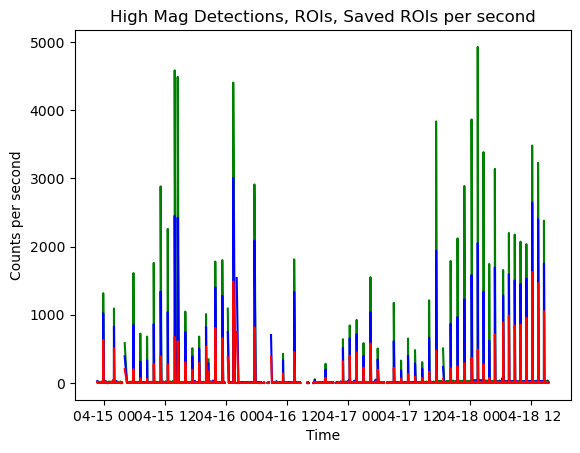

In [71]:
ll=cam_sums['highmag_detections (#/s)']<0
cam_sums.loc[ll,'highmag_detections (#/s)']=np.nan
plt.plot(cam_sums['highmag_detections (#/s)'],'g')
plt.plot(cam_sums['highmag_rois (#/s)'],'b')
plt.plot(cam_sums['highmag_saved_rois (#/s)'],'r')
plt.title('High Mag Detections, ROIs, Saved ROIs per second')
plt.xlabel('Time')
plt.ylabel('Counts per second')
plt.savefig(fig_dir / 'LRAUV_April2025_HighMag_Detections_ROIs_SavedROIs_perSecond.png')
#plt.ylim(0,20)


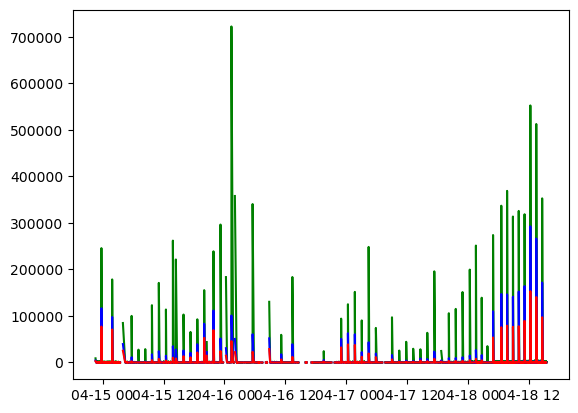

In [63]:
ll=cam_sums['lowmag_detections (#/s)']<0
cam_sums.loc[ll,'lowmag_detections (#/s)']=np.nan
plt.plot(cam_sums['lowmag_detections (#/s)'],'g')
plt.plot(cam_sums['lowmag_rois (#/s)'],'b')
plt.plot(cam_sums['lowmag_saved_rois (#/s)'],'r')


## Load LRAUV Data

These data are found as netcdf files on the Research Workspace:

`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504142054_202504150400_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504150400_202504152346_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504152347_202504160013_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160014_202504160017_2S_scieng.nc`
`/Volumes/patrick_ssd/Synchro_April_2025/LRAUV_CTD/202504160018_202504181753_2S_scieng.nc`


__Goal__: Align the datetime from planktivore images to the LRAUV CTD Data (with some type of tolerance)

In [ ]:
#interval_index=counts.index.categories.rename('time_interval')
#interval_index_cam=cam_counts.index.rename('time_interval')
#x_pos1=interval_index.left
#y_pos1=counts.values
#x_pos2=interval_index_cam.left
#y_pos2=cam_counts.values
##plt.plot(x_pos1,y_pos1,'b.-')
#plt.plot(y_pos1,'b')
#plt.plot(y_pos2,'r')
##plt.plot(x_pos2,y_pos2,'r.-') # do the zeros on this plot correspond to times when the camera was off?
##plt.xlabel('Time')
##plt.xlim(60000,80000)
#plt.ylabel('Counts')
#plt.ylim(-2,40)
##print(cam_counts.shape)
##print(bins.shape)

In [ ]:
## How do we define no camera ROIs vs planktivore not running and thus no ROIs?
## We want to put NaN vs 0.


#edges = pd.to_datetime(labeled.index).sort_values().unique()
#
## build interval bins [start, end)
#bins = pd.IntervalIndex.from_breaks(edges, closed="left")
## assign each event to a bin
#bin_codes = pd.cut(df["dateTime"], bins=bins, right=False)
## count events per bin (this keeps the IntervalIndex)
#counts = df.groupby(bin_codes).size()

## reindex so we also get zeros for bins with no events
## This is where we need to make sure if it is a true zero or an NaN.  We cannot assume that the value is zero.
## NEED NEW CODE HERE TO DISTINGUISH BETWEEN 0 AND NaN

#counts = counts.reindex(bins, fill_value=0)

## map interval index to left edge (the "stime")
#counts.index = counts.index.left

## align back to labeled.index (so last row is also included with 0)
#labeled["rois_count"] = counts.reindex(labeled.index, fill_value=0).astype(int)

In [64]:
labeled.keys()

Index(['fix_latitude', 'fix_longitude', 'salinity', 'temperature',
       'mass_concentration_of_oxygen_in_sea_water',
       'bin_mean_sea_water_salinity', 'bin_median_sea_water_salinity',
       'bin_mean_sea_water_temperature', 'bin_median_sea_water_temperature',
       'PAR', 'chlorophyll', 'chl', 'bbp470', 'bbp650',
       'volumescatcoeff117deg470nm', 'volumescatcoeff117deg650nm',
       'particulatebackscatteringcoeff470nm',
       'particulatebackscatteringcoeff650nm',
       'fix_residual_percent_distance_traveled_DeadReckonUsingMultipleVelocitySources',
       'latitude', 'longitude', 'depth', 'phase', 'cast_id', 'turning_point',
       'cast_id_unique', 'distance_km', 'rois_count'],
      dtype='object')

In [ ]:
#uid=34
#test=labeled['cast_id']==uid
#onecast=labeled[test]
#onecast.keys()

In [ ]:
## This is to get the time values for a profile that had roi count of zero
#junk=onecast.index
#junk=junk.astype(np.int64)
#print(junk)
#print(type(junk))
##print(np.max(test))
##print(np.min(test))

In [ ]:
#uid=np.unique(labeled['cast_id'])
#
#lids=np.arange(0,len(uid))
#for cast in lids:
#    cid=uid[cast]
#    cindex=np.where(labeled['cast_id']==cid)
#    tmpc=labeled['rois_count'].iloc[cindex[0]]
#    tmpd=labeled['depth'].iloc[cindex[0]]
#    plt.plot(labeled['rois_count'].iloc[cindex[0]],labeled['depth'].iloc[cindex[0]])
#    plt.ylim(labeled['depth'].iloc[cindex[0]].max(),labeled['depth'].iloc[cindex[0]].min())
#    plt.title('cast id '+str(cid))
#    #plt.show()
#    plt.savefig('./cast_plots/cast_'+str(uid[cast])+'_rois.jpg')
#    plt.clf()

In [ ]:
# check cast 30, 57,70,2,117,126 
#cid=uid[cast]
#cid=126
#cindex=np.where((labeled['cast_id']==cid)&(labeled['phase']=='up'))
#tmpc=labeled['rois_count'][cindex[0]]
#tmpd=labeled['depth'][cindex[0]]
#plt.plot(labeled['rois_count'][cindex[0]],labeled['depth'][cindex[0]])
#plt.ylim(labeled['depth'][cindex[0]].max(),labeled['depth'][cindex[0]].min())
#plt.title('cast id '+str(cid))


In [ ]:
## casts to drop due to planktivore not running and ROI counts zero for all or part of profile
#casttodrop=[1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,30,31,31,32,32,33,33,34,34,35,35,57,70,82,93,93,94,94,95,95,96,96,97,97,98,98,112,112,113,113,114,114,115,115,116,116,117,126]
#phasetodrop=['down','up','down','up','down','up','down','up','down','up', # 1,2,3,4,5
#             'down','up','down','up','down','up','down','up','down','up', # 6,7,8,9,10
#             'down','up','down','up','up','down','up','down','up','down','up', # 11,12,30,31,32,33
#             'down','up','down','up','up','up','up','down','up','down','up','down','up', #34,35,57,70,82,93,94,95
#             'down','up','down','up','down','up','down','up','down','up','down','up', #96,97,98,112,113,114
#             'down','up','down','up','down','down'] # 115,116,117,126
#ldr=np.arange(0,len(casttodrop))
##print(len(phasetodrop))
#for dropit in ldr:
#    condition_to_drop=(labeled['cast_id']==casttodrop[dropit])&(labeled['phase']==phasetodrop[dropit])
#    labeled=labeled[~condition_to_drop]

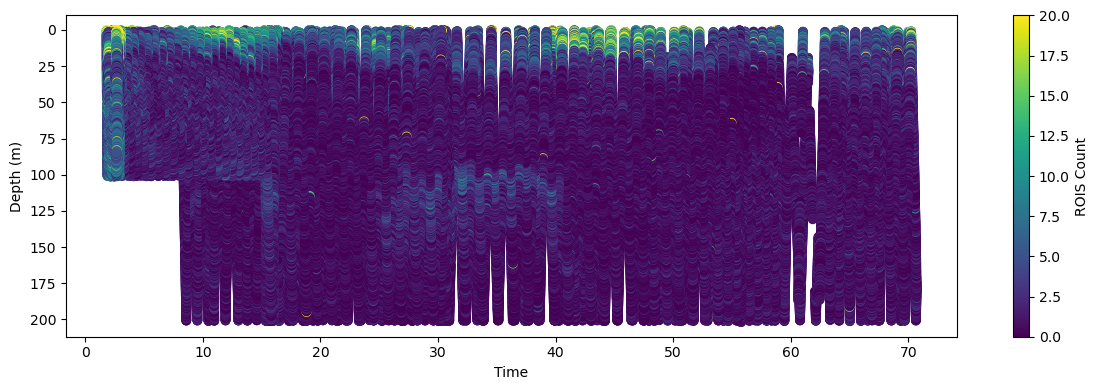

In [65]:
fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    labeled.distance_km,labeled['depth'], c=labeled['rois_count'])
sc.set_clim(0, 20)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()

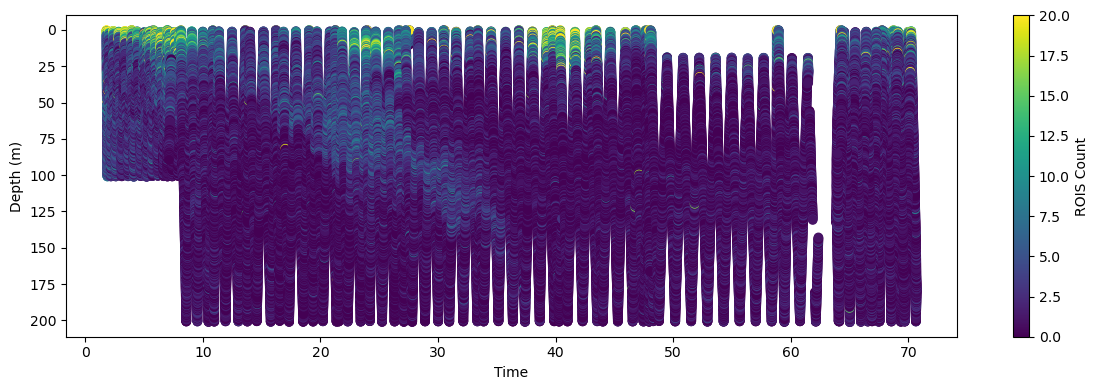

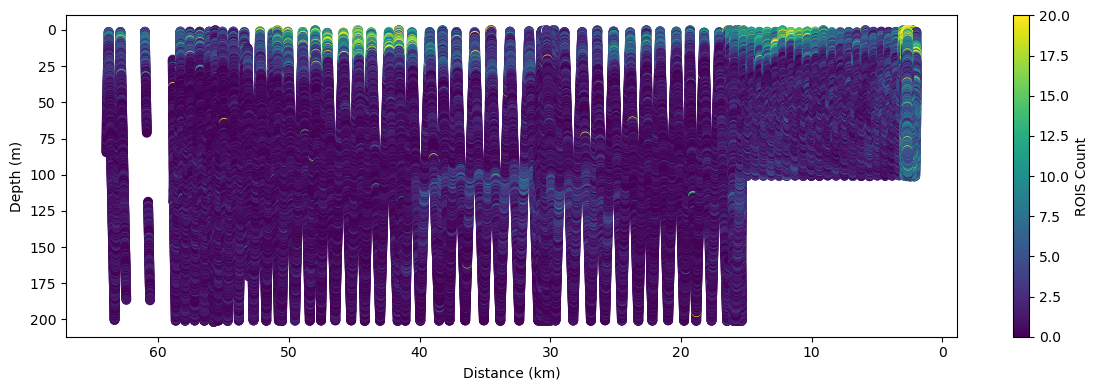

In [66]:
out_trans = labeled.iloc[:65000]
in_trans = labeled.iloc[65000:]


fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    out_trans.distance_km,out_trans['depth'], c=out_trans['rois_count'])
sc.set_clim(0, 20)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()
plt.savefig('ROI_count_outbound_April2025Synchro.jpg',dpi=300)

fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    in_trans.distance_km,in_trans['depth'], c=in_trans['rois_count'])
sc.set_clim(0, 20)
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()
plt.savefig('ROI_count_inbound_April2025Synchro.jpg',dpi=300)

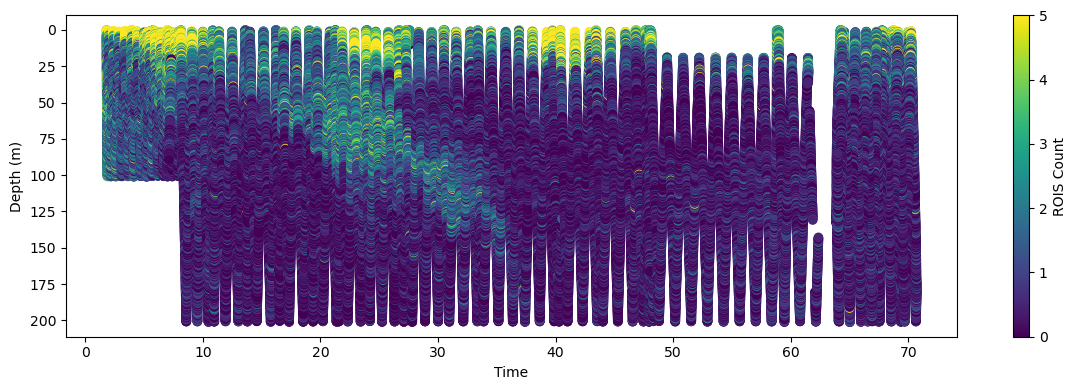

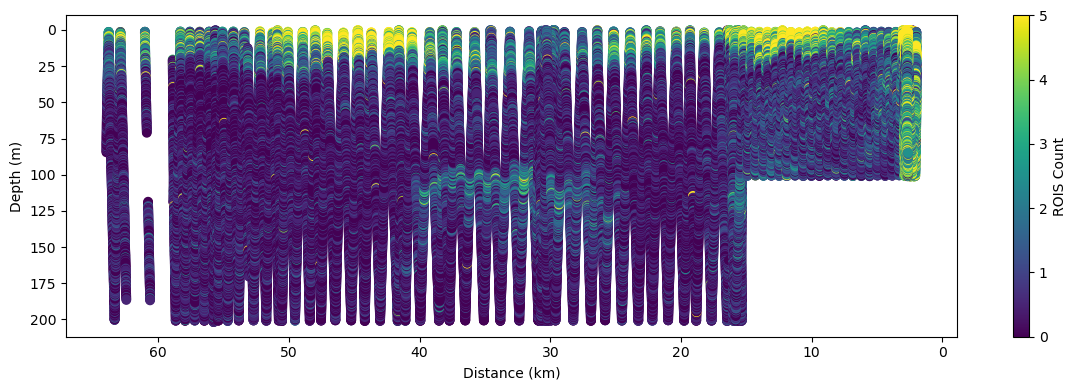

In [67]:
# Elapsed time (s) between current index and next one, starting at index 0
elapsed_seconds = (
    labeled.index.to_series()
    .diff()
    .dt.total_seconds()
    .shift(-1)        # shift so first interval is at position 0
    .astype('Int64')
)

# Timedelta differences as integer seconds (nullable Int64 keeps the first NA)

labeled['rois_norm'] = labeled['rois_count'] / elapsed_seconds
out_trans = labeled.iloc[:65000]
in_trans = labeled.iloc[65000:]


fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    out_trans.distance_km,out_trans['depth'], c=out_trans['rois_norm'])
sc.set_clim(0, 5)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Time')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12, 4))
sc = ax.scatter(
    in_trans.distance_km,in_trans['depth'], c=in_trans['rois_norm'])
sc.set_clim(0, 5)
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Distance (km)')
plt.colorbar(sc, label='ROIS Count')
# plt.title('LRAUV Optical Backscatter (470nm) April 2025')
plt.tight_layout()


## Add Inference Data to Profiles

This is the same tedious step, find the time bounds of each samples

In [68]:
import pandas as pd

# Your target labels
labels = [
 'Akashiwo',
 'Amphidinium_Oxyphysis',
 'Ceratium',
 'Chaetoceros',
 'Ciliate',
 'Cylindrotheca',
 'Detonula_Cerataulina_Lauderia',
 'Detritus',
 'Dictyocha',
 'Dinoflagellate',
 'Eucampia',
 'Guinardia_Dactyliosolen',
 'Gyrodinium',
 'Medium_pennate',
 'Mesodinium',
 'Mixed_diatom_chain',
 'Nano_plankton',
 'Polykrikos',
 'Prorocentrum',
 'Pseudo-nitzschia',
 'Strombidium',
 'Thalassionema',
 'Thalassiosira',
 'Tiarina',
 'Truncated',
 'unknown_flagellate'
]

# Suppose your dataframe has a 'label' column
# Example: counts = df['label'].value_counts()
#counts = inference["label1"].value_counts()
counts = inference_filtered["label1"].value_counts()

# Reindex with your full list and fill missing with zero
counts = counts.reindex(labels, fill_value=0)

# Optionally make it a DataFrame
label_counts = counts.reset_index()
label_counts.columns = ["label", "count"]

print(label_counts)

                            label   count
0                        Akashiwo     503
1           Amphidinium_Oxyphysis    5334
2                        Ceratium   14244
3                     Chaetoceros   50451
4                         Ciliate    8560
5                   Cylindrotheca  116416
6   Detonula_Cerataulina_Lauderia    6887
7                        Detritus   17053
8                       Dictyocha   26471
9                  Dinoflagellate   41860
10                       Eucampia    2964
11        Guinardia_Dactyliosolen   16739
12                     Gyrodinium     467
13                 Medium_pennate    3210
14                     Mesodinium     267
15             Mixed_diatom_chain    5272
16                  Nano_plankton   15632
17                     Polykrikos    1272
18                   Prorocentrum    1075
19               Pseudo-nitzschia    5174
20                    Strombidium   14091
21                  Thalassionema   18161
22                  Thalassiosira 

In [69]:
# --- Assumptions ---
# labeled.index: strictly increasing, unique DatetimeIndex (bin edges)
# inference: columns ['dateTime', 'label1'] ; dateTime is datetime64
# all_labels: list of label names (columns order you want)

# 0) Ensure types
edges = pd.to_datetime(labeled.index).sort_values().unique()
# original code
#inference = inference.copy()
#inference["dateTime"] = pd.to_datetime(inference["dateTime"])
#inference["label1"] = pd.Categorical(inference["label1"], categories=all_labels)
inference_filtered = inference_filtered.copy()
inference_filtered["dateTime"] = pd.to_datetime(inference_filtered["dateTime"])
inference_filtered["label1"] = pd.Categorical(inference_filtered["label1"], categories=all_labels)

# 1) Build left-closed, right-open bins: [start, end)
bins = pd.IntervalIndex.from_breaks(edges, closed="left")

# 2) Bin events
#binned = pd.cut(inference["dateTime"], bins=bins, right=False) # original code
binned = pd.cut(inference_filtered["dateTime"], bins=bins, right=False)

# 3) Count per interval × label (use observed=True to avoid the FutureWarning)
# original code
#counts = (
#    inference.groupby([binned, "label1"], observed=True)
#    .size()
#    .unstack("label1", fill_value=0)
#    .reindex(columns=all_labels, fill_value=0)
#)
counts = (
    inference_filtered.groupby([binned, "label1"], observed=True)
    .size()
    .unstack("label1", fill_value=0)
    .reindex(columns=all_labels, fill_value=0)
)

# 4) Ensure **every** interval is present (even empty ones)
counts = counts.reindex(bins, fill_value=0)

# 5) Replace IntervalIndex with its left edge (DatetimeIndex)
counts.index = counts.index.left  # -> Interval start time

# 6) Compute elapsed seconds for each interval (aligned to left edge)
dt = pd.Series(edges, index=edges)            # helpful alignment
elapsed_seconds = (dt.shift(-1) - dt).dt.total_seconds()
elapsed_seconds = elapsed_seconds.loc[counts.index]  # align to left edges

# 7) Rates (counts per second): last bin has NaN duration → fill with 0 later
rates = counts.div(elapsed_seconds, axis=0)

# 8) Join into labeled by left edge, zero-fill where missing
# (This preserves your original labeled rows, including the last edge)
labeled = labeled.join(counts, how="left", rsuffix="_count")
# Do we really want to fill with 0s here?  Maybe NaN is better to indicate no data?
#labeled = labeled.fillna(0)

# 9) If you also want the rates joined (optional):
rate_cols = [f"{c}_rate" for c in counts.columns]
rates.columns = rate_cols
# Again not sure we want to fill in with 0s here.  Maybe NaN is better.
#labeled = labeled.join(rates, how="left").fillna(0)

In [ ]:
all_labels

In [70]:
# Checkpoint
labeled.to_parquet("c:/planktivore/lrauv_april2025_with_class_20251009model_filtered_addNaN.parquet")